## CLustering pipeline

- Run on the 3hvc protein



In [1]:
# Define data path
data_path = "/Users/nicha/dev/Protein-preparation-pipeline/data/toy_examples_clustering"

# System and OS utilities
import os
import sys

# Numerical and Data Processing
import numpy as np
import pandas as pd

# Scientific and Bioinformatics Tools
from math import e
from pymol import cmd, stored
import numpy as np
from Bio import PDB
from scipy.spatial import distance_matrix, KDTree
from scipy.stats import shapiro
from joblib import Parallel, delayed
from tqdm import tqdm
from itertools import combinations


# Machine Learning & Clustering
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import euclidean_distances

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import py3Dmol

# Color Mapping for Visualization
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from matplotlib.colors import Normalize
from mpl_toolkits.mplot3d import Axes3D

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.metrics import silhouette_score
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy.linalg import eigh
from scipy.sparse.csgraph import laplacian
from sklearn.neighbors import kneighbors_graph

# Add project-specific source path
sys.path.append('/Users/nicha/dev/Protein-preparation-pipeline/src/')

# Custom Modules from Your Project
from pdb_retrival.data_retriever import PDBDataRetriever

In [3]:
# Function for the data preparation

# 1️⃣ Extract residue coordinates from PDB
def extract_residue_coordinates(pdb_file, residue_number, chain_id="A"):
    """
    Extracts atomic coordinates for a given residue from a PDB file.

    Args:
        pdb_file (str): Path to the PDB file.
        residue_number (int): Residue number to extract.
        chain_id (str): Chain ID of the residue.

    Returns:
        list: List of tuples (atom_type, x, y, z).
    """
    coordinates = []
    try:
        with open(pdb_file, "r") as file:
            for line in file:
                if line.startswith(("ATOM", "HETATM")) and line[21] == chain_id:
                    resi = int(line[22:26].strip())
                    if resi == residue_number:
                        atom_type = line[76:78].strip()
                        x = float(line[30:38].strip())
                        y = float(line[38:46].strip())
                        z = float(line[46:54].strip())
                        coordinates.append((atom_type, x, y, z))
    except FileNotFoundError:
        print(f"Error: File {pdb_file} not found.")
    except Exception as e:
        print(f"Unexpected error: {e}")
    return coordinates


# 2️⃣ Compute Weighted Center of Mass
def calculate_weighted_center_of_mass(coordinates):
    """
    Calculates the weighted center of mass for a given set of atomic coordinates.

    Args:
        coordinates (list): List of tuples (atom_type, x, y, z).

    Returns:
        list: [x, y, z] coordinates of the weighted center of mass.
    """
    total_weight = 0
    weighted_coords = np.zeros(3)
    atomic_weights = {"H": 1.008, "C": 12.011, "N": 14.007, "O": 15.999, "S": 32.06}

    for atom_type, x, y, z in coordinates:
        weight = atomic_weights.get(atom_type.upper(), 1.0)
        weighted_coords += np.array([x, y, z]) * weight
        total_weight += weight

    return np.round(weighted_coords / total_weight, 3).tolist()


# 3️⃣ Process a Single PDB File and Update the DataFrame
def process_pdb_file(data_path, pdb_code, df):
    """
    Reads a PDB file and updates a DataFrame with residue center of mass.

    Args:
        data_path (str): Path to the directory containing the PDB and CSV files.
        pdb_code (str): PDB code of the protein.
        df (pd.DataFrame): DataFrame containing residue data.

    Returns:
        pd.DataFrame: Updated DataFrame with center of mass information.
    """
    pdb_file = os.path.join(data_path, f"{pdb_code}.pdb")

    try:
        for index, row in df.iterrows():
            residue_number = row["resi"]
            chain_id = row["chain"]
            coordinates = extract_residue_coordinates(pdb_file, residue_number, chain_id)
            if coordinates:
                center_of_mass = calculate_weighted_center_of_mass(coordinates)
                df.loc[index, "resn_coordinates"] = str(coordinates)
                df.loc[index, ["center_of_mass_x", "center_of_mass_y", "center_of_mass_z"]] = center_of_mass
            else:
                print(f"Residue {residue_number} in chain {chain_id} not found in {pdb_file}.")
    except FileNotFoundError:
        print(f"Error: {pdb_file} not found.")
    except Exception as e:
        print(f"Unexpected error: {e}")

    return df


# 4️⃣ Process and Update Data for a Single PDB Structure
def process_and_update_pdb_data(data_path, pdb_code):
    """
    Reads and processes a PDB file and corresponding CSV file to update residue information.

    Args:
        data_path (str): Path to the directory containing the PDB and CSV files.
        pdb_code (str): PDB code of the protein.

    Returns:
        pd.DataFrame: Updated DataFrame with residue information.
    """
    csv_file_path = f"{data_path}/results_{pdb_code}.csv"

    try:
        df = pd.read_csv(csv_file_path)
        df_updated = process_pdb_file(data_path, pdb_code, df)
        df_updated.to_csv(f"{data_path}/results_{pdb_code}_updated.csv", index=False)
        return df_updated
    except Exception as e:
        print(f"Error processing {pdb_code}: {e}")
        return None


# 5️⃣ Process All PDB Files in a Directory
def process_all_pdb_files(data_path):
    """
    Process all PDB-related files in the given directory and combine results.

    Args:
        data_path (str): Path to the directory containing the PDB and CSV files.

    Returns:
        pd.DataFrame: Combined DataFrame with all processed data.
    """
    combined_df = pd.DataFrame()

    for file in os.listdir(data_path):
        if file.startswith("results_") and file.endswith(".csv"):
            pdb_code = file.split("_")[1].split(".")[0]
            updated_df = process_and_update_pdb_data(data_path, pdb_code)
            if updated_df is not None:
                updated_df["PDBcode"] = pdb_code
                combined_df = pd.concat([combined_df, updated_df], ignore_index=True)

    combined_df.drop_duplicates(inplace=True)
    combined_df.to_csv(f"{data_path}/combined_results.csv", index=False)
    return combined_df


# 6️⃣ Compute Center of Protein Using PyMOL
def calculate_center_of_mass_pymol(pdb_file):
    """
    Calculates the center of mass of a protein using PyMOL.

    Args:
        pdb_file (str): Path to the PDB file.

    Returns:
        tuple: (x, y, z) coordinates of the protein's center of mass.
    """
    cmd.load(pdb_file, "protein")
    center_of_mass = cmd.centerofmass("protein")
    cmd.delete("all")
    return round(center_of_mass[0], 3), round(center_of_mass[1], 3), round(center_of_mass[2], 3)


# 7️⃣ Compute Protein Diameter
def calculate_protein_diameter(df):
    """
    Computes the diameter of a protein, defined as the maximum distance between residues.

    Args:
        df (pd.DataFrame): DataFrame containing residue data with center of mass coordinates.

    Returns:
        float: Maximum distance between residues.
    """
    coordinates = df[['center_of_mass_x', 'center_of_mass_y', 'center_of_mass_z']].values
    distances = np.linalg.norm(coordinates[:, np.newaxis] - coordinates, axis=2)
    return round(np.max(distances), 3)


# 8️⃣ Process Protein Data for a Single PDB
def process_protein_data(pdb_code, dfs, data_path):
    """
    Processes protein data by computing center of mass and diameter.

    Args:
        pdb_code (str): The PDB code of the protein.
        dfs (dict): Dictionary containing DataFrames indexed by PDB code.
        data_path (str): Path to the directory containing the PDB files.

    Returns:
        pd.DataFrame: Updated DataFrame with center of protein and diameter.
    """
    pdb_file_path = f"{data_path}/{pdb_code}.pdb"
    df = dfs[pdb_code]
    center_of_mass = calculate_center_of_mass_pymol(pdb_file_path)
    protein_diameter = calculate_protein_diameter(df)

    df["protein_x"], df["protein_y"], df["protein_z"] = center_of_mass
    df["protein_diameter"] = protein_diameter

    return df



def normalize_features(df, feature_columns):
    """
    Normalize or standardize features based on their distribution.

    - **Standardizes (Z-score) if normally distributed**.
    - **Normalizes (Min-Max) if not normally distributed**.
    - **Adds new columns instead of replacing existing ones**.
    - **Stores scalers for consistent transformation in clustering**.

    Args:
        df (pd.DataFrame): DataFrame containing features.
        feature_columns (list): List of feature column names (e.g., 3D coordinates).

    Returns:
        pd.DataFrame: DataFrame with added transformed feature columns.
        dict: Dictionary of fitted scalers (for later reuse).
    """
    processed_df = df.copy()
    scalers = {}

    for col in feature_columns:
        stat, p_value = shapiro(df[col].dropna())  # Test normality
        
        if p_value > 0.05:  
            scaler = StandardScaler()  # Standardization if normal
            new_col_name = f"{col}_standardized"
        else:  
            scaler = MinMaxScaler()  # Normalization if not normal
            new_col_name = f"{col}_normalized"

        processed_df[new_col_name] = scaler.fit_transform(df[[col]])  # Apply transformation
        scalers[col] = scaler  # Store scaler for reuse

    return processed_df, scalers


def weighted_pbind(df, pbind_column='p(bind)', weights=[1.0]):
    """
    Normalize and apply multiple weight factors to p(bind).

    - **Scales p(bind) between 0 and 1**.
    - **Applies multiple weight factors** to create additional columns.
    - **Adds new columns instead of replacing p(bind)**.
    - **Stores scaler** for reuse in clustering.

    Args:
        df (pd.DataFrame): DataFrame containing p(bind).
        pbind_column (str): Column name for p(bind).
        weights (list): List of weight multipliers (e.g., [1.0, 5.0, 10.0, 100.0]).

    Returns:
        pd.DataFrame: DataFrame with weighted p(bind) columns.
        dict: Dictionary of fitted scalers.
    """
    processed_df = df.copy()
    scalers = {}

    if pbind_column in df.columns:
        scaler = MinMaxScaler()
        normalized_pbind = scaler.fit_transform(df[[pbind_column]])  # Scale to 0-1
        scalers[pbind_column] = scaler  # Store scaler

        for weight in weights:
            weighted_col_name = f"{pbind_column}_weight_{weight}"
            processed_df[weighted_col_name] = normalized_pbind * weight  # Apply weight

    return processed_df, scalers
    """
    Normalize and apply multiple weight factors to p(bind).

    - **Scales p(bind) between 0 and 1**.
    - **Applies multiple weight factors** to create additional columns.
    - **Stores scaler** for reuse in clustering.

    Args:
        df (pd.DataFrame): DataFrame containing p(bind).
        pbind_column (str): Column name for p(bind).
        weights (list): List of weight multipliers (e.g., [1.0, 1.5, 2.0]).

    Returns:
        pd.DataFrame: DataFrame with weighted p(bind) columns.
        dict: Dictionary of fitted scalers.
    """
    processed_df = df.copy()
    scalers = {}

    if pbind_column in df.columns:
        scaler = MinMaxScaler()
        normalized_pbind = scaler.fit_transform(df[[pbind_column]])  # Scale to 0-1
        scalers[pbind_column] = scaler  # Store scaler

        for weight in weights:
            weighted_col_name = f"{pbind_column}_weight_{weight}"
            processed_df[weighted_col_name] = normalized_pbind * weight  # Apply weight

    return processed_df, scalers


In [32]:
# Function to evaluate the clustering performance
def calculate_protein_center_of_mass(pdb_file):
    """
    Calculate the center of mass of the entire protein using PyMOL.

    Args:
        pdb_file (str): Path to the PDB file.

    Returns:
        tuple: Center of mass coordinates (x, y, z).
    """
    cmd.load(pdb_file, "protein")
    center_of_mass = cmd.centerofmass("protein")
    cmd.delete("all")  # Clear the loaded structure
    return tuple(round(coord, 3) for coord in center_of_mass)

def calculate_cluster_centers(df, cluster_column, pdb_file):
    """
    Calculate the center of mass for each cluster using PyMOL.

    Args:
        df (pd.DataFrame): DataFrame containing residue and cluster information.
        cluster_column (str): Column name containing cluster IDs.
        pdb_file (str): Path to the PDB file.

    Returns:
        dict: Cluster IDs as keys and their center of mass coordinates as values.
    """
    cmd.load(pdb_file, "protein")
    cluster_centers = {}
    clusters = df[cluster_column].unique()

    for cluster_id in clusters:
        cluster_data = df[df[cluster_column] == cluster_id]
        resi_selection = "+".join(map(str, cluster_data['resi']))
        cmd.select(f"cluster_{cluster_id}", f"resi {resi_selection}")
        center_of_mass = cmd.centerofmass(f"cluster_{cluster_id}")
        cluster_centers[cluster_id] = tuple(round(coord, 3) for coord in center_of_mass)
        cmd.delete(f"cluster_{cluster_id}")

    cmd.delete("all")  # Clear the loaded structure
    return cluster_centers

def calculate_ligand_centers_slow(pdb_file):
    """
    Calculate the center of mass for each ligand in the structure using PyMOL.

    Args:
        pdb_file (str): Path to the PDB file.

    Returns:
        dict: Ligand identifiers as keys and their center of mass coordinates as values.
    """
    cmd.load(pdb_file, "protein")
    cmd.select("ligands", "organic")
    ligand_centers = {}

    for atom in cmd.get_model("ligands").atom:
        ligand_id = f"{atom.chain}_{atom.resn}_{atom.resi}"
        cmd.select("ligand", f"chain {atom.chain} and resn {atom.resn} and resi {atom.resi}")
        center_of_mass = cmd.centerofmass("ligand")
        ligand_centers[ligand_id] = tuple(round(coord, 3) for coord in center_of_mass)
        cmd.delete("ligand")  # Clear the selection

    cmd.delete("all")  # Clear the loaded structure
    return ligand_centers


def calculate_ligand_centers(pdb_file):
    """
    Calculate the center of mass for each ligand in the structure using PyMOL.

    Args:
        pdb_file (str): Path to the PDB file.

    Returns:
        dict: Ligand identifiers as keys and their center of mass coordinates as values.
    """
    cmd.load(pdb_file, "protein")
    cmd.select("ligands", "organic")
    
    ligand_centers = {}
    stored.stored_atoms = []  # Corrected: Define `stored_atoms` in the PyMOL namespace

    # Iterate through ligands and collect unique identifiers
    cmd.iterate("ligands", "stored.stored_atoms.append((chain, resn, resi))")

    unique_ligands = set(stored.stored_atoms)  # Get unique ligand identifiers

    for chain, resn, resi in unique_ligands:
        ligand_id = f"{chain}_{resn}_{resi}"
        cmd.select("ligand", f"chain {chain} and resn {resn} and resi {resi}")
        center_of_mass = cmd.centerofmass("ligand")
        ligand_centers[ligand_id] = tuple(round(coord, 3) for coord in center_of_mass)
        cmd.delete("ligand")  # Clear selection

    cmd.delete("all")  # Clear everything from PyMOL session
    return ligand_centers

def calculate_ligand_diameter(pdb_file):
    """
    Calculate the diameter of each ligand (maximum pairwise distance between its atoms).

    Args:
        pdb_file (str): Path to the PDB file.

    Returns:
        dict: Ligand identifiers as keys and their diameters as values.
    """
    cmd.load(pdb_file, "protein")
    cmd.select("ligands", "organic")

    ligand_diameters = {}

    # Store ligand atom coordinates
    stored.ligand_atoms = []
    cmd.iterate_state(1, "ligands", "stored.ligand_atoms.append((chain, resn, resi, x, y, z))")

    unique_ligands = {}
    for chain, resn, resi, x, y, z in stored.ligand_atoms:
        ligand_id = f"{chain}_{resn}_{resi}"
        if ligand_id not in unique_ligands:
            unique_ligands[ligand_id] = []
        unique_ligands[ligand_id].append((x, y, z))

    # Compute ligand diameters
    for ligand_id, coordinates in unique_ligands.items():
        if len(coordinates) > 1:
            max_distance = max(
                np.linalg.norm(np.array(p1) - np.array(p2))
                for p1, p2 in combinations(coordinates, 2)
            )
            ligand_diameters[ligand_id] = round(max_distance, 3)
        else:
            ligand_diameters[ligand_id] = 0.0  # Single atom ligand, diameter is zero

    cmd.delete("all")  # Clear the loaded structure
    return ligand_diameters


def calculate_grid_size_ligand(ligand_diameter):
    """
    Compute the grid size based on the ligand diameter.

    Args:
        ligand_diameter (float): Diameter of the ligand.

    Returns:
        float: Computed grid size.
    """
    return round(16 + (0.8 * ligand_diameter), 3)


def define_bounding_box_ligand(ligand_centers, ligand_diameters):
    """
    Define a bounding box around the ligands based on their diameters.

    Args:
        ligand_centers (dict): Ligand identifiers and their center of mass coordinates.
        ligand_diameters (dict): Ligand identifiers and their diameters.

    Returns:
        dict: Bounding box coordinates for each ligand.
    """
    bounding_boxes = {}

    for ligand_id, center in ligand_centers.items():
        if ligand_id not in ligand_diameters:
            print(f"Warning: Missing diameter for ligand {ligand_id}")
            continue

        grid_size = calculate_grid_size_ligand(ligand_diameters[ligand_id])

        min_coords = [center[i] - grid_size / 2 for i in range(3)]
        max_coords = [center[i] + grid_size / 2 for i in range(3)]

        bounding_boxes[ligand_id] = {"min": min_coords, "max": max_coords}

        # Add pseudoatoms in PyMOL for visualization
        cmd.pseudoatom(f"box_{ligand_id}_min", pos=min_coords, color="blue")
        cmd.pseudoatom(f"box_{ligand_id}_max", pos=max_coords, color="red")

        print(f"Bounding box for {ligand_id}: Min={min_coords}, Max={max_coords}")

    return bounding_boxes

def select_cluster_define_bounding_box(df, cluster_id, cluster_column, selection_name="cluster_selection"):
    """
    Select residues based on the clustering method and create a bounding box in PyMOL.

    Args:
        df (pd.DataFrame): DataFrame containing residue data.
        cluster_id (int): The cluster ID to select residues for.
        cluster_column (str): Column name that stores cluster assignments.
        selection_name (str): Name of the selection in PyMOL.

    Returns:
        dict: Bounding box coordinates { "min": np.array, "max": np.array } for the selected cluster.
    """
    # Ensure required columns exist
    required_columns = {"chain", "resi", "center_of_mass_x", "center_of_mass_y", "center_of_mass_z"}
    missing_columns = required_columns - set(df.columns)
    if missing_columns:
        raise ValueError(f"Missing columns in DataFrame: {missing_columns}")

    # Filter residues based on the selected cluster
    selected_residues = df[df[cluster_column] == cluster_id]
    
    if selected_residues.empty:
        print(f"⚠️ No residues found for cluster {cluster_id} in column '{cluster_column}'")
        return None

    # Construct a PyMOL selection string
    selection_string = " or ".join(
        [f"(chain {row['chain']} and resi {row['resi']})" for _, row in selected_residues.iterrows()]
    )

    # Check if PyMOL is available
    try:
        cmd.select(selection_name, selection_string)
    except Exception as e:
        print(f"⚠️ PyMOL selection failed: {e}")
        return None

    # Compute the bounding box
    min_coords = selected_residues[['center_of_mass_x', 'center_of_mass_y', 'center_of_mass_z']].min().to_numpy()
    max_coords = selected_residues[['center_of_mass_x', 'center_of_mass_y', 'center_of_mass_z']].max().to_numpy()

    # Convert coordinates to float for compatibility
    min_coords = np.array([float(coord) for coord in min_coords])
    max_coords = np.array([float(coord) for coord in max_coords])

    # Add pseudoatoms for visualization
    try:
        cmd.pseudoatom(f"{selection_name}_box_min", pos=min_coords.tolist(), color="blue")
        cmd.pseudoatom(f"{selection_name}_box_max", pos=max_coords.tolist(), color="red")
    except Exception as e:
        print(f"⚠️ Failed to create pseudoatoms in PyMOL: {e}")

    print(f"✅ Selection '{selection_name}' created for cluster {cluster_id}")
    print(f"📦 Bounding box: Min={min_coords.tolist()}, Max={max_coords.tolist()}")

    return {"min": min_coords, "max": max_coords}


def calculate_dice_score(cluster_selection, ligand_selection):
    """
    Compute the Dice similarity coefficient between a cluster and a ligand.

    Args:
        cluster_selection (str): PyMOL selection name for the cluster.
        ligand_selection (str): PyMOL selection name for the ligand.

    Returns:
        float: Dice score indicating spatial overlap (higher means better overlap).
    """
    # Get atoms in selections
    cluster_atoms = set(cmd.index(cluster_selection))
    ligand_atoms = set(cmd.index(ligand_selection))

    if not cluster_atoms or not ligand_atoms:
        print(f"Error: One or both selections are empty: {cluster_selection}, {ligand_selection}")
        return 0.0

    # Compute Dice coefficient
    intersection = len(cluster_atoms & ligand_atoms)
    dice_score = (2 * intersection) / (len(cluster_atoms) + len(ligand_atoms))

    print(f"Dice Score between {cluster_selection} and {ligand_selection}: {round(dice_score, 3)}")
    
    return round(dice_score, 3)

def calculate_distances_between_clusters_and_ligands(cluster_centers, ligand_centers):
    """
    Calculate the minimum distance between each cluster and the ligands.

    Args:
        cluster_centers (dict): Cluster IDs and their center of mass coordinates.
        ligand_centers (dict): Ligand identifiers and their center of mass coordinates.

    Returns:
        dict: Cluster IDs as keys and tuples of (closest ligand ID, distance) as values.
    """
    distances = {}

    for cluster_id, cluster_center in cluster_centers.items():
        min_distance = float('inf')
        closest_ligand = None

        for ligand_id, ligand_center in ligand_centers.items():
            distance = np.linalg.norm(np.array(cluster_center) - np.array(ligand_center))
            if distance < min_distance:
                min_distance = round(distance, 3)
                closest_ligand = ligand_id

        distances[cluster_id] = (closest_ligand, min_distance)

    return distances

def evaluate_clustering(pdb_file, df, cluster_column):
    """
    Evaluate the clustering by calculating distances between cluster centers and ligand centers.

    Args:
        pdb_file (str): Path to the PDB file.
        df (pd.DataFrame): DataFrame containing residue and cluster information.
        cluster_column (str): Column name containing cluster IDs.

    Returns:
        dict: Distances between each cluster and the closest ligand.
    """
    print("Calculating cluster centers...")
    cluster_centers = calculate_cluster_centers(df, cluster_column, pdb_file)

    print("Calculating ligand centers...")
    ligand_centers = calculate_ligand_centers(pdb_file)

    print("Calculating distances between clusters and ligands...")
    distances = calculate_distances_between_clusters_and_ligands(cluster_centers, ligand_centers)

    for cluster_id, (ligand_id, distance) in distances.items():
        print(f"Cluster {cluster_id} -> Closest Ligand: {ligand_id}, Distance: {distance} Å")

    return distances

# Pipeline Function
def run_pipeline(data_path, pdb_file, clustering_method, cluster_params, pbind_column='p(bind)', cutoff_method='median_std', std_factor=0.5):
    """
    Run the clustering pipeline, including clustering, normalization, filtering, and evaluation.

    Args:
        data_path (str): Path to the data directory.
        pdb_file (str): Path to the PDB file.
        clustering_method (str): Clustering method to use ('kmeans' or 'spectral').
        cluster_params (dict): Parameters for the clustering method.
        pbind_column (str): Column name for binding probabilities.
        cutoff_method (str): Method for calculating cutoff ('median_std' or 'percentile').
        std_factor (float): Factor for standard deviation when calculating cutoff.

    Returns:
        dict: Evaluation results including distances between clusters and ligands.
    """
    print("Loading data...")
    combined_df = process_all_pdb_files(data_path)

    print("Applying clustering...")
    if clustering_method == 'kmeans':
        n_clusters = cluster_params.get('n_clusters', 3)
        combined_df, _ = kmeans_clustering(combined_df, feature_columns=cluster_params['feature_columns'], n_clusters=n_clusters)
    elif clustering_method == 'spectral':
        n_clusters = cluster_params.get('n_clusters', 3)
        affinity = cluster_params.get('affinity', 'nearest_neighbors')
        combined_df, _ = spectral_clustering(combined_df, feature_columns=cluster_params['feature_columns'], n_clusters=n_clusters, affinity=affinity)
    else:
        raise ValueError("Invalid clustering method. Choose 'kmeans' or 'spectral'.")

    print("Normalizing p(bind) within clusters...")
    combined_df = normalize_within_clusters(combined_df, cluster_column=clustering_method+'_cluster', pbind_column=pbind_column)

    print("Filtering residues based on p(bind) cutoff...")
    filtered_df = filter_by_pbind_cutoff(combined_df, pbind_column=pbind_column, cluster_column=clustering_method+'_cluster', cutoff_method=cutoff_method, std_factor=std_factor)

    print("Evaluating clustering...")
    evaluation_results = evaluate_clustering(pdb_file, filtered_df, cluster_column=clustering_method+'_cluster')

    return {
        'clustered_df': combined_df,
        'filtered_df': filtered_df,
        'evaluation_results': evaluation_results
    }


In [57]:
# Execute the data processing pipeline

# Process all files and get the combined DataFrame
combined_df = process_all_pdb_files(data_path)

# Ensure 'PDBcode' is present in combined_df
if 'PDBcode' not in combined_df.columns:
    raise ValueError("Error: 'PDBcode' column is missing in combined_df. Check preprocessing.")

# Create a dictionary of dataframes grouped by PDBcode
dfs = {pdb: df for pdb, df in combined_df.groupby('PDBcode')}

# Check if extracted dataframes match the original CSV files
for pdb in combined_df['PDBcode'].unique():
    original_csv_path = os.path.join(data_path, f"results_{pdb}.csv")
    
    if not os.path.exists(original_csv_path):
        print(f"Warning: Original CSV file missing for {pdb}. Skipping...")
        continue
    
    original_df = pd.read_csv(original_csv_path)
    
    if pdb in dfs:
        extracted_df = dfs[pdb]
    else:
        print(f"Warning: {pdb} missing in processed data. Reprocessing...")
        extracted_df = process_and_update_pdb_data(data_path, pdb)

    # Check if the number of entries match
    if len(original_df) == len(extracted_df):
        print(f"{pdb}: ✅ Match - {len(original_df)} entries")
    else:
        print(f"{pdb}: ❌ Mismatch - Original: {len(original_df)} entries, Extracted: {len(extracted_df)} entries")
        
        # Attempt to fix by loading updated version
        updated_csv_path = os.path.join(data_path, f"results_{pdb}_updated.csv")
        
        if os.path.exists(updated_csv_path):
            print(f"Fixing process by using updated data for {pdb}...")
            extracted_df = pd.read_csv(updated_csv_path)
            dfs[pdb] = extracted_df  # Update dictionary
            
            if len(original_df) == len(extracted_df):
                print(f"{pdb}: ✅ Fixed - Match after update: {len(original_df)} entries")
            else:
                print(f"{pdb}: ❌ Still Mismatch after update: {len(original_df)} vs {len(extracted_df)} entries")
        else:
            print(f"Error: No updated file found for {pdb}. Manual check required.")

# Define feature and p(bind) column
feature_columns = ['center_of_mass_x', 'center_of_mass_y', 'center_of_mass_z']
pbind_column = 'p(bind)'

# Process features for each PDB entry
for pdb_code in dfs.keys():
    # Normalize spatial features
    dfs[pdb_code], feature_scalers = normalize_features(dfs[pdb_code], feature_columns)
    
    # Apply multiple p(bind) weight factors
    dfs[pdb_code], pbind_scalers = weighted_pbind(dfs[pdb_code], pbind_column, weights=[1, 5, 10, 100])

    # Process protein metadata (diameter, center of mass)
    dfs[pdb_code] = process_protein_data(pdb_code, dfs, data_path)

    # Rename and clean up dataframe
    dfs[pdb_code].rename(columns=lambda x: x.strip(), inplace=True)
    dfs[pdb_code].drop(columns="Unnamed: 0", inplace=True, errors="ignore")  # Avoid errors if column missing

# Print an example output for verification
print("\n✅ Processed Data Example:")
print(dfs[list(dfs.keys())[0]].head())  # Print first PDB's processed dataframe


1qcf: ✅ Match - 450 entries
1ubq: ✅ Match - 76 entries
3g5d: ✅ Match - 513 entries
3zln: ✅ Match - 144 entries
4f9w: ✅ Match - 336 entries
1lyz: ✅ Match - 129 entries
1hvy: ✅ Match - 1152 entries
3hvc: ✅ Match - 327 entries
3cpa: ✅ Match - 307 entries
1pw6: ✅ Match - 250 entries
1ema: ✅ Match - 225 entries
1kv1: ✅ Match - 331 entries
1be9: ✅ Match - 120 entries
3ptb: ✅ Match - 220 entries
6o0k: ✅ Match - 141 entries
2bal: ✅ Match - 338 entries
4pti: ✅ Match - 58 entries
1yer: ✅ Match - 207 entries
1cz2: ✅ Match - 90 entries
3qkd: ✅ Match - 282 entries
1ao6: ✅ Match - 1156 entries
1h61: ✅ Match - 364 entries
1ny3: ✅ Match - 277 entries

✅ Processed Data Example:
     chain  resi resn   p(bind)  \
8133     A     5    S  0.008225   
8134     A     6    E  0.013932   
8135     A     7    V  0.044013   
8136     A     8    A  0.005330   
8137     A     9    H  0.007117   

                                       resn_coordinates  center_of_mass_x  \
8133  [('N', 56.653, 51.017, 34.141), ('C'

In [58]:
df = dfs["3hvc"]
pdb_file = data_path + "/3hvc.pdb"
# Compute ligand centers and diameters
ligand_centers = calculate_ligand_centers(pdb_file)
ligand_diameters = calculate_ligand_diameter(pdb_file)

# Compute grid sizes
grid_sizes = {lig_id: calculate_grid_size_ligand(diameter) for lig_id, diameter in ligand_diameters.items()}

# Print results
print("Ligand Centers:", ligand_centers)
print("Ligand Diameters:", ligand_diameters)
print("Computed Grid Sizes:", grid_sizes)

Ligand Centers: {'A_GG5_361': (-3.732, 37.54, 19.149), 'A_GG5_362': (24.619, 22.289, 26.946)}
Ligand Diameters: {'A_GG5_361': 8.652, 'A_GG5_362': 8.632}
Computed Grid Sizes: {'A_GG5_361': 22.922, 'A_GG5_362': 22.906}


In [61]:
# Function for preprocessing (Normalized the features and weighted pbind)
def preprocess_features(df, feature_columns, pbind_column='p(bind)', pbind_weights=[1.0]):
    """
    Normalize features based on their distribution and apply weighting to p(bind).

    - Standardizes normally distributed features (Z-score)
    - Normalizes non-normally distributed features (MinMax scaling)
    - Applies multiple weightings to `p(bind)`

    Args:
        df (pd.DataFrame): Input DataFrame.
        feature_columns (list): Feature columns (3D coordinates).
        pbind_column (str, optional): Column containing `p(bind)`. Defaults to 'p(bind)'.
        pbind_weights (list, optional): List of weights for `p(bind)`. Defaults to [1.0].

    Returns:
        pd.DataFrame: DataFrame with transformed features and weighted `p(bind)`.
        dict: Dictionary of scalers for later transformation consistency.
    """

    processed_df = df.copy()
    scalers = {}

    # # Normalize or standardize feature columns
    # for col in feature_columns:
    #     stat, p_value = shapiro(df[col].dropna())  # Shapiro-Wilk test for normality
    #     if p_value > 0.05:
    #         # Normally distributed → Standardization
    #         scaler = StandardScaler()
    #     else:
            # Not normally distributed → MinMax Normalization
    scaler = MinMaxScaler()
        
    processed_df[f"{col}_scaled"] = scaler.fit_transform(df[[col]])
    scalers[col] = scaler  # Store scaler for consistency

    # Normalize and apply weights to `p(bind)`
    if pbind_column in df.columns:
        pbind_scaler = MinMaxScaler()
        normalized_pbind = pbind_scaler.fit_transform(df[[pbind_column]])

        for weight in pbind_weights:
            processed_df[f"{pbind_column}_weight_{weight}"] = normalized_pbind * weight
        
        scalers[pbind_column] = pbind_scaler  # Store p(bind) scaler

    return processed_df, scalers

def kmeans_clustering(df, feature_columns, n_clusters):
    """
    Perform KMeans clustering and add cluster labels to the DataFrame.

    Args:
        df (pd.DataFrame): Input DataFrame.
        feature_columns (list): List of feature column names.
        n_clusters (int): Number of clusters.

    Returns:
        pd.DataFrame: Updated DataFrame with cluster labels.
        KMeans: Fitted KMeans model.
    """
    features = df[feature_columns].values
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    df['kmeans_cluster'] = kmeans.fit_predict(features)
    return df, kmeans

def normalize_within_clusters(df, cluster_column, pbind_column):
    """
    Normalize p(bind) values within each cluster.

    Args:
        df (pd.DataFrame): Input DataFrame.
        cluster_column (str): Column containing cluster IDs.
        pbind_column (str): Column containing p(bind) values.

    Returns:
        pd.DataFrame: Updated DataFrame with normalized p(bind) values.
    """
    df[f"normalized_{pbind_column}"] = df.groupby(cluster_column)[pbind_column].transform(
        lambda x: (x - x.min()) / (x.max() - x.min())
    )
    return df

# Filter by p(bind) cutoff
def filter_by_pbind_cutoff(df, pbind_column, cluster_column, cutoff_method, std_factor):
    """
    Filter residues based on p(bind) cutoff.

    Args:
        df (pd.DataFrame): Input DataFrame.
        pbind_column (str): Column containing p(bind) values.
        cluster_column (str): Column containing cluster IDs.
        cutoff_method (str): Method for calculating cutoff ('median_std' or 'percentile').
        std_factor (float): Factor for standard deviation in cutoff calculation.

    Returns:
        pd.DataFrame: Filtered DataFrame.
    """
    filtered_df = pd.DataFrame()

    for cluster_id in df[cluster_column].unique():
        cluster_data = df[df[cluster_column] == cluster_id]
        if cutoff_method == 'median_std':
            median_value = cluster_data[pbind_column].median()
            std_value = cluster_data[pbind_column].std()
            cutoff = median_value + std_factor * std_value
        elif cutoff_method == 'percentile':
            cutoff = cluster_data[pbind_column].quantile(0.95)
        else:
            raise ValueError("Invalid cutoff method. Use 'median_std' or 'percentile'.")

        filtered_cluster = cluster_data[cluster_data[pbind_column] > cutoff]
        filtered_df = pd.concat([filtered_df, filtered_cluster])

    return filtered_df.reset_index(drop=True)

# Evaluate clustering
def evaluate_clustering(pdb_file, df, cluster_column):
    """
    Evaluate clustering by calculating distances between clusters and ligands.

    Args:
        pdb_file (str): Path to the PDB file.
        df (pd.DataFrame): Input DataFrame.
        cluster_column (str): Column containing cluster IDs.

    Returns:
        dict: Distances between clusters and ligands.
    """
    def calculate_cluster_centers():
        cmd.load(pdb_file, "protein")
        cluster_centers = {}
        for cluster_id in df[cluster_column].unique():
            cluster_data = df[df[cluster_column] == cluster_id]
            resi_selection = "+".join(map(str, cluster_data['resi']))
            cmd.select(f"cluster_{cluster_id}", f"resi {resi_selection}")
            center_of_mass = cmd.centerofmass(f"cluster_{cluster_id}")
            cluster_centers[cluster_id] = tuple(round(coord, 3) for coord in center_of_mass)
        cmd.delete("all")
        return cluster_centers

    def calculate_ligand_centers():
        cmd.load(pdb_file, "protein")
        cmd.select("ligands", "organic")
        ligand_centers = {}
        for atom in cmd.get_model("ligands").atom:
            ligand_id = f"{atom.chain}_{atom.resn}_{atom.resi}"
            cmd.select("ligand", f"chain {atom.chain} and resn {atom.resn} and resi {atom.resi}")
            center_of_mass = cmd.centerofmass("ligand")
            ligand_centers[ligand_id] = tuple(round(coord, 3) for coord in center_of_mass)
        cmd.delete("all")
        return ligand_centers

    cluster_centers = calculate_cluster_centers()
    ligand_centers = calculate_ligand_centers()

    distances = {}
    for cluster_id, cluster_center in cluster_centers.items():
        min_distance = float('inf')
        closest_ligand = None

        for ligand_id, ligand_center in ligand_centers.items():
            distance = np.linalg.norm(np.array(cluster_center) - np.array(ligand_center))
            if distance < min_distance:
                min_distance = round(distance, 3)
                closest_ligand = ligand_id

        distances[cluster_id] = (closest_ligand, min_distance)

    return distances

# hierarchical clustering Kmeans

def kmeans_clustering(df, feature_columns, n_clusters=2):
    """
    Perform KMeans clustering on the given dataframe.
    
    Args:
        df (pd.DataFrame): Input DataFrame.
        feature_columns (list): Feature columns for clustering.
        n_clusters (int): Number of clusters.
        
    Returns:
        tuple: (Updated DataFrame with cluster labels, KMeans model)
    """
    df = df.copy()
    
    # Extract features for clustering
    X = df[feature_columns].values
    
    # Perform KMeans clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    df['kmeans_cluster'] = kmeans.fit_predict(X)
    
    return df, kmeans

def hierarchical_kmeans_clustering(df, feature_columns, pbind_column, clustering_method='kmeans', n_clusters=2, pbind_weight=5, threshold=0.5):
    """
    Perform hierarchical KMeans clustering with p(bind) thresholding.
    
    Steps:
    1. Cluster the dataset into 2 groups.
    2. Identify the cluster with lower mean p(bind).
    3. Recursively re-cluster this group until mean p(bind) < threshold.

    Args:
        df (pd.DataFrame): Input DataFrame.
        feature_columns (list): Feature columns for clustering (spatial coordinates).
        pbind_column (str): Column name for p(bind).
        clustering_method (str): Clustering method to use ('kmeans' by default).
        n_clusters (int): Initial number of clusters (default: 2).
        pbind_weight (float): Weight for p(bind) column.
        threshold (float): Threshold for stopping recursion.

    Returns:
        pd.DataFrame: Updated DataFrame with hierarchical clustering labels.
    """
    df = df.copy()  # Ensure original data is not modified

    # Normalize p(bind) values and then apply weight
    pbind_scaler = MinMaxScaler()
    normalized_pbind = pbind_scaler.fit_transform(df[[pbind_column]]).flatten()

    # Create weighted column
    df[f"{pbind_column}_weighted"] = normalized_pbind * pbind_weight

    # Use normalized feature columns for clustering
    normalized_feature_columns = [f"{col}_normalized" for col in feature_columns]
    
    # Feature set including weighted p(bind)
    clustering_features = normalized_feature_columns + [f"{pbind_column}_weighted"]

    # Initial clustering
    iteration = 0
    df, kmeans_model = kmeans_clustering(df, clustering_features, n_clusters)
    df[f'kmeans_cluster_iteration_{iteration}'] = df['kmeans_cluster']
    df.drop(columns=['kmeans_cluster'], inplace=True)
    
    cluster_means = df.groupby(f'kmeans_cluster_iteration_{iteration}')[pbind_column].mean()
    
    print(f"Initial Clusters' Mean p(bind): \n{cluster_means}")

    # Identify the cluster with lower mean p(bind)
    lower_pbind_cluster = cluster_means.idxmin()
    
    # Get subset of data for the lower p(bind) cluster
    lower_pbind_df = df[df[f'kmeans_cluster_iteration_{iteration}'] == lower_pbind_cluster].copy()

    # Print initial clustering results
    print(f"\nInitial clustering results:")
    print(f"Cluster counts: {df[f'kmeans_cluster_iteration_{iteration}'].value_counts()}")
    
    # Print cluster information instead of using merge
    print(f"Clusters and their mean p(bind) values:")
    for cluster, mean_pbind in cluster_means.items():
        count = df[df[f'kmeans_cluster_iteration_{iteration}'] == cluster].shape[0]
        print(f"Cluster {cluster}: {count} points, mean p(bind) = {mean_pbind:.6f}")

    # Initialize final_cluster column with the initial cluster labels
    df["final_cluster"] = df[f'kmeans_cluster_iteration_{iteration}']

    # Recursively re-cluster if mean p(bind) > threshold
    iteration += 1
    while lower_pbind_df[pbind_column].mean() > threshold and len(lower_pbind_df) > n_clusters:
        
        print(f"\n🔄 Iteration {iteration}: Re-clustering cluster {lower_pbind_cluster}")
        lower_pbind_df, kmeans_model = kmeans_clustering(lower_pbind_df, clustering_features, n_clusters)
        lower_pbind_df[f'kmeans_cluster_iteration_{iteration}'] = lower_pbind_df['kmeans_cluster']
        lower_pbind_df.drop(columns=['kmeans_cluster'], inplace=True)
        
        cluster_means = lower_pbind_df.groupby(f'kmeans_cluster_iteration_{iteration}')[pbind_column].mean()
        print(f"Iteration {iteration} Clusters' Mean p(bind): \n{cluster_means}")
        
        # Update final_cluster for this subset
        # Generate unique cluster IDs by adding offset based on iteration
        new_cluster_ids = lower_pbind_df[f'kmeans_cluster_iteration_{iteration}'] + (iteration * 10)
        df.loc[lower_pbind_df.index, "final_cluster"] = new_cluster_ids
        
        # Select the cluster with lowest p(bind) for next iteration
        lower_pbind_cluster = cluster_means.idxmin()
        lower_pbind_df = lower_pbind_df[lower_pbind_df[f'kmeans_cluster_iteration_{iteration}'] == lower_pbind_cluster].copy()
        
        print(f"Selected cluster {lower_pbind_cluster} for next iteration with mean p(bind): {lower_pbind_df[pbind_column].mean():.6f}")
        print(f"Remaining points: {len(lower_pbind_df)}")
        
        iteration += 1

    # Ensure final_cluster is integer type
    df["final_cluster"] = df["final_cluster"].astype(int)
    
    summary_df = df.groupby('final_cluster')['p(bind)'].agg(['mean', 'count'])
    summary_df.columns = ['Mean p(bind)', 'Count']
    print(f"\nFinal clustering summary:")
    print(summary_df)
    
    return df

def hierarchical_clustering_pipeline(df, clustering_method='kmeans', feature_columns=['center_of_mass_x', 'center_of_mass_y', 'center_of_mass_z'], 
                                    pbind_column="p(bind)", n_clusters=2, pbind_weight=5, threshold=0.2, random_state = 42):
    """
    Perform hierarchical clustering with p(bind) thresholding using different clustering methods.
    
    Steps:
    1. Normalize p(bind), apply weight.
    2. Cluster dataset using the specified method.
    3. Identify cluster with lower mean p(bind).
    4. Recursively re-cluster this group until mean p(bind) < threshold.

    Args:
        df (pd.DataFrame): Input DataFrame.
        clustering_method (str): Clustering method ('kmeans', 'spectral', 'gmm').
        feature_columns (list): Spatial feature columns for clustering.
        pbind_column (str): Column name for p(bind).
        n_clusters (int): Initial number of clusters (default: 2).
        pbind_weight (float): Weight for p(bind) column.
        threshold (float): Threshold for stopping recursion.

    Returns:
        pd.DataFrame: Updated DataFrame with hierarchical clustering labels.
    """
    df = df.copy()  # Ensure original data is not modified

    # Normalize p(bind) values and apply weight
    pbind_scaler = MinMaxScaler()
    df[f"{pbind_column}_normalized"] = pbind_scaler.fit_transform(df[[pbind_column]])
    df[f"{pbind_column}_weighted"] = df[f"{pbind_column}_normalized"] * pbind_weight

    # Use normalized spatial feature columns for clustering
    normalized_feature_columns = [f"{col}_normalized" for col in feature_columns]

    # Feature set including weighted p(bind)
    clustering_features = normalized_feature_columns + [f"{pbind_column}_weighted"]

    # Define a function to perform clustering based on method
    def perform_clustering(data, features, n_clusters):
        if clustering_method == 'kmeans':
            features_data = data[features].values
            model = KMeans(n_clusters=n_clusters, random_state=random_state, n_init=10) # max interations = 10 set differently
            data['cluster_label'] = model.fit_predict(features_data)
            return data, model
        
        elif clustering_method == 'spectral':
            features_data = data[features].values
            model = SpectralClustering(n_clusters=n_clusters, random_state=random_state, 
                                     affinity='nearest_neighbors', assign_labels='kmeans')
            data['cluster_label'] = model.fit_predict(features_data)
            return data, model
        
        elif clustering_method == 'gmm':
            features_data = data[features].values
            model = GaussianMixture(n_components=n_clusters, random_state=random_state)
            data['cluster_label'] = model.fit_predict(features_data)
            return data, model
        
        else:
            raise ValueError("Invalid clustering method. Choose 'kmeans', 'spectral', or 'gmm'.")

    # Initial clustering
    iteration = 0
    df, model = perform_clustering(df, clustering_features, n_clusters)
    df[f'cluster_iteration_{iteration}'] = df['cluster_label']
    df.drop(columns=['cluster_label'], inplace=True)
    
    # Store cluster means
    cluster_means = df.groupby(f'cluster_iteration_{iteration}')[pbind_column].mean()
    print(f"Initial Clusters' Mean p(bind): \n{cluster_means}")

    # Identify the cluster with lower mean p(bind)
    lower_pbind_cluster = cluster_means.idxmin()
    
    # Get subset of data for the lower p(bind) cluster
    lower_pbind_df = df[df[f'cluster_iteration_{iteration}'] == lower_pbind_cluster].copy()

    # Print initial clustering results
    print(f"\nInitial {clustering_method} clustering results:")
    print(f"Cluster counts: \n{df[f'cluster_iteration_{iteration}'].value_counts()}\n")

    # Store initial clusters
    df["final_cluster"] = df[f'cluster_iteration_{iteration}']

    # Recursively re-cluster if mean p(bind) > threshold
    iteration += 1
    while lower_pbind_df[pbind_column].mean() > threshold and len(lower_pbind_df) > n_clusters:
        print(f"\n🔄 Iteration {iteration}: Re-clustering cluster {lower_pbind_cluster}")
        
        # Run clustering on this cluster again
        lower_pbind_df, model = perform_clustering(lower_pbind_df, clustering_features, n_clusters)
        lower_pbind_df[f'cluster_iteration_{iteration}'] = lower_pbind_df['cluster_label']
        lower_pbind_df.drop(columns=['cluster_label'], inplace=True)
        
        cluster_means = lower_pbind_df.groupby(f'cluster_iteration_{iteration}')[pbind_column].mean()
        print(f"Iteration {iteration} Clusters' Mean p(bind): \n{cluster_means}")
        
        # Assign new cluster labels using unique numbering
        new_cluster_ids = lower_pbind_df[f'cluster_iteration_{iteration}'] + (iteration * 10)
        df.loc[lower_pbind_df.index, "final_cluster"] = new_cluster_ids
        
        # Select the cluster with lowest p(bind) for next iteration
        lower_pbind_cluster = cluster_means.idxmin()
        lower_pbind_df = lower_pbind_df[lower_pbind_df[f'cluster_iteration_{iteration}'] == lower_pbind_cluster].copy()
        
        print(f"Selected cluster {lower_pbind_cluster} for next iteration with mean p(bind): {lower_pbind_df[pbind_column].mean():.6f}")
        print(f"Remaining points: {len(lower_pbind_df)}")
        
        iteration += 1

    # Ensure final_cluster is integer type
    df["final_cluster"] = df["final_cluster"].astype(int)
    
    # Create output dataframe with selected columns
    output_columns = ['resi', 'resn', 'p(bind)', 'center_of_mass_x', 'center_of_mass_y', 'center_of_mass_z']
    
    # Add normalized coordinates to output if they exist in the dataframe
    for col in normalized_feature_columns:
        if col in df.columns:
            output_columns.append(col)
    
    # Add final cluster to output
    output_columns.append('final_cluster')
    
    summary_df = df.groupby('final_cluster')['p(bind)'].agg(['mean', 'count'])
    summary_df.columns = ['Mean p(bind)', 'Count']
    print(f"\nFinal clustering summary:")
    print(summary_df)
    
    return df[output_columns], summary_df



def visualize_cluster_projections(df_clustered, ligand_centers_normalized, title="KMeans Cluster Visualization"):
    """
    Visualize KMeans clustering results in 3D and 2D projections.
    
    Args:
        df_clustered (pd.DataFrame): DataFrame containing clustering results with normalized coordinates.
        ligand_centers_normalized (dict): Dictionary of ligand centers with normalized coordinates.
        title (str): Title for the figure.
    
    Returns:
        None (Displays the plots)
    """

    # 🎨 Define figure size and layout
    fig = plt.figure(figsize=(16, 12))

    # 🎯 Font sizes for readability
    TITLE_SIZE = 16
    LABEL_SIZE = 14
    TICK_SIZE = 12
    LEGEND_SIZE = 12

    # 🎨 Create a 2x2 grid of subplots
    ax_3d = fig.add_subplot(221, projection='3d')
    ax_xy = fig.add_subplot(222)
    ax_xz = fig.add_subplot(223)
    ax_yz = fig.add_subplot(224)

    # 🎨 Use a consistent colormap for clusters
    unique_clusters = np.sort(df_clustered['final_cluster'].unique())
    colors = plt.cm.tab10(np.linspace(0, 1, len(unique_clusters)))

    # 🔹 3D Plot (top-left)
    for i, cluster in enumerate(unique_clusters):
        cluster_data = df_clustered[df_clustered['final_cluster'] == cluster]
        ax_3d.scatter(
            cluster_data['center_of_mass_x_normalized'], 
            cluster_data['center_of_mass_y_normalized'], 
            cluster_data['center_of_mass_z_normalized'], 
            s=20, color=colors[i], label=f'Cluster {cluster}'
        )

    # 🔹 XY Projection (top-right)
    for i, cluster in enumerate(unique_clusters):
        cluster_data = df_clustered[df_clustered['final_cluster'] == cluster]
        ax_xy.scatter(
            cluster_data['center_of_mass_x_normalized'], 
            cluster_data['center_of_mass_y_normalized'], 
            s=20, color=colors[i], label=f'Cluster {cluster}'
        )

    # 🔹 XZ Projection (bottom-left)
    for i, cluster in enumerate(unique_clusters):
        cluster_data = df_clustered[df_clustered['final_cluster'] == cluster]
        ax_xz.scatter(
            cluster_data['center_of_mass_x_normalized'], 
            cluster_data['center_of_mass_z_normalized'], 
            s=20, color=colors[i], label=f'Cluster {cluster}'
        )

    # 🔹 YZ Projection (bottom-right)
    for i, cluster in enumerate(unique_clusters):
        cluster_data = df_clustered[df_clustered['final_cluster'] == cluster]
        ax_yz.scatter(
            cluster_data['center_of_mass_y_normalized'], 
            cluster_data['center_of_mass_z_normalized'], 
            s=20, color=colors[i], label=f'Cluster {cluster}'
        )

    # 🔴 Add ligand centers to all plots with consistent markers
    for ligand_id, center in ligand_centers_normalized.items():
        ax_3d.scatter(*center, color='red', marker='*', s=200, alpha=0.7, label=f'Ligand {ligand_id}')
        ax_xy.scatter(center[0], center[1], color='red', marker='*', s=200, alpha=0.7)
        ax_xz.scatter(center[0], center[2], color='red', marker='*', s=200, alpha=0.7)
        ax_yz.scatter(center[1], center[2], color='red', marker='*', s=200, alpha=0.7)

    # 📌 Set titles and labels with increased font size
    ax_3d.set_title(f'3D View of {title}', fontsize=TITLE_SIZE)
    ax_xy.set_title('XY Projection', fontsize=TITLE_SIZE)
    ax_xz.set_title('XZ Projection', fontsize=TITLE_SIZE)
    ax_yz.set_title('YZ Projection', fontsize=TITLE_SIZE)

    ax_3d.set_xlabel('X', fontsize=LABEL_SIZE)
    ax_3d.set_ylabel('Y', fontsize=LABEL_SIZE)
    ax_3d.set_zlabel('Z', fontsize=LABEL_SIZE)
    ax_xy.set_xlabel('X', fontsize=LABEL_SIZE)
    ax_xy.set_ylabel('Y', fontsize=LABEL_SIZE)
    ax_xz.set_xlabel('X', fontsize=LABEL_SIZE)
    ax_xz.set_ylabel('Z', fontsize=LABEL_SIZE)
    ax_yz.set_xlabel('Y', fontsize=LABEL_SIZE)
    ax_yz.set_ylabel('Z', fontsize=LABEL_SIZE)

    # 📌 Set consistent axis limits
    for ax in [ax_3d, ax_xy, ax_xz, ax_yz]:
        if hasattr(ax, 'set_xlim'):
            ax.set_xlim([0, 1])
        if hasattr(ax, 'set_ylim'):
            ax.set_ylim([0, 1])
        if hasattr(ax, 'set_zlim'):
            ax.set_zlim([0, 1])
        ax.grid(True)
        
        # Increase tick label font size
        ax.tick_params(axis='both', labelsize=TICK_SIZE)

    # 🎯 Create a single legend for the figure
    handles, labels = ax_3d.get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.05), 
               ncol=len(handles)//2, fontsize=LEGEND_SIZE)

    # 📌 Adjust layout for better spacing
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.15)  # Make room for the legend at the bottom

    # 📌 Show the final visualization
    plt.show()

def visualize_centroids(df_clustered, ligand_centers, scalers, pdb_file, title="Filtered Cluster KMeans Centroids in 3D"):
    """
    Visualize the centroids of KMeans clusters in 3D, along with ligand centers.

    Args:
        df_clustered (pd.DataFrame): DataFrame containing clustering results.
        ligand_centers (dict): Dictionary of ligand centers (raw coordinates).
        scalers (dict): Dictionary of scalers for normalizing coordinates.
        pdb_file (str): Path to the PDB file for ligand centers extraction.
        title (str): Title for the figure.

    Returns:
        None (Displays the 3D plot)
    """

    # 🔹 Step 1: Normalize ligand centers using separate scalers for each dimension
    ligand_centers_normalized = {
        lig_id: [
            scalers['center_of_mass_x'].transform(np.array([[x]]))[0][0],
            scalers['center_of_mass_y'].transform(np.array([[y]]))[0][0],
            scalers['center_of_mass_z'].transform(np.array([[z]]))[0][0]
        ]
        for lig_id, (x, y, z) in ligand_centers.items()
    }

    # 🔹 Step 2: Create 3D figure
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111, projection='3d')

    # 🔹 Step 3: Plot centroids for KMeans
    unique_clusters = df_clustered['final_cluster'].unique()
    colors = plt.cm.get_cmap('tab10', len(unique_clusters))

    for i, cluster in enumerate(unique_clusters):
        cluster_data = df_clustered[df_clustered['final_cluster'] == cluster]

        # Calculate centroid of each cluster
        centroid = cluster_data[['center_of_mass_x_normalized', 'center_of_mass_y_normalized', 'center_of_mass_z_normalized']].mean()
        
        ax.scatter(*centroid, s=100, color=colors(i % colors.N), label=f"Cluster {cluster}")

    # 🔴 Step 4: Plot ligand centers (Sent to Back for Visibility)
    for ligand_id, center in ligand_centers_normalized.items():
        ax.scatter(*center, color='red', marker='*', s=200, alpha=0.4, label=f'Ligand {ligand_id}')

    # 🔹 Step 5: Set Labels, Titles & Axis Limits
    ax.set_xlabel("X Coordinate")
    ax.set_ylabel("Y Coordinate")
    ax.set_zlabel("Z Coordinate")
    ax.set_title(title)

    # Set axis limits to normalized scale (0-1)
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.set_zlim([0, 1])

    # 🔹 Step 6: Sort legend to prioritize clusters over ligands
    handles, labels = ax.get_legend_handles_labels()
    handles, labels = zip(*sorted(zip(handles, labels), key=lambda x: "Ligand" in x[1]))  # Moves ligands to end
    ax.legend(handles, labels, bbox_to_anchor=(1.05, 1), loc='upper left')

    # 🔹 Step 7: Show the final visualization
    plt.show()
    
def visualize_centroids_pbind_size(df_clustered, ligand_centers, scalers, pdb_file, title="Cluster Centroids with p(bind) Size Scaling"):
    """
    Visualize the centroids of clusters in 3D, with marker size proportional to mean p(bind) value.

    Args:
        df_clustered (pd.DataFrame): DataFrame containing clustering results.
        ligand_centers (dict): Dictionary of ligand centers (raw coordinates).
        scalers (dict): Dictionary of scalers for normalizing coordinates.
        pdb_file (str): Path to the PDB file for ligand centers extraction.
        title (str): Title for the figure.

    Returns:
        None (Displays the 3D plot)
    """

    # 🔹 Step 1: Normalize ligand centers using separate scalers for each dimension
    ligand_centers_normalized = {
        lig_id: [
            scalers['center_of_mass_x'].transform(np.array([[x]]))[0][0],
            scalers['center_of_mass_y'].transform(np.array([[y]]))[0][0],
            scalers['center_of_mass_z'].transform(np.array([[z]]))[0][0]
        ]
        for lig_id, (x, y, z) in ligand_centers.items()
    }

    # 🔹 Step 2: Calculate mean p(bind) for each cluster
    df_clustered = df_clustered[0] if isinstance(df_clustered, tuple) else df_clustered
    cluster_stats = df_clustered.groupby('final_cluster')['p(bind)'].agg(['mean', 'count'])
    
    # Calculate size scaling - map p(bind) to a reasonable marker size range (50-500)
    min_pbind = cluster_stats['mean'].min()
    max_pbind = cluster_stats['mean'].max()
    size_scale = lambda x: 50 + 450 * ((x - min_pbind) / (max_pbind - min_pbind) if max_pbind > min_pbind else 0)
    cluster_stats['marker_size'] = cluster_stats['mean'].apply(size_scale)

    # 🔹 Step 3: Create 3D figure
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')

    # 🔹 Step 4: Plot centroids for each cluster with size based on p(bind)
    unique_clusters = df_clustered['final_cluster'].unique()
    colors = plt.cm.get_cmap('viridis', len(unique_clusters))

    for i, cluster in enumerate(unique_clusters):
        cluster_data = df_clustered[df_clustered['final_cluster'] == cluster]

        # Calculate centroid of each cluster
        centroid = cluster_data[['center_of_mass_x_normalized', 'center_of_mass_y_normalized', 'center_of_mass_z_normalized']].mean()
        
        # Get mean p(bind) and marker size for this cluster
        mean_pbind = cluster_stats.loc[cluster, 'mean']
        marker_size = cluster_stats.loc[cluster, 'marker_size']
        count = cluster_stats.loc[cluster, 'count']
        
        ax.scatter(*centroid, s=marker_size, color=colors(i % colors.N), 
                  label=f"Cluster {cluster}: mean p(bind)={mean_pbind:.4f}, n={count}")

    # 🔴 Step 5: Plot ligand centers
    for ligand_id, center in ligand_centers_normalized.items():
        ax.scatter(*center, color='red', marker='*', s=200, alpha=0.7, label=f'Ligand {ligand_id}')

    # 🔹 Step 6: Set labels, title and axis limits
    ax.set_xlabel("X Coordinate", fontsize=14)
    ax.set_ylabel("Y Coordinate", fontsize=14)
    ax.set_zlabel("Z Coordinate", fontsize=14)
    ax.set_title(title, fontsize=16, fontweight='bold')

    # Set axis limits to normalized scale (0-1)
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.set_zlim([0, 1])
    
    # Add a colorbar to indicate p(bind) values
    norm = plt.Normalize(min_pbind, max_pbind)
    sm = plt.cm.ScalarMappable(cmap=colors, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, pad=0.1, orientation='horizontal')
    cbar.set_label('Mean p(bind) value', fontsize=14, labelpad=20)

    # Sort legend to prioritize ligands
    handles, labels = ax.get_legend_handles_labels()
    handles, labels = zip(*sorted(zip(handles, labels), key=lambda x: "Ligand" in x[1], reverse=True))
    ax.legend(handles, labels, bbox_to_anchor=(1.05, 0.5), loc='center left', fontsize=16)

    plt.tight_layout()
    plt.show()

def grid_search_hierarchical_clustering(df, ligand_centers, pdb_file, clustering_methods=['kmeans', 'spectral', 'gmm'],
                                       feature_columns=['center_of_mass_x', 'center_of_mass_y', 'center_of_mass_z'], 
                                       pbind_column="p(bind)", n_clusters_list=[2], 
                                       pbind_weight_list=[1, 2, 3, 5, 10, 20, 50, 100], threshold_list=[0.01, 0.02, 0.03],
                                       random_state=42):
    """
    Perform a grid search to find the best clustering parameters with the lowest cluster-to-ligand distance.
    
    Args:
        ...
        random_state (int): Random seed for reproducibility in clustering algorithms.
    
    Returns:
        ...
    """
    
    results = []
    
    # Iterate over all combinations of parameters
    for clustering_method, n_clusters, pbind_weight, threshold in product(clustering_methods, n_clusters_list, pbind_weight_list, threshold_list):
        print(f"\n🔍 Testing: {clustering_method} | Clusters: {n_clusters} | Weight: {pbind_weight} | Threshold: {threshold}")

        try:
            # Run hierarchical clustering with current parameters
            df_clustered, _ = hierarchical_clustering_pipeline(df, clustering_method=clustering_method, 
                                                              feature_columns=feature_columns, 
                                                              pbind_column=pbind_column, 
                                                              n_clusters=n_clusters, 
                                                              pbind_weight=pbind_weight, 
                                                              threshold=threshold,
                                                              random_state=random_state)  # Add random_state here

            # Compute cluster-to-ligand distances
            distances, best_distance = distance_cluster_ligand(df_clustered, pdb_file)

            # Store results
            results.append({
                'clustering_method': clustering_method,
                'n_clusters': n_clusters,
                'pbind_weight': pbind_weight,
                'threshold': threshold,
                'best_distance': best_distance
            })

        except Exception as e:
            print(f"⚠️ Error with params ({clustering_method}, {n_clusters}, {pbind_weight}, {threshold}): {e}")
    
    # Convert results to DataFrame
    results_df = pd.DataFrame(results)

    # Sort by best distance (ascending order)
    results_df = results_df.sort_values(by='best_distance')

    print("\n🔹 Grid Search Completed! Best Parameters:")
    print(results_df.head())
    
    # best parameters
    best_params = results_df.iloc[0].to_dict()
    print(f"\n🏆 Best Parameters:{best_params}")  

    return results_df, best_params

def calculate_ligand_centers(pdb_file):
    cmd.load(pdb_file, "protein")
    cmd.select("ligands", "organic")
    ligand_centers = {}
    for atom in cmd.get_model("ligands").atom:
        ligand_id = f"{atom.chain}_{atom.resn}_{atom.resi}"
        cmd.select("ligand", f"chain {atom.chain} and resn {atom.resn} and resi {atom.resi}")
        center_of_mass = cmd.centerofmass("ligand")
        ligand_centers[ligand_id] = tuple(round(coord, 3) for coord in center_of_mass)
    cmd.delete("all")
    return ligand_centers

def calculate_distances_between_clusters_and_ligands(cluster_centers, ligand_centers):
    """
    Calculate the minimum distance between each cluster and the ligands.

    Args:
        cluster_centers (dict): Cluster IDs and their center of mass coordinates.
        ligand_centers (dict): Ligand identifiers and their center of mass coordinates.

    Returns:
        dict: Cluster IDs as keys and tuples of (closest ligand ID, distance) as values.
    """
    distances = {}

    for cluster_id, cluster_center in cluster_centers.items():
        min_distance = float('inf')
        closest_ligand = None

        for ligand_id, ligand_center in ligand_centers.items():
            distance = np.linalg.norm(np.array(cluster_center) - np.array(ligand_center))
            if distance < min_distance:
                min_distance = round(distance, 3)
                closest_ligand = ligand_id

        distances[cluster_id] = (closest_ligand, min_distance)

    return distances

def distance_cluster_ligand(df_clustered, pdb_file):
    """
    Calculate the minimum distances between cluster centroids (that have mean of pbind > 0.2) and ligand centers, otherwise distance = inf.

    Args:
        df_clustered (pd.DataFrame): DataFrame containing clustering results.
        pdb_file (str): Path to the PDB file for ligand center extraction.

    Returns:
        dict: Dictionary of cluster IDs and their distances to the closest ligand.
        float: Minimum distance (best cluster-to-ligand distance).
    """

    ligand_centers = calculate_ligand_centers(pdb_file)
    print(f"\n🔍 Calculating cluster-to-ligand distances... {ligand_centers}")
    
    # Ensure required columns exist
    if 'final_cluster' not in df_clustered.columns:
        raise ValueError("❌ DataFrame must contain 'final_cluster' column.")

    # Filter clusters with mean p(bind) > 0.2 (high-binding clusters)
    cluster_means = df_clustered.groupby('final_cluster')['p(bind)'].mean()
    high_pbind_clusters = cluster_means[cluster_means > 0.2].index.tolist()
    print(f"\n🎯 High-binding Clusters: {high_pbind_clusters}")

    # If no high-binding clusters exist, distance = inf
    if not high_pbind_clusters:
        print("⚠️ No clusters with mean p(bind) > 0.2, distance of low pbind cluster = inf.")
        return {}, float('inf')

    distances = {}
    for cluster in high_pbind_clusters:
        cluster_data = df_clustered[df_clustered['final_cluster'] == cluster]

        # Ensure cluster is not empty
        if cluster_data.empty:
            print(f"⚠️ Skipping empty cluster {cluster}")
            continue  

        # Compute centroid for the cluster
        centroid = cluster_data[['center_of_mass_x', 'center_of_mass_y', 'center_of_mass_z']].mean().values

        # Handle NaN cases in centroid computation
        if np.isnan(centroid).any():
            print(f"⚠️ Skipping cluster {cluster} due to NaN centroid")
            continue  

        min_distance = float('inf')
        closest_ligand = None

        # Compute Euclidean distance between cluster centroid and ligand centers
        for ligand_id, center in ligand_centers.items():
            distance = np.linalg.norm(centroid - np.array(center))
            if distance < min_distance:
                min_distance = distance
                closest_ligand = ligand_id
        
        distances[cluster] = min_distance
        print(f"✅ Cluster {cluster} closest to Ligand {closest_ligand}: {min_distance:.2f} Å")

    # Determine best distance (smallest cluster-to-ligand distance)
    best_distance = round(min(distances.values()), 2) if distances else float('inf')

    print(f"\n🏆 Best Distance: {best_distance} Å")
    return distances, best_distance

In [62]:
df_3hvc = dfs['3hvc']
pdb_file_3hvc = f"{data_path}/3hvc.pdb"
ligand_centers_3hvc = calculate_ligand_centers(pdb_file_3hvc)

df_clustered_3hvc, _ = hierarchical_clustering_pipeline(df_3hvc, clustering_method='kmeans',
                                                        feature_columns=['center_of_mass_x', 'center_of_mass_y', 'center_of_mass_z'],
                                                        pbind_column='p(bind)', n_clusters=2, pbind_weight=2, threshold=0.02)


Initial Clusters' Mean p(bind): 
cluster_iteration_0
0    0.538015
1    0.059103
Name: p(bind), dtype: float64

Initial kmeans clustering results:
Cluster counts: 
cluster_iteration_0
1    294
0     33
Name: count, dtype: int64


🔄 Iteration 1: Re-clustering cluster 1
Iteration 1 Clusters' Mean p(bind): 
cluster_iteration_1
0    0.043145
1    0.071408
Name: p(bind), dtype: float64
Selected cluster 0 for next iteration with mean p(bind): 0.043145
Remaining points: 128

🔄 Iteration 2: Re-clustering cluster 0
Iteration 2 Clusters' Mean p(bind): 
cluster_iteration_2
0    0.039875
1    0.045382
Name: p(bind), dtype: float64
Selected cluster 0 for next iteration with mean p(bind): 0.039875
Remaining points: 52

🔄 Iteration 3: Re-clustering cluster 0
Iteration 3 Clusters' Mean p(bind): 
cluster_iteration_3
0    0.027363
1    0.055651
Name: p(bind), dtype: float64
Selected cluster 0 for next iteration with mean p(bind): 0.027363
Remaining points: 29

🔄 Iteration 4: Re-clustering cluster 0
Iter

In [66]:
def distance_cluster_ligand(df_clustered, pdb_file):
    """
    Calculate the minimum distances between cluster centroids (that have mean of pbind > 0.2) and ligand centers, otherwise distance = inf.

    Args:
        df_clustered (pd.DataFrame): DataFrame containing clustering results.
        pdb_file (str): Path to the PDB file for ligand center extraction.

    Returns:
        dict: Dictionary of cluster IDs and their distances to the closest ligand.
        float: Minimum distance (best cluster-to-ligand distance).
    """

    ligand_centers = calculate_ligand_centers(pdb_file)
    print(f"\n🔍 Calculating cluster-to-ligand distances... {ligand_centers}")
    
    # Ensure required columns exist
    if 'final_cluster' not in df_clustered.columns:
        raise ValueError("❌ DataFrame must contain 'final_cluster' column.")

    # Filter clusters with mean p(bind) > 0.2 (high-binding clusters)
    cluster_means = df_clustered.groupby('final_cluster')['p(bind)'].mean()
    high_pbind_clusters = cluster_means[cluster_means > 0.2].index.tolist()
    print(f"\n🎯 High-binding Clusters: {high_pbind_clusters}")

    # If no high-binding clusters exist, distance = inf
    if not high_pbind_clusters:
        print("⚠️ No clusters with mean p(bind) > 0.2, distance of low pbind cluster = inf.")
        return {}, float('inf')

    distances = {}
    for cluster in high_pbind_clusters:
        cluster_data = df_clustered[df_clustered['final_cluster'] == cluster]

        # Ensure cluster is not empty
        if cluster_data.empty:
            print(f"⚠️ Skipping empty cluster {cluster}")
            continue  

        # Compute centroid for the cluster
        centroid = cluster_data[['center_of_mass_x', 'center_of_mass_y', 'center_of_mass_z']].mean().values

        # Handle NaN cases in centroid computation
        if np.isnan(centroid).any():
            print(f"⚠️ Skipping cluster {cluster} due to NaN centroid")
            continue  

        min_distance = float('inf')
        closest_ligand = None

        # Compute Euclidean distance between cluster centroid and ligand centers
        for ligand_id, center in ligand_centers.items():
            distance = np.linalg.norm(centroid - np.array(center))
            if distance < min_distance:
                min_distance = distance
                closest_ligand = ligand_id
        
        distances[cluster] = min_distance
        print(f"✅ Cluster {cluster} closest to Ligand {closest_ligand}: {min_distance:.2f} Å")

    # Determine best distance (smallest cluster-to-ligand distance)
    best_distance = round(min(distances.values()), 2) if distances else float('inf')

    print(f"\n🏆 Best Distance: {best_distance} Å")
    return distances, best_distance

distance_cluster_ligand(df_clustered_3hvc, pdb_file_3hvc)


🔍 Calculating cluster-to-ligand distances... {'A_GG5_361': (-3.732, 37.54, 19.149), 'A_GG5_362': (24.619, 22.289, 26.946)}

🎯 High-binding Clusters: [0]
✅ Cluster 0 closest to Ligand A_GG5_361: 5.91 Å

🏆 Best Distance: 5.91 Å


({0: 5.911714564164463}, 5.91)

In [64]:
df_clustered_3hvc

resi resn   p(bind)  center_of_mass_x  center_of_mass_y  \
2800     5    R  0.039529           -24.874            37.998   
2801     6    P  0.034048           -23.549            40.555   
2802     7    T  0.003536           -26.034            40.724   
2803     8    F  0.006006           -23.113            37.045   
2804     9    Y  0.001696           -22.688            38.464   
...    ...  ...       ...               ...               ...   
3122   348    F  0.029051           -11.070            40.469   
3123   349    V  0.026582           -10.757            43.710   
3124   350    P  0.035559           -11.266            45.571   
3125   351    P  0.034058            -8.268            47.652   
3126   352    P  0.026103            -7.204            51.013   

      center_of_mass_z  center_of_mass_x_normalized  \
2800            29.439                     0.021839   
2801            27.539                     0.042687   
2802            23.731                     0.003587   
2803            23.328                     0.049547   
2804            17.061                     0.056234   
...                ...                          ...   
3122            33.250                     0.239033   
3123            35.590                     0.243958   
3124            32.610                     0.235949   
3125            31.057                     0.283120   
3126            32.328                     0.299862   

      center_of_mass_y_normalized  center_of_mass_z_normalized  final_cluster  
2800                     0.625171                     0.668545             41  
2801                     0.680626                     0.618277             41  
2802                     0.684292                     0.517528             41  
2803                     0.604502                     0.506866             41  
2804                     0.635277                     0.341059             41  
...                           ...                          ...            ...  
3122                     0.678761                     0.769373             21  
3123                     0.749051                     0.831283             21  
3124                     0.789412                     0.752441             21  
3125                     0.834544                     0.711353             21  
3126                     0.907437                     0.744980             21  

[327 rows x 10 columns]

In [65]:
pdb_file

'/Users/nicha/dev/Protein-preparation-pipeline/data/toy_examples_clustering/3hvc.pdb'

/opt/miniconda3/envs/protein_pp/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/miniconda3/envs/protein_pp/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/miniconda3/envs/protein_pp/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/miniconda3/envs/protein_pp/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/miniconda3/envs/protein_pp/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler wa

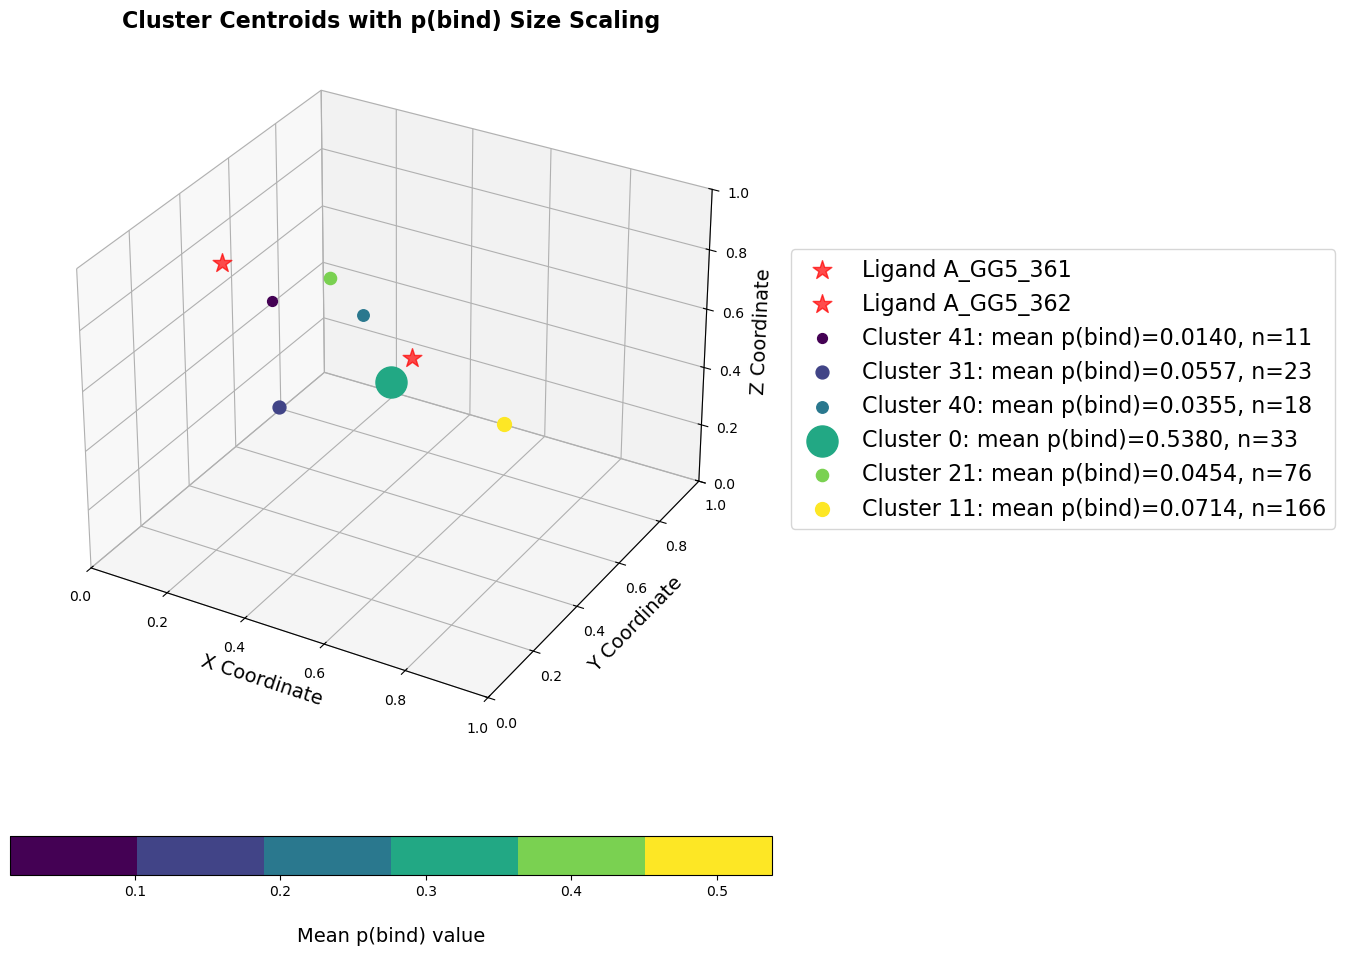

In [67]:
scaler = MinMaxScaler()
scalers = {
    'center_of_mass_x': scaler.fit(df_3hvc[['center_of_mass_x']]),
    'center_of_mass_y': scaler.fit(df_3hvc[['center_of_mass_y']]),
    'center_of_mass_z': scaler.fit(df_3hvc[['center_of_mass_z']])
}

ligand_centers_3hvc_normalized = {
    lig_id: [
        scalers['center_of_mass_x'].transform(np.array([[x]]))[0][0],
        scalers['center_of_mass_y'].transform(np.array([[y]]))[0][0],
        scalers['center_of_mass_z'].transform(np.array([[z]]))[0][0]
    ]
    for lig_id, (x, y, z) in ligand_centers_3hvc.items()
}   

visualize_centroids_pbind_size(df_clustered_3hvc, ligand_centers_3hvc, scalers, pdb_file_3hvc, title="Cluster Centroids with p(bind) Size Scaling")

In [68]:
ligand_centers_3hvc_normalized

{'A_GG5_361': [-0.2090642114453528, 0.8828743021932958, 0.39630129375347256],
 'A_GG5_362': [0.5410217742148848, 0.4793766701060932, 0.6025875069449957]}

In [69]:
ligand_centers_3hvc

{'A_GG5_361': (-3.732, 37.54, 19.149), 'A_GG5_362': (24.619, 22.289, 26.946)}

/opt/miniconda3/envs/protein_pp/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/miniconda3/envs/protein_pp/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/miniconda3/envs/protein_pp/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/miniconda3/envs/protein_pp/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/miniconda3/envs/protein_pp/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler wa

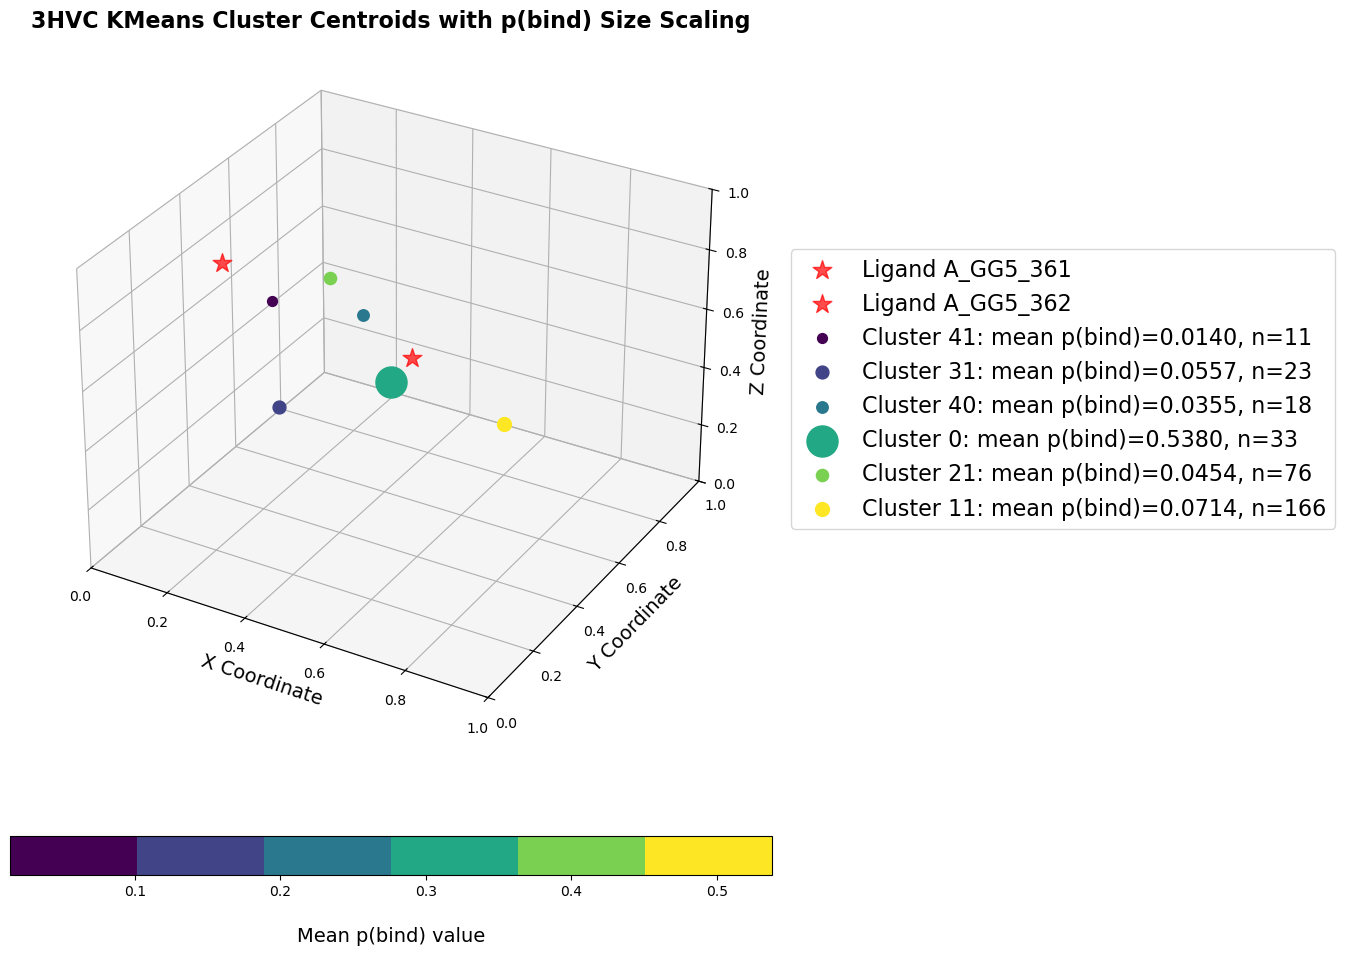

In [51]:
# Visualize residues with p(bind) = size in 3D
ligand_centers = calculate_ligand_centers(pdb_file_3hvc)

# Normalize ligand centers using separate scalers for each dimension
ligand_centers_normalized = {
    lig_id: [
        scalers['center_of_mass_x'].transform(np.array([[x]]))[0][0],
        scalers['center_of_mass_y'].transform(np.array([[y]]))[0][0],
        scalers['center_of_mass_z'].transform(np.array([[z]]))[0][0]
    ]
    for lig_id, (x, y, z) in ligand_centers.items()
}
visualize_centroids_pbind_size(df_clustered_3hvc, ligand_centers, scalers, pdb_file_3hvc, title="3HVC KMeans Cluster Centroids with p(bind) Size Scaling")

In [74]:
def nodistance_cluster_ligand(df_clustered, ligand_centers):
    """
    Calculate distances between cluster centroids and ligand centers.

    Args:
        df_clustered (pd.DataFrame): DataFrame containing clustering results.
        ligand_centers (dict): Dictionary of ligand centers (raw coordinates).

    Returns:
        dict: Dictionary of cluster distances to the closest ligand.
        float: Smallest (best) distance.
    """
    if 'final_cluster' not in df_clustered.columns:
        raise ValueError("❌ DataFrame must contain 'final_cluster' column.")

    cluster_means = df_clustered.groupby('final_cluster')['p(bind)'].mean()
    high_pbind_clusters = cluster_means[cluster_means > 0.2].index.tolist()

    if not high_pbind_clusters:
        print("⚠️ No clusters with mean p(bind) > 0.2. Using all clusters.")
        high_pbind_clusters = df_clustered['final_cluster'].unique()

    distances = {}
    for cluster in high_pbind_clusters:
        cluster_data = df_clustered[df_clustered['final_cluster'] == cluster]

        # Ensure cluster is not empty
        if cluster_data.empty:
            print(f"⚠️ Skipping empty cluster {cluster}")
            continue  

        # Compute centroid
        centroid = cluster_data[['center_of_mass_x', 'center_of_mass_y', 'center_of_mass_z']].mean().values

        # Handle NaN cases
        if np.isnan(centroid).any():
            print(f"⚠️ Skipping cluster {cluster} due to NaN centroid")
            continue  

        min_distance = float('inf')
        closest_ligand = None
        for ligand_id, center in ligand_centers.items():
            distance = np.linalg.norm(centroid - np.array(center))
            if distance < min_distance:
                min_distance = distance
                closest_ligand = ligand_id
        
        distances[cluster] = min_distance
        print(f"✅ Cluster {cluster} closest to Ligand {closest_ligand}: {min_distance:.2f} Å")

    best_distance = round(min(distances.values()), 2) if distances else float('inf')

    print(f"\n🏆 Best Distance: {best_distance} Å")
    return distances, best_distance

def nogrid_search_hierarchical_clustering(df, ligand_centers, pdb_file):
    """
    Performs grid search over different clustering parameters.
    
    Returns:
        result_df (pd.DataFrame): DataFrame containing clustering results.
        best_param (dict): Dictionary of best parameters.
    """
    best_distance = float('inf')
    best_param = None
    best_result_df = None

    for method in ['kmeans', 'spectral', 'gmm']:
        for pbind_weight in [1, 2, 5]:
            for threshold in [0.2, 0.3, 0.4]:
                print(f"Testing: method={method}, pbind_weight={pbind_weight}, threshold={threshold}")

                # Run hierarchical clustering
                clustered_df, _ = hierarchical_clustering_pipeline(
                    df, clustering_method=method, pbind_weight=pbind_weight, threshold=threshold
                )

                # Compute distance
                distances, min_distance = distance_cluster_ligand(clustered_df, ligand_centers)

                # Update best parameters if we find a lower distance
                if min_distance < best_distance:
                    best_distance = min_distance
                    best_param = {
                        "clustering_method": method,
                        "pbind_weight": pbind_weight,
                        "threshold": threshold,
                        "best_distance": best_distance
                    }
                    best_result_df = clustered_df.copy()

    if best_param is None:
        raise ValueError("❌ No valid clustering found. Check input parameters.")

    return best_result_df, best_param  # ✅ Now correctly returning only 2 values

In [80]:
df

chain  resi resn   p(bind)  \
6619     A     1    I  0.068491   
6620     A     2    D  0.032438   
6621     A     3    C  0.019638   
6622     A     4    G  0.003933   
6623     A     5    H  0.005678   
...    ...   ...  ...       ...   
6704     A    86    D  0.130388   
6705     A    87    C  0.095212   
6706     A    88    S  0.046281   
6707     A    89    R  0.210910   
6708     A    90    V  0.718558   

                                       resn_coordinates  center_of_mass_x  \
6619  [('N', 9.901, -5.858, -2.276), ('C', 10.365, -...             1.535   
6620  [('N', 11.711, -4.45, -5.166), ('C', 12.294, -...             3.268   
6621  [('N', 10.232, -1.776, -5.397), ('C', 9.34, -0...             1.966   
6622  [('N', 8.395, -2.068, -7.707), ('C', 8.009, -2...             0.712   
6623  [('N', 6.833, -4.467, -8.828), ('C', 5.604, -5...            -0.125   
...                                                 ...               ...   
6704  [('N', 3.473, 6.478, 9.049), ('C', 4.935, 6.58...             2.620   
6705  [('N', 6.871, 5.94, 7.665), ('C', 7.621, 5.066...             3.000   
6706  [('N', 7.751, 3.398, 8.605), ('C', 7.928, 2.03...             3.244   
6707  [('N', 10.365, 2.184, 8.919), ('C', 11.678, 1....             4.565   
6708  [('N', 11.436, -0.643, 9.141), ('C', 11.849, -...             4.144   

      center_of_mass_y  center_of_mass_z PDBcode  \
6619            -3.070             0.751    1cz2   
6620            -2.305            -1.242    1cz2   
6621            -0.330            -1.727    1cz2   
6622            -1.918            -1.016    1cz2   
6623            -3.820             0.123    1cz2   
...                ...               ...     ...   
6704             3.406            -0.931    1cz2   
6705             2.307            -0.916    1cz2   
6706             1.611             0.049    1cz2   
6707             1.580            -0.008    1cz2   
6708            -0.389             1.483    1cz2   

      center_of_mass_x_standardized  center_of_mass_y_normalized  \
6619                       0.698613                     0.176481   
6620                       1.426340                     0.246762   
6621                       0.879600                     0.428204   
6622                       0.353016                     0.282315   
6623                       0.001540                     0.107579   
...                             ...                          ...   
6704                       1.154230                     0.771429   
6705                       1.313801                     0.670464   
6706                       1.416262                     0.606523   
6707                       1.970981                     0.603675   
6708                       1.794193                     0.422784   

      center_of_mass_z_standardized  p(bind)_weight_1  p(bind)_weight_5  \
6619                       0.380342          0.067613          0.338067   
6620                      -0.601015          0.030064          0.150320   
6621                      -0.839830          0.016732          0.083661   
6622                      -0.489732          0.000375          0.001875   
6623                       0.071114          0.002192          0.010961   
...                             ...               ...               ...   
6704                      -0.447878          0.132080          0.660402   
6705                      -0.440492          0.095444          0.477222   
6706                       0.034676          0.044481          0.222407   
6707                       0.006609          0.215945          1.079727   
6708                       0.740781          0.744672          3.723359   

      p(bind)_weight_10  p(bind)_weight_100  protein_x  protein_y  protein_z  \
6619           0.676133            6.761331      0.031     -0.003      0.017   
6620           0.300639            3.006393      0.031     -0.003      0.017   
6621           0.167322            1.673224      0.031     -0.003      0.017

In [79]:
from itertools import product

# Initialize DataFrame to store best parameters for each PDB file
best_params_df = pd.DataFrame(columns=["pdb_code", "clustering_method", "n_clusters", "pbind_weight", "threshold", "best_distance"])

# Iterate over all PDB files in dfs
for pdb_code, df in dfs.items():
    pdb_file = f"{data_path}/{pdb_code}.pdb"
    ligand_centers = calculate_ligand_centers(pdb_file)

    print(f"\n🔍 Running Grid Search for {pdb_code}...")
    
    # Run grid search to find the best parameters
    result_df, best_param = grid_search_hierarchical_clustering(df, ligand_centers, pdb_file)
    
    # best_param is already a dictionary of the best parameters
    
    # Store results in DataFrame
    best_params_df = pd.concat([best_params_df, pd.DataFrame([{
        "pdb_code": pdb_code,
        "clustering_method": best_param["clustering_method"],
        "n_clusters": best_param["n_clusters"],
        "pbind_weight": best_param["pbind_weight"],
        "threshold": best_param["threshold"],
        "best_distance": best_param["best_distance"]
    }])], ignore_index=True)

# Save best parameters to a CSV file
best_params_df.to_csv("best_params.csv", index=False)

print("\n✅ Grid Search Completed for all PDB files. Results saved to 'best_params.csv'.")

best_params_df



🔍 Running Grid Search for 1ao6...

🔍 Testing: kmeans | Clusters: 2 | Weight: 1 | Threshold: 0.01
Initial Clusters' Mean p(bind): 
cluster_iteration_0
0    0.113521
1    0.105275
Name: p(bind), dtype: float64

Initial kmeans clustering results:
Cluster counts: 
cluster_iteration_0
0    579
1    577
Name: count, dtype: int64


🔄 Iteration 1: Re-clustering cluster 1
Iteration 1 Clusters' Mean p(bind): 
cluster_iteration_1
0    0.062734
1    0.154325
Name: p(bind), dtype: float64
Selected cluster 0 for next iteration with mean p(bind): 0.062734
Remaining points: 309

🔄 Iteration 2: Re-clustering cluster 0
Iteration 2 Clusters' Mean p(bind): 
cluster_iteration_2
0    0.071889
1    0.046402
Name: p(bind), dtype: float64
Selected cluster 1 for next iteration with mean p(bind): 0.046402
Remaining points: 111

🔄 Iteration 3: Re-clustering cluster 1
Iteration 3 Clusters' Mean p(bind): 
cluster_iteration_3
0    0.052489
1    0.025463
Name: p(bind), dtype: float64
Selected cluster 1 for next iter

/var/folders/v4/rd2_123918b6cj4v96gtlmkh0000gn/T/ipykernel_55345/1838850513.py:19: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  best_params_df = pd.concat([best_params_df, pd.DataFrame([{


Iteration 4 Clusters' Mean p(bind): 
cluster_iteration_4
0    0.015228
1    0.017664
Name: p(bind), dtype: float64
Selected cluster 0 for next iteration with mean p(bind): 0.015228
Remaining points: 4

🔄 Iteration 5: Re-clustering cluster 0
Iteration 5 Clusters' Mean p(bind): 
cluster_iteration_5
0    0.013000
1    0.017455
Name: p(bind), dtype: float64
Selected cluster 0 for next iteration with mean p(bind): 0.013000
Remaining points: 2

Final clustering summary:
               Mean p(bind)  Count
final_cluster                     
0                  0.166537     71
10                 0.044015     20
21                 0.050964     15
30                 0.056343      7
41                 0.017664      3
50                 0.013000      2
51                 0.017455      2

🔍 Calculating cluster-to-ligand distances... {}

🎯 High-binding Clusters: []
⚠️ No clusters with mean p(bind) > 0.2, distance of low pbind cluster = inf.

🔍 Testing: kmeans | Clusters: 2 | Weight: 1 | Threshold: 0.0

KeyError: 'best_distance'

In [81]:
from itertools import product

# Initialize DataFrame to store best parameters for each PDB file
best_params_df = pd.DataFrame(columns=["pdb_code", "clustering_method", "n_clusters", "pbind_weight", "threshold", "best_distance"])

# Debugging: Print available PDB codes
print(f"Available PDB Codes: {list(dfs.keys())}")

# Iterate over all PDB files in dfs
for pdb_code, df in dfs.items():
    pdb_file = f"{data_path}/{pdb_code}.pdb"
    
    # Calculate ligand centers
    ligand_centers = calculate_ligand_centers(pdb_file)
    if not ligand_centers:
        print(f"⚠️ No ligand centers found for {pdb_code}. Skipping...")
        continue  # Skip this file if no ligands are found
    
    print(f"\n🔍 Running Grid Search for {pdb_code}...")
    
    try:
        # Run grid search to find the best parameters
        result_df, best_param = grid_search_hierarchical_clustering(df, ligand_centers, pdb_file)
        
        # Validate `best_param`
        if not isinstance(best_param, dict):
            raise ValueError(f"⚠️ Unexpected return type from grid_search_hierarchical_clustering for {pdb_code}")
    
    except Exception as e:
        print(f"❌ Error running grid search for {pdb_code}: {e}")
        continue  # Skip to the next PDB file

    # Store results in DataFrame
    best_params_df = pd.concat([best_params_df, pd.DataFrame([{
        "pdb_code": pdb_code,
        "clustering_method": best_param.get("clustering_method", "Unknown"),
        "n_clusters": best_param.get("n_clusters", 2),
        "pbind_weight": best_param.get("pbind_weight", 1),
        "threshold": best_param.get("threshold", 0.1),
        "best_distance": best_param.get("best_distance", float('inf'))
    }])], ignore_index=True)

# Save best parameters to a CSV file
best_params_df.to_csv("best_params.csv", index=False)

print("\n✅ Grid Search Completed for all PDB files. Results saved to 'best_params.csv'.")

Available PDB Codes: ['1ao6', '1be9', '1cz2', '1ema', '1h61', '1hvy', '1kv1', '1lyz', '1ny3', '1pw6', '1qcf', '1ubq', '1yer', '2bal', '3cpa', '3g5d', '3hvc', '3ptb', '3qkd', '3zln', '4f9w', '4pti', '6o0k']
⚠️ No ligand centers found for 1ao6. Skipping...
⚠️ No ligand centers found for 1be9. Skipping...

🔍 Running Grid Search for 1cz2...

🔍 Testing: kmeans | Clusters: 2 | Weight: 1 | Threshold: 0.01
⚠️ Error with params (kmeans, 2, 1, 0.01): "['center_of_mass_x_normalized', 'center_of_mass_z_normalized'] not in index"

🔍 Testing: kmeans | Clusters: 2 | Weight: 1 | Threshold: 0.02
⚠️ Error with params (kmeans, 2, 1, 0.02): "['center_of_mass_x_normalized', 'center_of_mass_z_normalized'] not in index"

🔍 Testing: kmeans | Clusters: 2 | Weight: 1 | Threshold: 0.03
⚠️ Error with params (kmeans, 2, 1, 0.03): "['center_of_mass_x_normalized', 'center_of_mass_z_normalized'] not in index"

🔍 Testing: kmeans | Clusters: 2 | Weight: 2 | Threshold: 0.01
⚠️ Error with params (kmeans, 2, 2, 0.01): "['

/var/folders/v4/rd2_123918b6cj4v96gtlmkh0000gn/T/ipykernel_55345/1733149162.py:34: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  best_params_df = pd.concat([best_params_df, pd.DataFrame([{



🔍 Running Grid Search for 1hvy...

🔍 Testing: kmeans | Clusters: 2 | Weight: 1 | Threshold: 0.01
Initial Clusters' Mean p(bind): 
cluster_iteration_0
0    0.137832
1    0.134323
Name: p(bind), dtype: float64

Initial kmeans clustering results:
Cluster counts: 
cluster_iteration_0
0    576
1    576
Name: count, dtype: int64


🔄 Iteration 1: Re-clustering cluster 1
Iteration 1 Clusters' Mean p(bind): 
cluster_iteration_1
0    0.047120
1    0.699449
Name: p(bind), dtype: float64
Selected cluster 0 for next iteration with mean p(bind): 0.047120
Remaining points: 499

🔄 Iteration 2: Re-clustering cluster 0
Iteration 2 Clusters' Mean p(bind): 
cluster_iteration_2
0    0.046009
1    0.048208
Name: p(bind), dtype: float64
Selected cluster 0 for next iteration with mean p(bind): 0.046009
Remaining points: 247

🔄 Iteration 3: Re-clustering cluster 0
Iteration 3 Clusters' Mean p(bind): 
cluster_iteration_3
0    0.055305
1    0.038421
Name: p(bind), dtype: float64
Selected cluster 1 for next iter

/opt/miniconda3/envs/protein_pp/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(



🔍 Calculating cluster-to-ligand distances... {'A_UMP_314': (-0.157, 3.884, 15.29), 'A_D16_414': (0.396, 12.556, 17.778), 'A_BME_1514': (16.05, 2.941, -5.002), 'B_UMP_315': (7.157, -6.568, -12.476), 'B_D16_415': (3.706, -14.241, -16.273), 'B_BME_1515': (3.884, -9.798, 12.903), 'C_UMP_316': (35.591, 41.738, 39.158), 'C_D16_416': (30.523, 34.872, 41.903), 'C_BME_1516': (50.843, 30.447, 21.906), 'D_UMP_317': (62.852, 38.862, 25.613), 'D_D16_417': (69.298, 45.348, 25.408), 'D_BME_1517': (40.997, 51.607, 29.982)}

🎯 High-binding Clusters: [10]
✅ Cluster 10 closest to Ligand C_BME_1516: 14.56 Å

🏆 Best Distance: 14.56 Å

🔍 Testing: spectral | Clusters: 2 | Weight: 1 | Threshold: 0.02
Initial Clusters' Mean p(bind): 
cluster_iteration_0
0    0.134323
1    0.137832
Name: p(bind), dtype: float64

Initial spectral clustering results:
Cluster counts: 
cluster_iteration_0
1    576
0    576
Name: count, dtype: int64


🔄 Iteration 1: Re-clustering cluster 0
Iteration 1 Clusters' Mean p(bind): 
clust

/opt/miniconda3/envs/protein_pp/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(



🔍 Calculating cluster-to-ligand distances... {'A_UMP_314': (-0.157, 3.884, 15.29), 'A_D16_414': (0.396, 12.556, 17.778), 'A_BME_1514': (16.05, 2.941, -5.002), 'B_UMP_315': (7.157, -6.568, -12.476), 'B_D16_415': (3.706, -14.241, -16.273), 'B_BME_1515': (3.884, -9.798, 12.903), 'C_UMP_316': (35.591, 41.738, 39.158), 'C_D16_416': (30.523, 34.872, 41.903), 'C_BME_1516': (50.843, 30.447, 21.906), 'D_UMP_317': (62.852, 38.862, 25.613), 'D_D16_417': (69.298, 45.348, 25.408), 'D_BME_1517': (40.997, 51.607, 29.982)}

🎯 High-binding Clusters: [10]
✅ Cluster 10 closest to Ligand C_BME_1516: 14.56 Å

🏆 Best Distance: 14.56 Å

🔍 Testing: spectral | Clusters: 2 | Weight: 1 | Threshold: 0.03
Initial Clusters' Mean p(bind): 
cluster_iteration_0
0    0.134323
1    0.137832
Name: p(bind), dtype: float64

Initial spectral clustering results:
Cluster counts: 
cluster_iteration_0
1    576
0    576
Name: count, dtype: int64


🔄 Iteration 1: Re-clustering cluster 0
Iteration 1 Clusters' Mean p(bind): 
clust

/opt/miniconda3/envs/protein_pp/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(



🔍 Calculating cluster-to-ligand distances... {'A_UMP_314': (-0.157, 3.884, 15.29), 'A_D16_414': (0.396, 12.556, 17.778), 'A_BME_1514': (16.05, 2.941, -5.002), 'B_UMP_315': (7.157, -6.568, -12.476), 'B_D16_415': (3.706, -14.241, -16.273), 'B_BME_1515': (3.884, -9.798, 12.903), 'C_UMP_316': (35.591, 41.738, 39.158), 'C_D16_416': (30.523, 34.872, 41.903), 'C_BME_1516': (50.843, 30.447, 21.906), 'D_UMP_317': (62.852, 38.862, 25.613), 'D_D16_417': (69.298, 45.348, 25.408), 'D_BME_1517': (40.997, 51.607, 29.982)}

🎯 High-binding Clusters: [10]
✅ Cluster 10 closest to Ligand C_BME_1516: 14.56 Å

🏆 Best Distance: 14.56 Å

🔍 Testing: spectral | Clusters: 2 | Weight: 2 | Threshold: 0.01
Initial Clusters' Mean p(bind): 
cluster_iteration_0
0    0.134323
1    0.137832
Name: p(bind), dtype: float64

Initial spectral clustering results:
Cluster counts: 
cluster_iteration_0
1    576
0    576
Name: count, dtype: int64


🔄 Iteration 1: Re-clustering cluster 0
Iteration 1 Clusters' Mean p(bind): 
clust

/opt/miniconda3/envs/protein_pp/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Initial Clusters' Mean p(bind): 
cluster_iteration_0
0    0.127145
1    0.984669
Name: p(bind), dtype: float64

Initial spectral clustering results:
Cluster counts: 
cluster_iteration_0
0    1140
1      12
Name: count, dtype: int64


🔄 Iteration 1: Re-clustering cluster 0
Iteration 1 Clusters' Mean p(bind): 
cluster_iteration_1
0    0.564298
1    0.031868
Name: p(bind), dtype: float64
Selected cluster 1 for next iteration with mean p(bind): 0.031868
Remaining points: 936

🔄 Iteration 2: Re-clustering cluster 1
Iteration 2 Clusters' Mean p(bind): 
cluster_iteration_2
0    0.012813
1    0.127881
Name: p(bind), dtype: float64
Selected cluster 0 for next iteration with mean p(bind): 0.012813
Remaining points: 781

🔄 Iteration 3: Re-clustering cluster 0
Iteration 3 Clusters' Mean p(bind): 
cluster_iteration_3
0    0.012800
1    0.012827
Name: p(bind), dtype: float64
Selected cluster 0 for next iteration with mean p(bind): 0.012800
Remaining points: 392

🔄 Iteration 4: Re-clustering cluster 

/opt/miniconda3/envs/protein_pp/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Initial Clusters' Mean p(bind): 
cluster_iteration_0
0    0.127145
1    0.984669
Name: p(bind), dtype: float64

Initial spectral clustering results:
Cluster counts: 
cluster_iteration_0
0    1140
1      12
Name: count, dtype: int64


🔄 Iteration 1: Re-clustering cluster 0
Iteration 1 Clusters' Mean p(bind): 
cluster_iteration_1
0    0.564298
1    0.031868
Name: p(bind), dtype: float64
Selected cluster 1 for next iteration with mean p(bind): 0.031868
Remaining points: 936

🔄 Iteration 2: Re-clustering cluster 1
Iteration 2 Clusters' Mean p(bind): 
cluster_iteration_2
0    0.012813
1    0.127881
Name: p(bind), dtype: float64
Selected cluster 0 for next iteration with mean p(bind): 0.012813
Remaining points: 781

Final clustering summary:
               Mean p(bind)  Count
final_cluster                     
1                  0.984669     12
10                 0.564298    204
20                 0.012813    781
21                 0.127881    155

🔍 Calculating cluster-to-ligand distances..

/opt/miniconda3/envs/protein_pp/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Initial Clusters' Mean p(bind): 
cluster_iteration_0
0    0.127145
1    0.984669
Name: p(bind), dtype: float64

Initial spectral clustering results:
Cluster counts: 
cluster_iteration_0
0    1140
1      12
Name: count, dtype: int64


🔄 Iteration 1: Re-clustering cluster 0
Iteration 1 Clusters' Mean p(bind): 
cluster_iteration_1
0    0.564298
1    0.031868
Name: p(bind), dtype: float64
Selected cluster 1 for next iteration with mean p(bind): 0.031868
Remaining points: 936

🔄 Iteration 2: Re-clustering cluster 1
Iteration 2 Clusters' Mean p(bind): 
cluster_iteration_2
0    0.012813
1    0.127881
Name: p(bind), dtype: float64
Selected cluster 0 for next iteration with mean p(bind): 0.012813
Remaining points: 781

Final clustering summary:
               Mean p(bind)  Count
final_cluster                     
1                  0.984669     12
10                 0.564298    204
20                 0.012813    781
21                 0.127881    155

🔍 Calculating cluster-to-ligand distances..

/opt/miniconda3/envs/protein_pp/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Initial Clusters' Mean p(bind): 
cluster_iteration_0
0    0.127145
1    0.984669
Name: p(bind), dtype: float64

Initial spectral clustering results:
Cluster counts: 
cluster_iteration_0
0    1140
1      12
Name: count, dtype: int64


🔄 Iteration 1: Re-clustering cluster 0
Iteration 1 Clusters' Mean p(bind): 
cluster_iteration_1
0    0.529557
1    0.027643
Name: p(bind), dtype: float64
Selected cluster 1 for next iteration with mean p(bind): 0.027643
Remaining points: 914

🔄 Iteration 2: Re-clustering cluster 1
Iteration 2 Clusters' Mean p(bind): 
cluster_iteration_2
0    0.010907
1    0.103058
Name: p(bind), dtype: float64
Selected cluster 0 for next iteration with mean p(bind): 0.010907
Remaining points: 748

🔄 Iteration 3: Re-clustering cluster 0
Iteration 3 Clusters' Mean p(bind): 
cluster_iteration_3
0    0.005799
1    0.028676
Name: p(bind), dtype: float64
Selected cluster 0 for next iteration with mean p(bind): 0.005799
Remaining points: 581

Final clustering summary:
           

/opt/miniconda3/envs/protein_pp/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Initial Clusters' Mean p(bind): 
cluster_iteration_0
0    0.127145
1    0.984669
Name: p(bind), dtype: float64

Initial spectral clustering results:
Cluster counts: 
cluster_iteration_0
0    1140
1      12
Name: count, dtype: int64


🔄 Iteration 1: Re-clustering cluster 0
Iteration 1 Clusters' Mean p(bind): 
cluster_iteration_1
0    0.529557
1    0.027643
Name: p(bind), dtype: float64
Selected cluster 1 for next iteration with mean p(bind): 0.027643
Remaining points: 914

🔄 Iteration 2: Re-clustering cluster 1
Iteration 2 Clusters' Mean p(bind): 
cluster_iteration_2
0    0.010907
1    0.103058
Name: p(bind), dtype: float64
Selected cluster 0 for next iteration with mean p(bind): 0.010907
Remaining points: 748

Final clustering summary:
               Mean p(bind)  Count
final_cluster                     
1                  0.984669     12
10                 0.529557    226
20                 0.010907    748
21                 0.103058    166

🔍 Calculating cluster-to-ligand distances..

/opt/miniconda3/envs/protein_pp/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Initial Clusters' Mean p(bind): 
cluster_iteration_0
0    0.127145
1    0.984669
Name: p(bind), dtype: float64

Initial spectral clustering results:
Cluster counts: 
cluster_iteration_0
0    1140
1      12
Name: count, dtype: int64


🔄 Iteration 1: Re-clustering cluster 0
Iteration 1 Clusters' Mean p(bind): 
cluster_iteration_1
0    0.529557
1    0.027643
Name: p(bind), dtype: float64
Selected cluster 1 for next iteration with mean p(bind): 0.027643
Remaining points: 914

Final clustering summary:
               Mean p(bind)  Count
final_cluster                     
1                  0.984669     12
10                 0.529557    226
11                 0.027643    914

🔍 Calculating cluster-to-ligand distances... {'A_UMP_314': (-0.157, 3.884, 15.29), 'A_D16_414': (0.396, 12.556, 17.778), 'A_BME_1514': (16.05, 2.941, -5.002), 'B_UMP_315': (7.157, -6.568, -12.476), 'B_D16_415': (3.706, -14.241, -16.273), 'B_BME_1515': (3.884, -9.798, 12.903), 'C_UMP_316': (35.591, 41.738, 39.158), 'C_D1

/opt/miniconda3/envs/protein_pp/lib/python3.11/site-packages/sklearn/cluster/_spectral.py:703: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


Selected cluster 1 for next iteration with mean p(bind): 0.025386
Remaining points: 110

🔄 Iteration 2: Re-clustering cluster 1
Iteration 2 Clusters' Mean p(bind): 
cluster_iteration_2
0    0.027825
1    0.023698
Name: p(bind), dtype: float64
Selected cluster 1 for next iteration with mean p(bind): 0.023698
Remaining points: 65

🔄 Iteration 3: Re-clustering cluster 1
Iteration 3 Clusters' Mean p(bind): 
cluster_iteration_3
0    0.026161
1    0.021834
Name: p(bind), dtype: float64
Selected cluster 1 for next iteration with mean p(bind): 0.021834
Remaining points: 37

🔄 Iteration 4: Re-clustering cluster 1
Iteration 4 Clusters' Mean p(bind): 
cluster_iteration_4
0    0.026950
1    0.014332
Name: p(bind), dtype: float64
Selected cluster 1 for next iteration with mean p(bind): 0.014332
Remaining points: 15

Final clustering summary:
               Mean p(bind)  Count
final_cluster                     
1                  0.705827     28
10                 0.077258    193
20                 

/opt/miniconda3/envs/protein_pp/lib/python3.11/site-packages/sklearn/cluster/_spectral.py:703: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


Iteration 2 Clusters' Mean p(bind): 
cluster_iteration_2
0    0.087785
1    0.020371
Name: p(bind), dtype: float64
Selected cluster 1 for next iteration with mean p(bind): 0.020371
Remaining points: 26

Final clustering summary:
               Mean p(bind)  Count
final_cluster                     
0                  0.159959    123
11                 0.362112     25
20                 0.087785     76
21                 0.020371     26

🔍 Calculating cluster-to-ligand distances... {'A_FRB_201': (89.178, 23.244, 15.193), 'B_FRB_301': (88.101, 21.582, 4.864)}

🎯 High-binding Clusters: [11]
✅ Cluster 11 closest to Ligand B_FRB_301: 11.56 Å

🏆 Best Distance: 11.56 Å

🔍 Testing: spectral | Clusters: 2 | Weight: 3 | Threshold: 0.01
Initial Clusters' Mean p(bind): 
cluster_iteration_0
0    0.187215
1    0.083647
Name: p(bind), dtype: float64

Initial spectral clustering results:
Cluster counts: 
cluster_iteration_0
0    145
1    105
Name: count, dtype: int64


🔄 Iteration 1: Re-clustering clus

In [16]:
feature_columns = ['center_of_mass_x', 'center_of_mass_y', 'center_of_mass_z']
pbind_column = 'p(bind)'
pbind_weights = [1, 5, 10, 100]

df_processed, scalers = preprocess_features(df, feature_columns, pbind_column, pbind_weights)
df_processed.head()

chain  resi resn   p(bind)  \
8133     A     5    S  0.008225   
8134     A     6    E  0.013932   
8135     A     7    V  0.044013   
8136     A     8    A  0.005330   
8137     A     9    H  0.007117   

                                       resn_coordinates  center_of_mass_x  \
8133  [('N', 56.653, 51.017, 34.141), ('C', 56.672, ...            56.842   
8134  [('N', 54.513, 49.256, 32.336), ('C', 53.399, ...            52.042   
8135  [('N', 54.398, 47.06, 30.567), ('C', 54.785, 4...            55.496   
8136  [('N', 56.576, 45.684, 31.451), ('C', 57.619, ...            57.393   
8137  [('N', 55.959, 45.021, 34.015), ('C', 55.239, ...            53.670   

      center_of_mass_y  center_of_mass_z PDBcode  center_of_mass_x_normalized  \
8133            49.491            33.021    1ao6                     0.878999   
8134            47.843            32.726    1ao6                     0.818612   
8135            45.623            29.468    1ao6                     0.862065   
8136            44.835            32.769    1ao6                     0.885931   
8137            44.278            36.142    1ao6                     0.839093   

      ...  p(bind)_weight_5  p(bind)_weight_10  p(bind)_weight_100  protein_x  \
8133  ...          0.038863           0.077726            0.777258     28.415   
8134  ...          0.068981           0.137962            1.379621     28.415   
8135  ...          0.227710           0.455420            4.554202     28.415   
8136  ...          0.023586           0.047172            0.471717     28.415   
8137  ...          0.033020           0.066040            0.660397     28.415   

      protein_y  protein_z  protein_diameter  center_of_mass_x_scaled  \
8133      8.385      23.27           115.953                 0.878999   
8134      8.385      23.27           115.953                 0.818612   
8135      8.385      23.27           115.953                 0.862065   
8136      8.385      23.27           115.953                 0.885931   
8137      8.385      23.27           115.953                 0.839093   

      center_of_mass_y_scaled  center_of_mass_z_scaled  
8133                 0.908296                 0.649454  
8134                 0.892317                 0.645464  
8135                 0.870792                 0.601399  
8136                 0.863152                 0.646045  
8137                 0.857751                 0.691666  

[5 rows x 23 columns]

In [ ]:
# Clustering Functions

### 1️⃣ Determine Optimal Clusters number

def silhouette_analysis(data, max_clusters=10):
    """
    Perform silhouette analysis for a range of clusters and suggest the optimal n_clusters.

    Args:
        data (array-like): Dataset to cluster.
        max_clusters (int): Maximum number of clusters to evaluate.

    Returns:
        tuple: Suggested n_clusters, silhouette scores for each k.
    """
    silhouette_scores = []
    
    for n_clusters in range(2, max_clusters + 1):  # Silhouette starts from k=2
        kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
        labels = kmeans.fit_predict(data)
        silhouette_scores.append(silhouette_score(data, labels))

    suggested_k = np.argmax(silhouette_scores) + 2  # +2 because we start at k=2
    print(f"Suggested number of clusters (Silhouette): {suggested_k}")
    print("Silhouette Scores:", silhouette_scores)
    
    return suggested_k, silhouette_scores


def eigengap_heuristic(data, max_clusters=10):
    """
    Determines the optimal number of clusters for Spectral Clustering using the Eigengap heuristic.

    Args:
        data (array-like): Dataset for clustering.
        max_clusters (int): Maximum number of clusters to evaluate.

    Returns:
        int: Suggested number of clusters.
        list: Eigenvalues for visualization.
    """
    # Construct affinity matrix using nearest neighbors graph
    adjacency_matrix = kneighbors_graph(data, n_neighbors=10, mode='connectivity', include_self=True).toarray()
    
    # Compute Laplacian matrix
    laplacian_matrix = laplacian(adjacency_matrix, normed=True)

    # Compute eigenvalues
    eigenvalues, _ = eigh(laplacian_matrix)
    
    # Compute eigengap (difference between consecutive eigenvalues)
    eigengaps = np.diff(eigenvalues[:max_clusters])  # Only first max_clusters eigenvalues
    
    # Find the optimal number of clusters (index of the largest eigengap)
    optimal_k = np.argmax(eigengaps) + 1  # +1 because indexing starts at 0
    
    print(f"Optimal number of clusters (Eigengap): {optimal_k}")
    print("Eigengaps:", eigengaps)
    
    return optimal_k, eigenvalues[:max_clusters]

### 2️⃣ Clustering Functions

def kmeans_clustering(df, feature_columns, n_clusters):
    """
    Perform KMeans clustering and add cluster labels to the DataFrame.

    Args:
        df (pd.DataFrame): Input DataFrame.
        feature_columns (list): List of feature column names.
        n_clusters (int): Number of clusters.

    Returns:
        pd.DataFrame: Updated DataFrame with cluster labels.
        KMeans: Fitted KMeans model.
    """
    features = df[feature_columns].values
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    df['kmeans_cluster'] = kmeans.fit_predict(features)
    return df, kmeans


def spectral_clustering(df, feature_columns, n_clusters):
    """
    Perform Spectral clustering and add cluster labels to the DataFrame.

    Args:
        df (pd.DataFrame): Input DataFrame.
        feature_columns (list): List of feature column names.
        n_clusters (int): Number of clusters.

    Returns:
        pd.DataFrame: Updated DataFrame with cluster labels.
        SpectralClustering: Fitted SpectralClustering model.
    """
    features = df[feature_columns].values
    spectral = SpectralClustering(n_clusters=n_clusters, random_state=42, assign_labels='kmeans')
    df['spectral_cluster'] = spectral.fit_predict(features)
    return df, spectral


def gmm_clustering(df, feature_columns, weight_column='p(bind)', max_clusters=10):
    """
    Perform Gaussian Mixture Model (GMM) clustering with automatic cluster selection using BIC.

    Args:
        df (pd.DataFrame): The DataFrame containing data to cluster.
        feature_columns (list): List of spatial features for clustering.
        weight_column (str): The column containing binding probabilities (default: 'p(bind)').
        max_clusters (int): Maximum number of clusters to evaluate.

    Returns:
        pd.DataFrame: The original DataFrame with an additional column 'gmm_cluster'.
        int: The selected optimal number of clusters.
    """
    coordinates = df[feature_columns].values
    weights = df[[weight_column]].values.reshape(-1, 1)

    # Normalize weights
    scaler = MinMaxScaler()
    normalized_weights = scaler.fit_transform(weights).flatten()

    # Combine normalized weights with spatial coordinates
    augmented_data = np.hstack((coordinates, normalized_weights.reshape(-1, 1)))

    # Determine optimal number of clusters using BIC
    bic_scores = []
    n_components_range = range(1, min(len(augmented_data), max_clusters) + 1)  

    for n in n_components_range:
        gmm = GaussianMixture(n_components=n, random_state=42)
        gmm.fit(augmented_data)
        bic_scores.append(gmm.bic(augmented_data))

    optimal_clusters = n_components_range[np.argmin(bic_scores)]
    print(f"Optimal number of clusters (BIC): {optimal_clusters}")

    # Perform GMM clustering
    gmm = GaussianMixture(n_components=optimal_clusters, random_state=42)
    df['gmm_cluster'] = gmm.fit_predict(augmented_data)

    return df, optimal_clusters


def find_best_cluster(idx, remaining_points, dist_matrix, max_diameter):
    """
    Finds the best possible cluster centered around a given index point.
    
    Args:
        idx (int): Index of the point to form a cluster around.
        remaining_points (set): Indices of available points.
        dist_matrix (np.array): Precomputed pairwise distance matrix.
        max_diameter (float): The maximum allowed cluster diameter.
    
    Returns:
        set: Best cluster formed around the given index.
    """
    candidate_cluster = {idx}
    candidate_remaining = remaining_points - candidate_cluster
    
    while True:
        # Find valid points that can be added to the cluster
        nearest_points = [
            i for i in candidate_remaining 
            if max(dist_matrix[i, list(candidate_cluster)]) <= max_diameter
        ]
        
        if not nearest_points:
            break
        
        # Add the point that maintains the smallest cluster diameter
        best_new_point = min(nearest_points, key=lambda i: max(dist_matrix[i, list(candidate_cluster)]))
        candidate_cluster.add(best_new_point)
        candidate_remaining.remove(best_new_point)
    
    return candidate_cluster

def qt_clustering(df, feature_columns, max_diameter = 22.5, n_jobs=-2):
    """
    Perform Quality Threshold (QT) clustering with parallel processing.

    Args:
        df (pd.DataFrame): Input DataFrame containing feature columns.
        feature_columns (list): List of feature column names.
        max_diameter (float): The maximum allowed diameter for a cluster.
        n_jobs (int): Number of parallel jobs (-1 for all available cores).

    Returns:
        pd.DataFrame: DataFrame with cluster labels.
    """
    points = df[feature_columns].values
    print(f"Number of points: {len(points)}")
    print(points)
    num_points = len(points)
    labels = np.full(num_points, -1)  # Initialize all points as unassigned (-1)

    # Precompute pairwise distances using a distance matrix (faster than calculating repeatedly)
    dist_matrix = distance_matrix(points, points)
    #print(f"Distance matrix shape: {dist_matrix.shape}")
    #print(dist_matrix)

    # Track unassigned points
    remaining_points = set(range(num_points))
    cluster_id = 0  # Cluster counter

    while remaining_points:
        # Run parallel cluster formation for all remaining points
        cluster_candidates = Parallel(n_jobs=n_jobs)(
            delayed(find_best_cluster)(idx, remaining_points, dist_matrix, max_diameter) 
            for idx in remaining_points
        )

        # Select the largest valid cluster
        best_cluster = max(cluster_candidates, key=len)

        # Assign cluster labels to the best cluster found
        for point in best_cluster:
            labels[point] = cluster_id

        cluster_id += 1
        remaining_points -= best_cluster  # Remove clustered points

    df['qt_cluster'] = labels
    return df

### 3️⃣ Feature Normalization
# Filter by p(bind) cutoff# Normalize within clusters
def normalize_within_clusters(df, cluster_column, pbind_column):
    """
    Normalize p(bind) values within each cluster.

    Args:
        df (pd.DataFrame): Input DataFrame.
        cluster_column (str): Column containing cluster IDs.
        pbind_column (str): Column containing p(bind) values.

    Returns:
        pd.DataFrame: Updated DataFrame with normalized p(bind) values.
    """
    df[f"normalized_{pbind_column}"] = df.groupby(cluster_column)[pbind_column].transform(
        lambda x: (x - x.min()) / (x.max() - x.min())
    )
    return df

# Filter by p(bind) cutoff
def filter_by_pbind_cutoff(df, pbind_column, cluster_column, cutoff_method, std_factor):
    """
    Filter residues based on p(bind) cutoff.

    Args:
        df (pd.DataFrame): Input DataFrame.
        pbind_column (str): Column containing p(bind) values.
        cluster_column (str): Column containing cluster IDs.
        cutoff_method (str): Method for calculating cutoff ('median_std' or 'percentile').
        std_factor (float): Factor for standard deviation in cutoff calculation.

    Returns:
        pd.DataFrame: Filtered DataFrame.
    """
    filtered_df = pd.DataFrame()

    for cluster_id in df[cluster_column].unique():
        cluster_data = df[df[cluster_column] == cluster_id]
        if cutoff_method == 'median_std':
            median_value = cluster_data[pbind_column].median()
            std_value = cluster_data[pbind_column].std()
            cutoff = median_value + std_factor * std_value
        elif cutoff_method == 'percentile':
            cutoff = cluster_data[pbind_column].quantile(0.95)
        else:
            raise ValueError("Invalid cutoff method. Use 'median_std' or 'percentile'.")

        filtered_cluster = cluster_data[cluster_data[pbind_column] > cutoff]
        filtered_df = pd.concat([filtered_df, filtered_cluster])

    return filtered_df.reset_index(drop=True)

def calculate_cluster_centers():
    cmd.load(pdb_file, "protein")
    cluster_centers = {}
    for cluster_id in df[cluster_column].unique():
        cluster_data = df[df[cluster_column] == cluster_id]
        resi_selection = "+".join(map(str, cluster_data['resi']))
        cmd.select(f"cluster_{cluster_id}", f"resi {resi_selection}")
        center_of_mass = cmd.centerofmass(f"cluster_{cluster_id}")
        cluster_centers[cluster_id] = tuple(round(coord, 3) for coord in center_of_mass)
    cmd.delete("all")
    return cluster_centers

def calculate_ligand_centers():
        cmd.load(pdb_file, "protein")
        cmd.select("ligands", "organic")
        ligand_centers = {}
        for atom in cmd.get_model("ligands").atom:
            ligand_id = f"{atom.chain}_{atom.resn}_{atom.resi}"
            cmd.select("ligand", f"chain {atom.chain} and resn {atom.resn} and resi {atom.resi}")
            center_of_mass = cmd.centerofmass("ligand")
            ligand_centers[ligand_id] = tuple(round(coord, 3) for coord in center_of_mass)
        cmd.delete("all")
        return ligand_centers

# Evaluate clustering
def evaluate_clustering(pdb_file, df, cluster_column):
    """
    Evaluate clustering by calculating distances between clusters and ligands.

    Args:
        pdb_file (str): Path to the PDB file.
        df (pd.DataFrame): Input DataFrame.
        cluster_column (str): Column containing cluster IDs.

    Returns:
        dict: Distances between clusters and ligands.
    """

    cluster_centers = calculate_cluster_centers()
    ligand_centers = calculate_ligand_centers()

    distances = {}
    for cluster_id, cluster_center in cluster_centers.items():
        min_distance = float('inf')
        closest_ligand = None

        for ligand_id, ligand_center in ligand_centers.items():
            distance = np.linalg.norm(np.array(cluster_center) - np.array(ligand_center))
            if distance < min_distance:
                min_distance = round(distance, 3)
                closest_ligand = ligand_id

        distances[cluster_id] = (closest_ligand, min_distance)

    return distances

# Run pipeline
def run_pipeline(data_path, pdb_file, clustering_method, cluster_params, pbind_column, cutoff_method, std_factor):
    """
    Run the full clustering pipeline.

    Args:
        data_path (str): Path to data directory.
        pdb_file (str): Path to the PDB file.
        clustering_method (str): Clustering method ('kmeans', 'spectral').
        cluster_params (dict): Parameters for the clustering method.
        pbind_column (str): Column containing p(bind) values.
        cutoff_method (str): Method for p(bind) cutoff ('median_std', 'percentile').
        std_factor (float): Standard deviation factor for cutoff.

    Returns:
        dict: Results including clustered DataFrame and evaluation metrics.
    """
    df = process_and_update_pdb_data(data_path, pdb_file.split("/")[-1].split(".")[0])

    if clustering_method == 'kmeans':
        df, _ = kmeans_clustering(df, **cluster_params)
    elif clustering_method == 'spectral':
        df, _ = spectral_clustering(df, **cluster_params)
    elif clustering_method == 'gmm':
        df, _ = gmm_clustering(df, **cluster_params)
    else:
        raise ValueError("Invalid clustering method. Choose 'kmeans' or 'spectral'.")

    cluster_column = f"{clustering_method}_cluster"
    df = normalize_within_clusters(df, cluster_column=cluster_column, pbind_column=pbind_column)
    df_filtered = filter_by_pbind_cutoff(df, pbind_column=pbind_column, cluster_column=cluster_column, cutoff_method=cutoff_method, std_factor=std_factor)
    evaluation = evaluate_clustering(pdb_file, df_filtered, cluster_column=cluster_column)

    return {
        "clustered_df": df_filtered,
        "evaluation": evaluation
    }


# Example Usage
# df = run_pipeline(dataframe, clustering_method='kmeans', feature_columns=['x', 'y', 'z'], max_clusters=10)

### Hierachical clustering 

recursive hierarchical clustering using KMeans that:

	1.	Starts with KMeans (n_clusters=2) using the normalized center of mass and weighted p(bind).
	2.	Identifies the cluster with the lowest mean p(bind).
	3.	Repeats clustering on the lower p(bind) cluster until its mean p(bind) < 0.5.

In [ ]:
from itertools import product
# Example Usage
df = dfs['3hvc']
pdb_file = f"{data_path}/3hvc.pdb"
ligand_centers = calculate_ligand_centers(pdb_file)
resutls_df, best_param = grid_search_hierarchical_clustering(df, ligand_centers, pdb_file, feature_columns=['center_of_mass_x', 'center_of_mass_y', 'center_of_mass_z'])


🔍 Testing: kmeans | Clusters: 2 | Weight: 1 | Threshold: 0.1
Initial Clusters' Mean p(bind): 
cluster_iteration_0
0    0.073807
1    0.137367
Name: p(bind), dtype: float64

Initial kmeans clustering results:
Cluster counts: 
cluster_iteration_0
1    173
0    154
Name: count, dtype: int64


Final clustering summary:
               Mean p(bind)  Count
final_cluster                     
0                  0.073807    154
1                  0.137367    173
⚠️ Error with params (kmeans, 2, 1, 0.1): distance_cluster_ligand() takes 2 positional arguments but 3 were given

🔍 Testing: kmeans | Clusters: 2 | Weight: 1 | Threshold: 0.2
Initial Clusters' Mean p(bind): 
cluster_iteration_0
0    0.073807
1    0.137367
Name: p(bind), dtype: float64

Initial kmeans clustering results:
Cluster counts: 
cluster_iteration_0
1    173
0    154
Name: count, dtype: int64


Final clustering summary:
               Mean p(bind)  Count
final_cluster                     
0                  0.073807    154
1    

KeyError: 'best_distance'

In [ ]:
from itertools import product

# Import itertools for parameter combinations

# Create a dataframe to store results for all PDB files
all_results_df = pd.DataFrame(columns=["pdb_code", "clustering_method", "n_clusters", 
                                      "pbind_weight", "threshold", "best_distance"])

# Define parameter grids for search
clustering_methods = ['kmeans', 'spectral', 'gmm']
n_clusters_list = [2]  # Simple binary clustering for initial split
pbind_weight_list = [1, 2, 5, 10, 20, 50, 100]  
threshold_list = [0.1, 0.2, 0.3]  # Thresholds for stopping recursion

# Iterate through each PDB in the dictionary
for pdb_code, df in dfs.items():
    print(f"\n{'='*50}")
    print(f"Processing {pdb_code}")
    print(f"{'='*50}")
    
    # Get the PDB file path
    pdb_file = f"{data_path}/{pdb_code}.pdb"
    
    # Check if PDB file exists
    if not os.path.exists(pdb_file):
        print(f"⚠️ PDB file not found: {pdb_file}")
        continue
    
    try:
        # Calculate ligand centers
        ligand_centers = calculate_ligand_centers(pdb_file)
        
        if not ligand_centers:
            print(f"⚠️ No ligands found in {pdb_code}")
            continue
            
        print(f"Found {len(ligand_centers)} ligands in {pdb_code}")
        
        # Run grid search with a subset of parameters for efficiency
        print(f"Running grid search for {pdb_code}...")
        results_df, best_param = grid_search_hierarchical_clustering(
            df, 
            ligand_centers, 
            pdb_file,
            clustering_methods=clustering_methods,
            feature_columns=['center_of_mass_x', 'center_of_mass_y', 'center_of_mass_z'],
            n_clusters_list=n_clusters_list,
            pbind_weight_list=pbind_weight_list,
            threshold_list=threshold_list
        )
        
        # Add PDB code to results
        results_df['pdb_code'] = pdb_code
        
        # Append to overall results
        all_results_df = pd.concat([all_results_df, results_df])
        
        print(f"\n✅ Best parameters for {pdb_code}:")
        print(f"Clustering method: {best_param['clustering_method']}")
        print(f"p(bind) weight: {best_param['pbind_weight']}")
        print(f"Threshold: {best_param['threshold']}")
        print(f"Best distance: {best_param['best_distance']}\n")
        
    except Exception as e:
        print(f"⚠️ Error processing {pdb_code}: {e}")

# Sort by best distance and save results
all_results_df = all_results_df.sort_values(by=['best_distance'])
all_results_df.to_csv(f"{data_path}/all_clustering_results.csv", index=False)

# Find the best parameters per PDB code
best_params_df = all_results_df.loc[all_results_df.groupby('pdb_code')['best_distance'].idxmin()]
best_params_df.to_csv(f"{data_path}/best_clustering_params.csv", index=False)

print("\n✅ Grid search completed for all PDB files.")
print(f"Results saved to: {data_path}/all_clustering_results.csv")
print(f"Best parameters saved to: {data_path}/best_clustering_params.csv")

# Display the best parameters for each PDB
print("\nBest parameters per PDB:")
display(best_params_df)


Processing 1ao6
⚠️ No ligands found in 1ao6

Processing 1be9
⚠️ No ligands found in 1be9

Processing 1cz2
Found 1 ligands in 1cz2
Running grid search for 1cz2...

🔍 Testing: kmeans | Clusters: 2 | Weight: 1 | Threshold: 0.1
⚠️ Error with params (kmeans, 2, 1, 0.1): "['center_of_mass_x_normalized', 'center_of_mass_z_normalized'] not in index"

🔍 Testing: kmeans | Clusters: 2 | Weight: 1 | Threshold: 0.2
⚠️ Error with params (kmeans, 2, 1, 0.2): "['center_of_mass_x_normalized', 'center_of_mass_z_normalized'] not in index"

🔍 Testing: kmeans | Clusters: 2 | Weight: 1 | Threshold: 0.3
⚠️ Error with params (kmeans, 2, 1, 0.3): "['center_of_mass_x_normalized', 'center_of_mass_z_normalized'] not in index"

🔍 Testing: kmeans | Clusters: 2 | Weight: 2 | Threshold: 0.1
⚠️ Error with params (kmeans, 2, 2, 0.1): "['center_of_mass_x_normalized', 'center_of_mass_z_normalized'] not in index"

🔍 Testing: kmeans | Clusters: 2 | Weight: 2 | Threshold: 0.2
⚠️ Error with params (kmeans, 2, 2, 0.2): "['ce

/var/folders/v4/rd2_123918b6cj4v96gtlmkh0000gn/T/ipykernel_31013/503892393.py:56: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_results_df = pd.concat([all_results_df, results_df])


Found 12 ligands in 1hvy
Running grid search for 1hvy...

🔍 Testing: kmeans | Clusters: 2 | Weight: 1 | Threshold: 0.1
Initial Clusters' Mean p(bind): 
cluster_iteration_0
0    0.137832
1    0.134323
Name: p(bind), dtype: float64

Initial kmeans clustering results:
Cluster counts: 
cluster_iteration_0
0    576
1    576
Name: count, dtype: int64


🔄 Iteration 1: Re-clustering cluster 1
Iteration 1 Clusters' Mean p(bind): 
cluster_iteration_1
0    0.047120
1    0.699449
Name: p(bind), dtype: float64
Selected cluster 0 for next iteration with mean p(bind): 0.047120
Remaining points: 499

Final clustering summary:
               Mean p(bind)  Count
final_cluster                     
0                  0.137832    576
10                 0.047120    499
11                 0.699449     77
Using clusters with high p(bind): [11]
Cluster 11 closest to ligand D_BME_1517: 14.27 Å

Best distance: 14.27 Å

🔍 Testing: kmeans | Clusters: 2 | Weight: 1 | Threshold: 0.2
Initial Clusters' Mean p(bind): 


/opt/miniconda3/envs/protein_pp/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/opt/miniconda3/envs/protein_pp/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/opt/miniconda3/envs/protein_pp/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Initial Clusters' Mean p(bind): 
cluster_iteration_0
0    0.134323
1    0.137832
Name: p(bind), dtype: float64

Initial spectral clustering results:
Cluster counts: 
cluster_iteration_0
1    576
0    576
Name: count, dtype: int64


Final clustering summary:
               Mean p(bind)  Count
final_cluster                     
0                  0.134323    576
1                  0.137832    576
Cluster 1 closest to ligand B_BME_1515: 14.72 Å
Cluster 0 closest to ligand D_BME_1517: 14.66 Å

Best distance: 14.66 Å

🔍 Testing: spectral | Clusters: 2 | Weight: 1 | Threshold: 0.3
Initial Clusters' Mean p(bind): 
cluster_iteration_0
0    0.134323
1    0.137832
Name: p(bind), dtype: float64

Initial spectral clustering results:
Cluster counts: 
cluster_iteration_0
1    576
0    576
Name: count, dtype: int64


Final clustering summary:
               Mean p(bind)  Count
final_cluster                     
0                  0.134323    576
1                  0.137832    576
Cluster 1 closest to

/opt/miniconda3/envs/protein_pp/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Initial Clusters' Mean p(bind): 
cluster_iteration_0
0    0.127145
1    0.984669
Name: p(bind), dtype: float64

Initial spectral clustering results:
Cluster counts: 
cluster_iteration_0
0    1140
1      12
Name: count, dtype: int64


🔄 Iteration 1: Re-clustering cluster 0
Iteration 1 Clusters' Mean p(bind): 
cluster_iteration_1
0    0.564298
1    0.031868
Name: p(bind), dtype: float64
Selected cluster 1 for next iteration with mean p(bind): 0.031868
Remaining points: 936

Final clustering summary:
               Mean p(bind)  Count
final_cluster                     
1                  0.984669     12
10                 0.564298    204
11                 0.031868    936
Using clusters with high p(bind): [1, 10]
Cluster 1 closest to ligand A_D16_414: 26.78 Å
Cluster 10 closest to ligand C_BME_1516: 26.89 Å

Best distance: 26.78 Å

🔍 Testing: spectral | Clusters: 2 | Weight: 50 | Threshold: 0.2


/opt/miniconda3/envs/protein_pp/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Initial Clusters' Mean p(bind): 
cluster_iteration_0
0    0.127145
1    0.984669
Name: p(bind), dtype: float64

Initial spectral clustering results:
Cluster counts: 
cluster_iteration_0
0    1140
1      12
Name: count, dtype: int64


Final clustering summary:
               Mean p(bind)  Count
final_cluster                     
0                  0.127145   1140
1                  0.984669     12
Using clusters with high p(bind): [1]
Cluster 1 closest to ligand A_D16_414: 26.78 Å

Best distance: 26.78 Å

🔍 Testing: spectral | Clusters: 2 | Weight: 50 | Threshold: 0.3


/opt/miniconda3/envs/protein_pp/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Initial Clusters' Mean p(bind): 
cluster_iteration_0
0    0.127145
1    0.984669
Name: p(bind), dtype: float64

Initial spectral clustering results:
Cluster counts: 
cluster_iteration_0
0    1140
1      12
Name: count, dtype: int64


Final clustering summary:
               Mean p(bind)  Count
final_cluster                     
0                  0.127145   1140
1                  0.984669     12
Using clusters with high p(bind): [1]
Cluster 1 closest to ligand A_D16_414: 26.78 Å

Best distance: 26.78 Å

🔍 Testing: spectral | Clusters: 2 | Weight: 100 | Threshold: 0.1


/opt/miniconda3/envs/protein_pp/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Initial Clusters' Mean p(bind): 
cluster_iteration_0
0    0.127145
1    0.984669
Name: p(bind), dtype: float64

Initial spectral clustering results:
Cluster counts: 
cluster_iteration_0
0    1140
1      12
Name: count, dtype: int64


🔄 Iteration 1: Re-clustering cluster 0
Iteration 1 Clusters' Mean p(bind): 
cluster_iteration_1
0    0.529557
1    0.027643
Name: p(bind), dtype: float64
Selected cluster 1 for next iteration with mean p(bind): 0.027643
Remaining points: 914

Final clustering summary:
               Mean p(bind)  Count
final_cluster                     
1                  0.984669     12
10                 0.529557    226
11                 0.027643    914
Using clusters with high p(bind): [1, 10]
Cluster 1 closest to ligand A_D16_414: 26.78 Å
Cluster 10 closest to ligand A_D16_414: 26.80 Å

Best distance: 26.78 Å

🔍 Testing: spectral | Clusters: 2 | Weight: 100 | Threshold: 0.2


/opt/miniconda3/envs/protein_pp/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Initial Clusters' Mean p(bind): 
cluster_iteration_0
0    0.127145
1    0.984669
Name: p(bind), dtype: float64

Initial spectral clustering results:
Cluster counts: 
cluster_iteration_0
0    1140
1      12
Name: count, dtype: int64


Final clustering summary:
               Mean p(bind)  Count
final_cluster                     
0                  0.127145   1140
1                  0.984669     12
Using clusters with high p(bind): [1]
Cluster 1 closest to ligand A_D16_414: 26.78 Å

Best distance: 26.78 Å

🔍 Testing: spectral | Clusters: 2 | Weight: 100 | Threshold: 0.3


/opt/miniconda3/envs/protein_pp/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Initial Clusters' Mean p(bind): 
cluster_iteration_0
0    0.127145
1    0.984669
Name: p(bind), dtype: float64

Initial spectral clustering results:
Cluster counts: 
cluster_iteration_0
0    1140
1      12
Name: count, dtype: int64


Final clustering summary:
               Mean p(bind)  Count
final_cluster                     
0                  0.127145   1140
1                  0.984669     12
Using clusters with high p(bind): [1]
Cluster 1 closest to ligand A_D16_414: 26.78 Å

Best distance: 26.78 Å

🔍 Testing: gmm | Clusters: 2 | Weight: 1 | Threshold: 0.1
Initial Clusters' Mean p(bind): 
cluster_iteration_0
0    0.137832
1    0.134323
Name: p(bind), dtype: float64

Initial gmm clustering results:
Cluster counts: 
cluster_iteration_0
0    576
1    576
Name: count, dtype: int64


🔄 Iteration 1: Re-clustering cluster 1
Iteration 1 Clusters' Mean p(bind): 
cluster_iteration_1
0    0.009072
1    0.335518
Name: p(bind), dtype: float64
Selected cluster 0 for next iteration with mean p(b

pdb_code clustering_method n_clusters pbind_weight  threshold  \
24     1kv1          spectral          2            2        0.1   
24     1h61          spectral          2            2        0.1   
24     3ptb          spectral          2            2        0.1   
24     6o0k          spectral          2            2        0.1   
24     3zln          spectral          2            2        0.1   
..      ...               ...        ...          ...        ...   
7      3hvc            kmeans          2            5        0.2   
7      2bal            kmeans          2            5        0.2   
7      3zln            kmeans          2            5        0.2   
7      3qkd            kmeans          2            5        0.2   
7      1hvy            kmeans          2            5        0.2   

    best_distance  
24           4.09  
24           4.29  
24           6.14  
24           7.19  
24          10.96  
..            ...  
7            7.78  
7            8.17  
7            9.91  
7           22.50  
7           26.57  

[121 rows x 6 columns]

In [ ]:
best_params_df.sort_values(by=['pdb_code', 'best_distance'])

pdb_code clustering_method n_clusters pbind_weight  threshold  \
24     1h61          spectral          2            2        0.1   
29     1h61          spectral          2            5        0.3   
19     1h61            kmeans          2          100        0.2   
18     1h61            kmeans          2          100        0.1   
4      1h61            kmeans          2            2        0.2   
..      ...               ...        ...          ...        ...   
4      6o0k            kmeans          2            2        0.2   
1      6o0k            kmeans          2            1        0.2   
0      6o0k            kmeans          2            1        0.1   
0      6o0k            kmeans          2            1        0.1   
29     6o0k          spectral          2            5        0.3   

    best_distance  
24           4.29  
29           4.44  
19           4.44  
18           4.44  
4            4.44  
..            ...  
4            8.06  
1            8.27  
0            8.27  
0            8.27  
29           8.35  

[121 rows x 6 columns]

In [ ]:
# Get the best parameters for each PDB code
best_params_df = best_params_df.sort_values(by=['best_distance'])
best_params_summary = best_params_df.drop_duplicates(subset='pdb_code', keep='first')
print(f"Best clustering parameters per PDB code (lowest cluster-to-ligand distance):")
best_params_summary


Best clustering parameters per PDB code (lowest cluster-to-ligand distance):


pdb_code clustering_method n_clusters pbind_weight  threshold  \
19     1pw6            kmeans          2          100        0.2   
0      3zln            kmeans          2            1        0.1   
7      1kv1            kmeans          2            5        0.2   
24     1h61          spectral          2            2        0.1   
4      4f9w            kmeans          2            2        0.2   
0      3ptb            kmeans          2            1        0.1   
4      3hvc            kmeans          2            2        0.2   
24     6o0k          spectral          2            2        0.1   
7      2bal            kmeans          2            5        0.2   
0      3qkd            kmeans          2            1        0.1   
29     1hvy          spectral          2            5        0.3   

    best_distance  
19           2.87  
0            3.31  
7            3.51  
24           4.29  
4            5.03  
0            5.39  
4            5.91  
24           7.19  
7            8.17  
0           11.70  
29          12.75

In [21]:
df_1pw6 = dfs['1pw6']
pdb_file_1pw6 = f"{data_path}/1pw6.pdb"
ligand_centers_1pw6 = calculate_ligand_centers(pdb_file_1pw6)
df_clustered_1pw6, _ = hierarchical_clustering_pipeline(df_1pw6, clustering_method='kmeans',
                                                        feature_columns=['center_of_mass_x', 'center_of_mass_y', 'center_of_mass_z'],
                                                        pbind_column='p(bind)', n_clusters=2, pbind_weight=100, threshold=0.2)

#visualize_centroids_pbind_size(df_clustered_1pw6, ligand_centers_1pw6, scalers, pdb_file_1pw6, title="Cluster Centroids with p(bind) Size Scaling")

Initial Clusters' Mean p(bind): 
cluster_iteration_0
0    0.073130
1    0.465276
Name: p(bind), dtype: float64

Initial kmeans clustering results:
Cluster counts: 
cluster_iteration_0
0    205
1     45
Name: count, dtype: int64


Final clustering summary:
               Mean p(bind)  Count
final_cluster                     
0                  0.073130    205
1                  0.465276     45


In [ ]:
best_param

{'clustering_method': 'kmeans',
 'n_clusters': 2,
 'pbind_weight': 1,
 'threshold': 0.1,
 'best_distance': inf}

In [ ]:
ligand_centers

{'A_GG5_362': (24.619, 22.289, 26.946), 'A_GG5_361': (-3.732, 37.54, 19.149)}

In [ ]:
distance_kmeans_5 = distance_cluster_ligand(df_clustered_kmean_5, ligand_centers, pdb_file)

distance_kmeans_5


Using clusters with high p(bind): [1, 11]
Cluster 1 closest to ligand A_GG5_361: 5.51 Å
Cluster 11 closest to ligand A_GG5_361: 14.25 Å

Best distance: 5.51 Å


({1: 5.5099353071007435, 11: 14.254062582109551}, 5.51)

### Hierachical clustering with Sprectral


In [ ]:
# Hierachical clustering with Sprctral clustering
feature_cols = ['center_of_mass_x', 'center_of_mass_y', 'center_of_mass_z']
df_clustered_sprectral = hierarchical_clustering_pipeline(df_processed, 'spectral', n_clusters=2, pbind_weight=5, threshold=0.02)


Initial Clusters' Mean p(bind): 
cluster_iteration_0
0    0.426853
1    0.044252
Name: p(bind), dtype: float64

Initial spectral clustering results:
Cluster counts: 
cluster_iteration_0
1    273
0     54
Name: count, dtype: int64


🔄 Iteration 1: Re-clustering cluster 1
Iteration 1 Clusters' Mean p(bind): 
cluster_iteration_1
0    0.057831
1    0.022525
Name: p(bind), dtype: float64
Selected cluster 1 for next iteration with mean p(bind): 0.022525
Remaining points: 105

🔄 Iteration 2: Re-clustering cluster 1
Iteration 2 Clusters' Mean p(bind): 
cluster_iteration_2
0    0.015457
1    0.026533
Name: p(bind), dtype: float64
Selected cluster 0 for next iteration with mean p(bind): 0.015457
Remaining points: 38

Final clustering summary:
               Mean p(bind)  Count
final_cluster                     
0                  0.426853     54
10                 0.057831    168
20                 0.015457     38
21                 0.026533     67


In [ ]:
# Prepare the ligand for the visualization

ligand_centers = calculate_ligand_centers(pdb_file)

# Normalize ligand centers using separate scalers for each dimension
ligand_centers_normalized = {
    lig_id: [
        scalers['center_of_mass_x'].transform(np.array([[x]]))[0][0],
        scalers['center_of_mass_y'].transform(np.array([[y]]))[0][0],
        scalers['center_of_mass_z'].transform(np.array([[z]]))[0][0]
    ]
    for lig_id, (x, y, z) in ligand_centers.items()
}


/opt/miniconda3/envs/protein_pp/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/miniconda3/envs/protein_pp/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/miniconda3/envs/protein_pp/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/miniconda3/envs/protein_pp/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/miniconda3/envs/protein_pp/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler wa

/opt/miniconda3/envs/protein_pp/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/miniconda3/envs/protein_pp/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/miniconda3/envs/protein_pp/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/miniconda3/envs/protein_pp/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/miniconda3/envs/protein_pp/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler wa

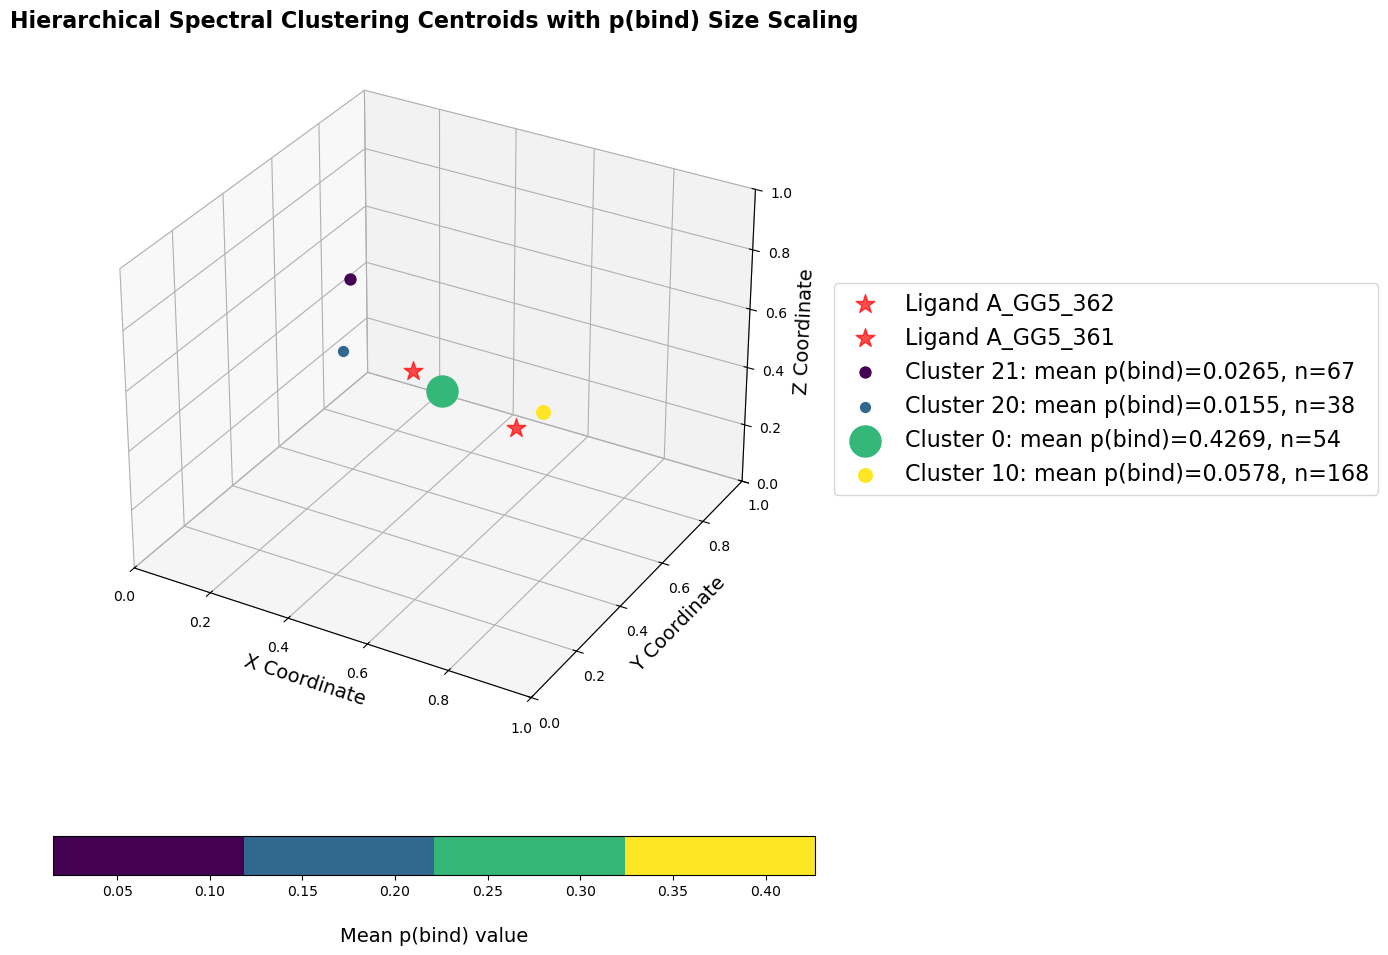

In [ ]:
visualize_centroids_pbind_size(df_clustered_sprectral, ligand_centers, scalers, pdb_file, title="Hierarchical Spectral Clustering Centroids with p(bind) Size Scaling")

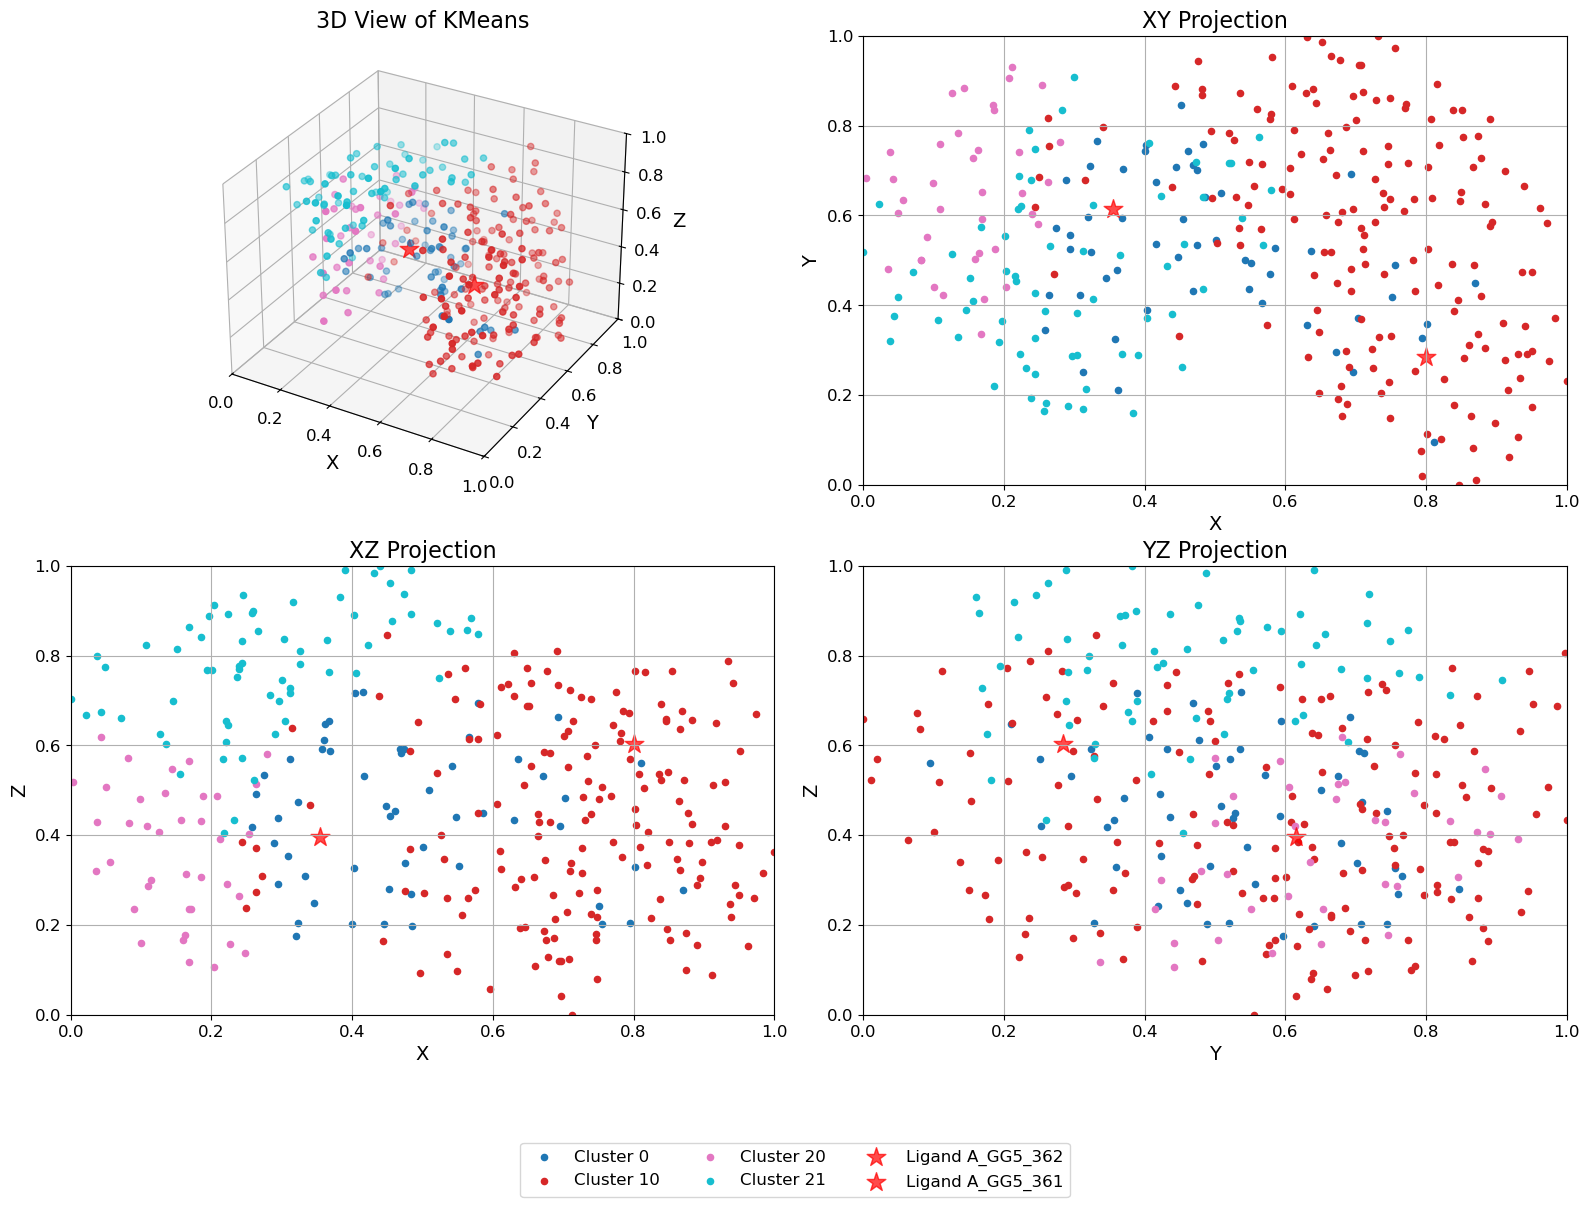

In [ ]:
visualize_cluster_projections(df_clustered_sprectral, ligand_centers_normalized, title="Hierarchical Spectral Clustering Visualization")

Initial Clusters' Mean p(bind): 
cluster_iteration_0
0    0.026720
1    0.298817
Name: p(bind), dtype: float64

Initial spectral clustering results:
Cluster counts: 
cluster_iteration_0
0    230
1     97
Name: count, dtype: int64


🔄 Iteration 1: Re-clustering cluster 0
Iteration 1 Clusters' Mean p(bind): 
cluster_iteration_1
0    0.013823
1    0.051852
Name: p(bind), dtype: float64
Selected cluster 0 for next iteration with mean p(bind): 0.013823
Remaining points: 152

Final clustering summary:
               Mean p(bind)  Count
final_cluster                     
1                  0.298817     97
10                 0.013823    152
11                 0.051852     78


/opt/miniconda3/envs/protein_pp/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/miniconda3/envs/protein_pp/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/miniconda3/envs/protein_pp/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/miniconda3/envs/protein_pp/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/miniconda3/envs/protein_pp/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler wa

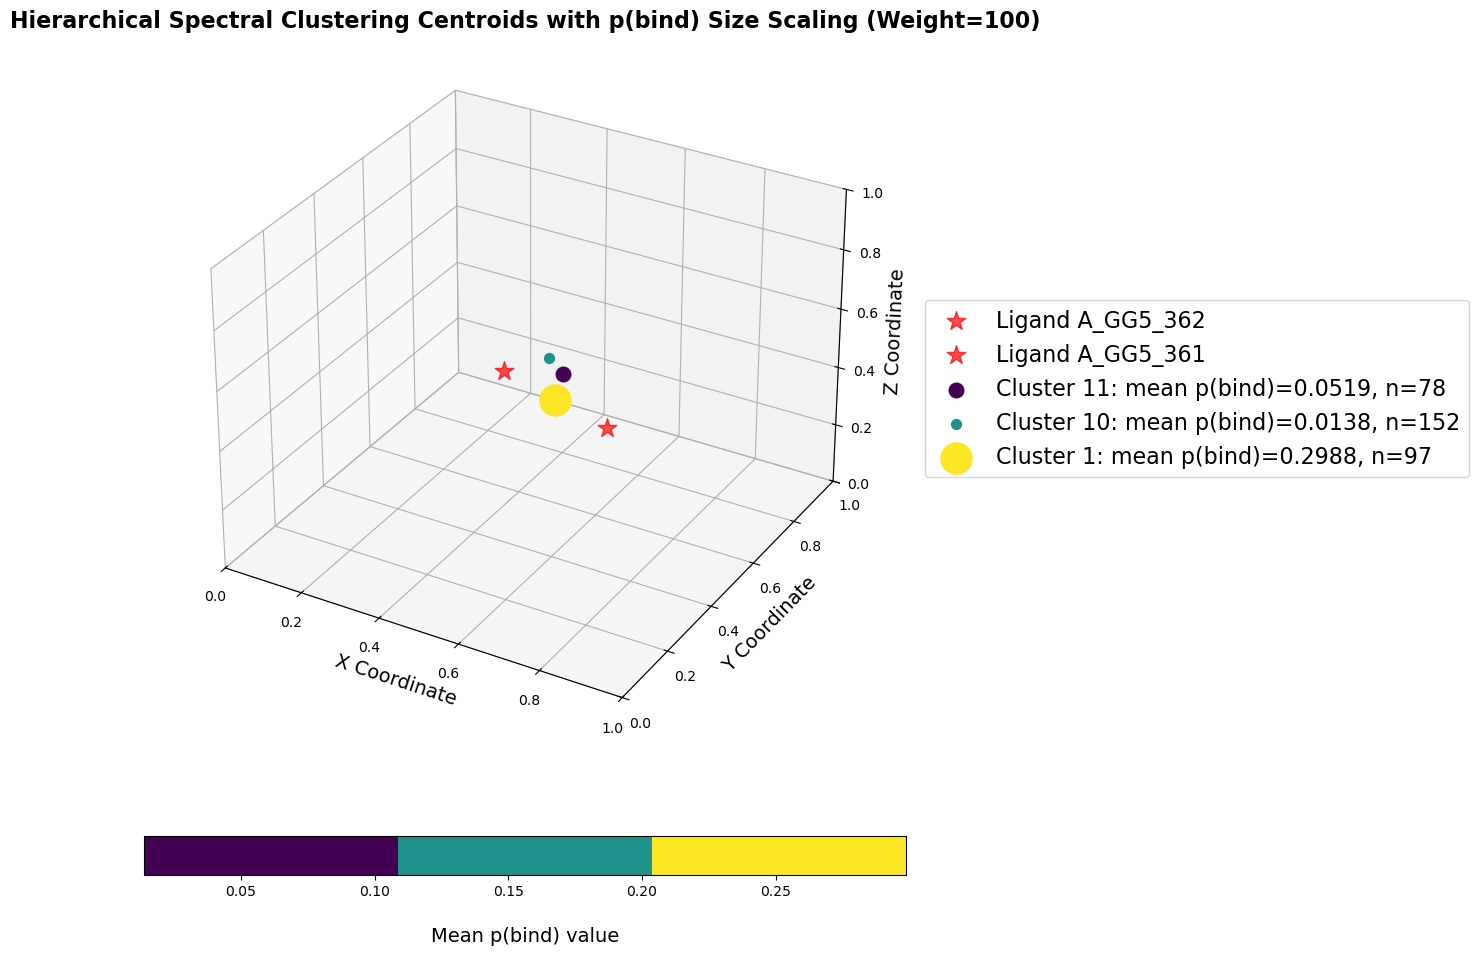

In [ ]:
df_clustered_sprectral_100 = hierarchical_clustering_pipeline(df_processed, 'spectral', n_clusters=2, pbind_weight=100, threshold=0.02)
visualize_centroids_pbind_size(df_clustered_sprectral_100, ligand_centers, scalers, pdb_file, title="Hierarchical Spectral Clustering Centroids with p(bind) Size Scaling (Weight=100)")

### Hierachical clustering with the Kmeans

Initial Clusters' Mean p(bind): 
kmeans_cluster_iteration_0
0    0.069866
1    0.654840
Name: p(bind), dtype: float64

Initial clustering results:
Cluster counts: kmeans_cluster_iteration_0
0    306
1     21
Name: count, dtype: int64
Clusters and their mean p(bind) values:
Cluster 0: 306 points, mean p(bind) = 0.069866
Cluster 1: 21 points, mean p(bind) = 0.654840

🔄 Iteration 1: Re-clustering cluster 0
Iteration 1 Clusters' Mean p(bind): 
kmeans_cluster_iteration_1
0    0.034673
1    0.237864
Name: p(bind), dtype: float64
Selected cluster 0 for next iteration with mean p(bind): 0.034673
Remaining points: 253

🔄 Iteration 2: Re-clustering cluster 0
Iteration 2 Clusters' Mean p(bind): 
kmeans_cluster_iteration_2
0    0.040864
1    0.027125
Name: p(bind), dtype: float64
Selected cluster 1 for next iteration with mean p(bind): 0.027125
Remaining points: 114

🔄 Iteration 3: Re-clustering cluster 1
Iteration 3 Clusters' Mean p(bind): 
kmeans_cluster_iteration_3
0    0.024738
1    0.029777
N

/opt/miniconda3/envs/protein_pp/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/miniconda3/envs/protein_pp/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/miniconda3/envs/protein_pp/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/miniconda3/envs/protein_pp/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/miniconda3/envs/protein_pp/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler wa

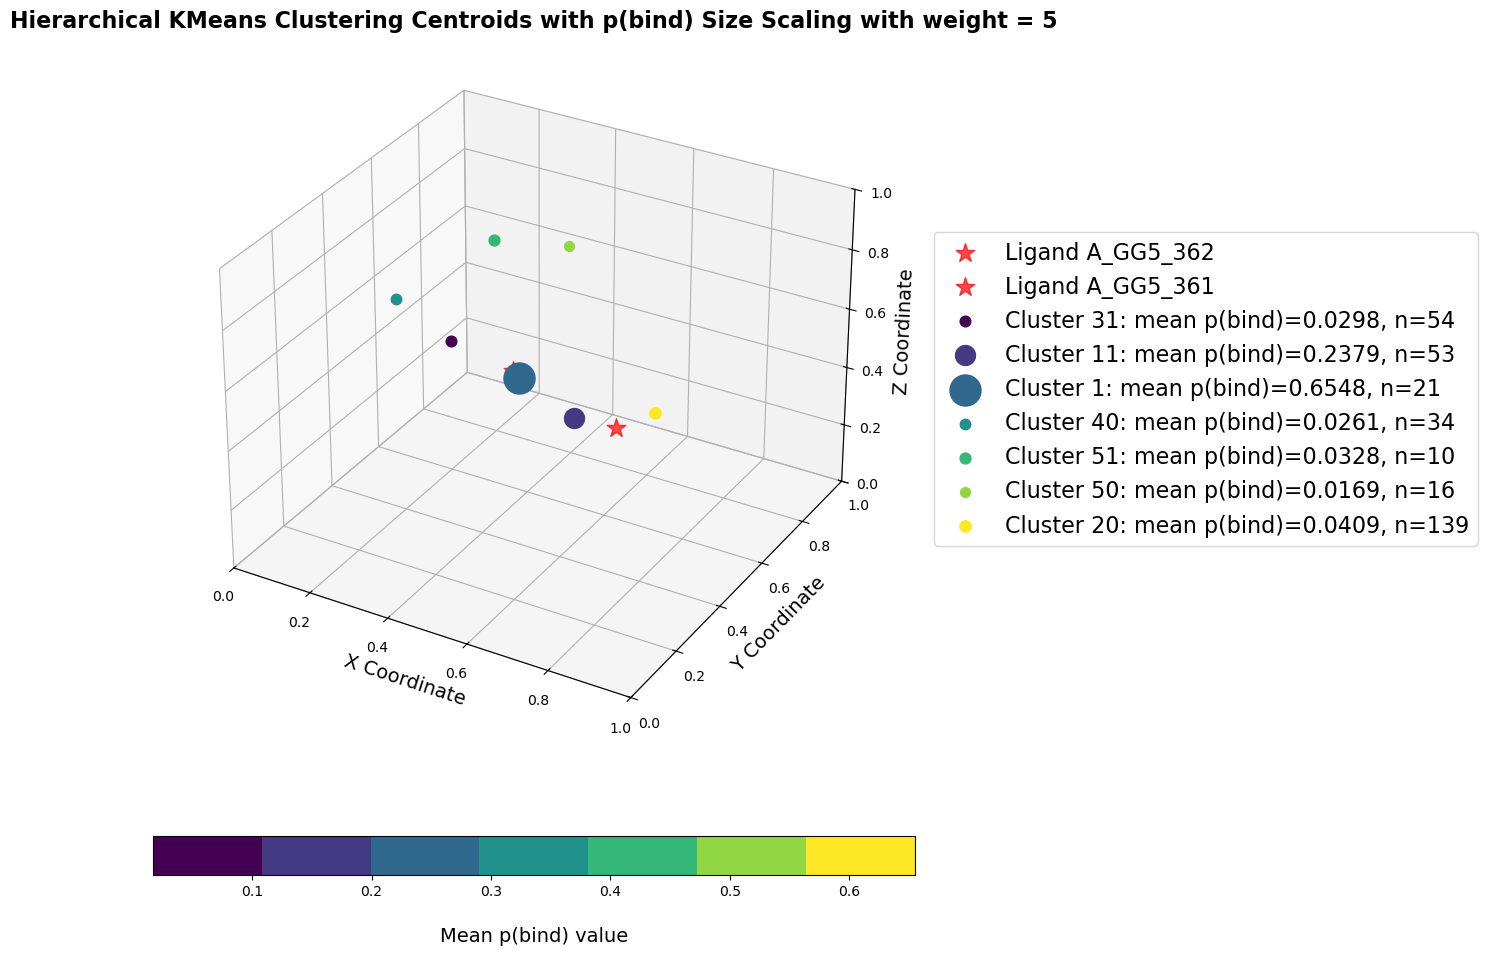

In [ ]:
df_clustered_kmean_5 = hierarchical_kmeans_clustering(df_processed, feature_cols, 'p(bind)', n_clusters=2, pbind_weight=5, threshold=0.02)
visualize_centroids_pbind_size(df_clustered_kmean, ligand_centers, scalers, pdb_file, title="Hierarchical KMeans Clustering Centroids with p(bind) Size Scaling with weight = 5")

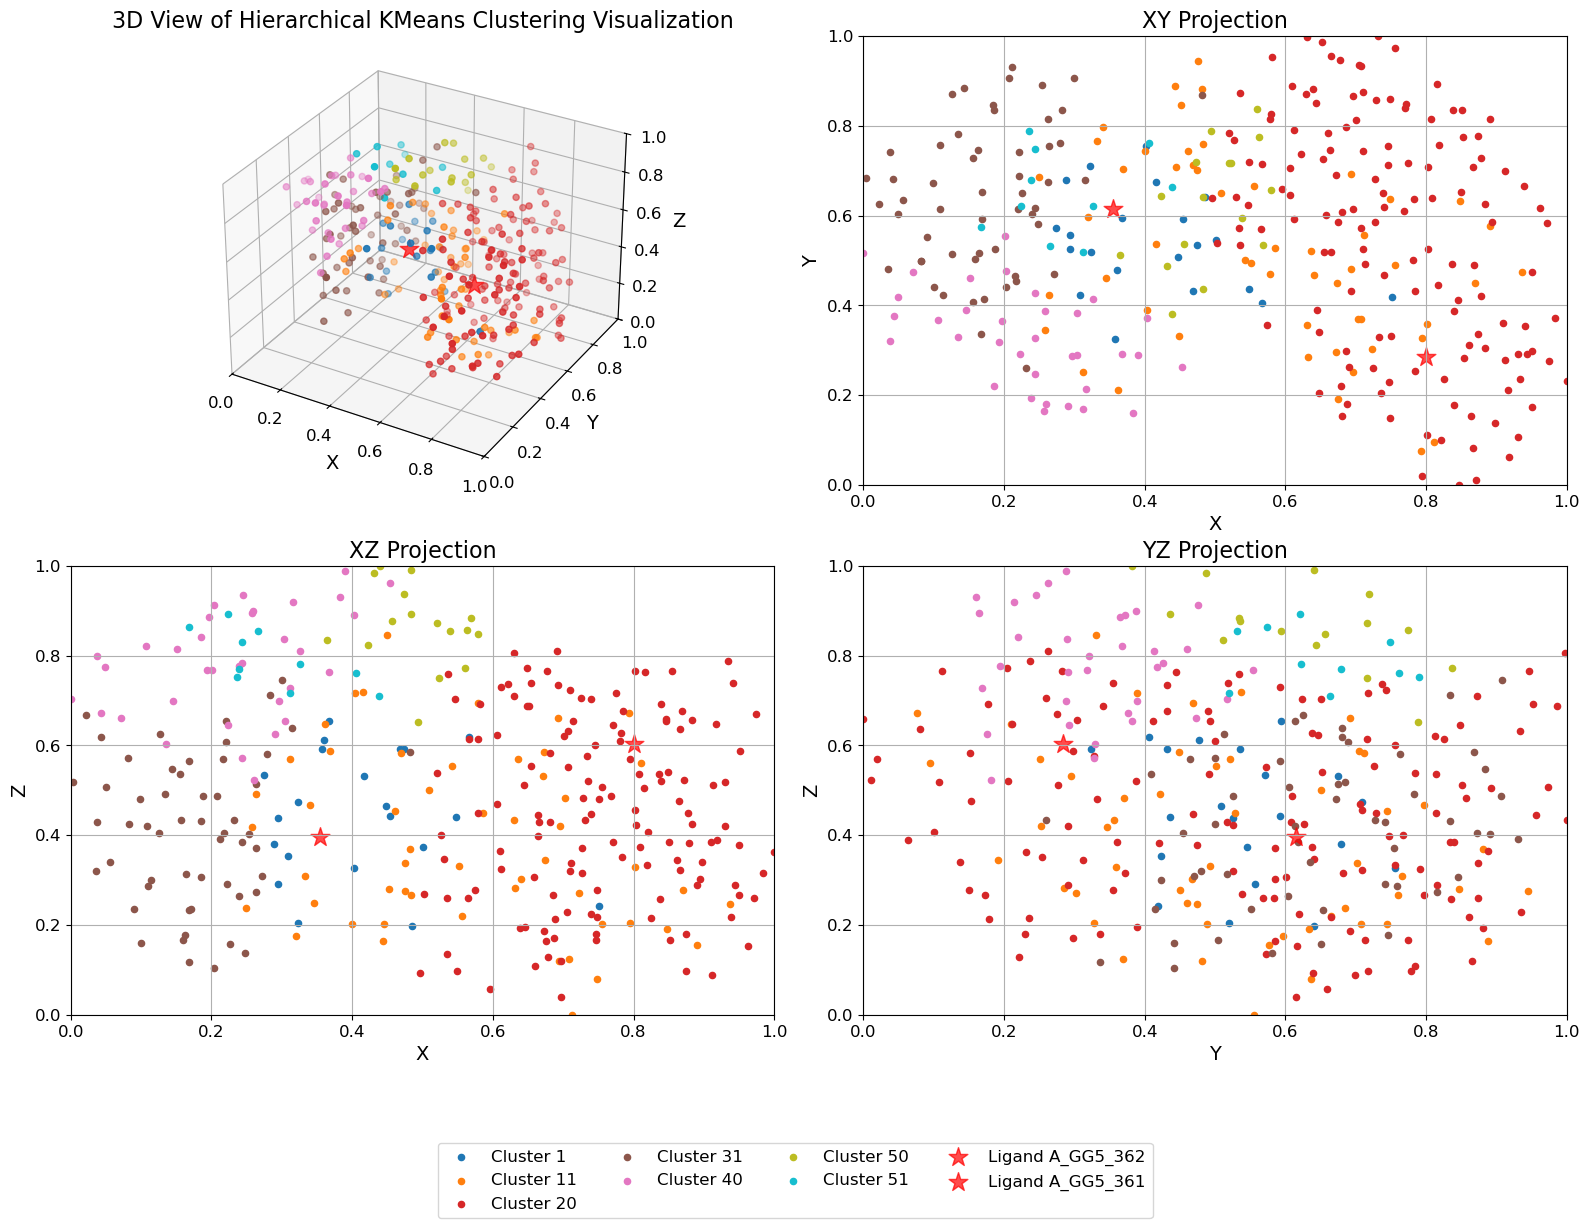

In [ ]:
visualize_cluster_projections(df_clustered_kmean_5, ligand_centers_normalized, title="Hierarchical KMeans Clustering Visualization")

Initial Clusters' Mean p(bind): 
cluster_iteration_0
0    0.053546
1    0.494080
Name: p(bind), dtype: float64

Initial kmeans clustering results:
Cluster counts: 
cluster_iteration_0
0    287
1     40
Name: count, dtype: int64


🔄 Iteration 1: Re-clustering cluster 0
Iteration 1 Clusters' Mean p(bind): 
cluster_iteration_1
0    0.026720
1    0.161791
Name: p(bind), dtype: float64
Selected cluster 0 for next iteration with mean p(bind): 0.026720
Remaining points: 230

🔄 Iteration 2: Re-clustering cluster 0
Iteration 2 Clusters' Mean p(bind): 
cluster_iteration_2
0    0.056496
1    0.015731
Name: p(bind), dtype: float64
Selected cluster 1 for next iteration with mean p(bind): 0.015731
Remaining points: 168

Final clustering summary:
               Mean p(bind)  Count
final_cluster                     
1                  0.494080     40
11                 0.161791     57
20                 0.056496     62
21                 0.015731    168


/opt/miniconda3/envs/protein_pp/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/miniconda3/envs/protein_pp/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/miniconda3/envs/protein_pp/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/miniconda3/envs/protein_pp/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/miniconda3/envs/protein_pp/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler wa

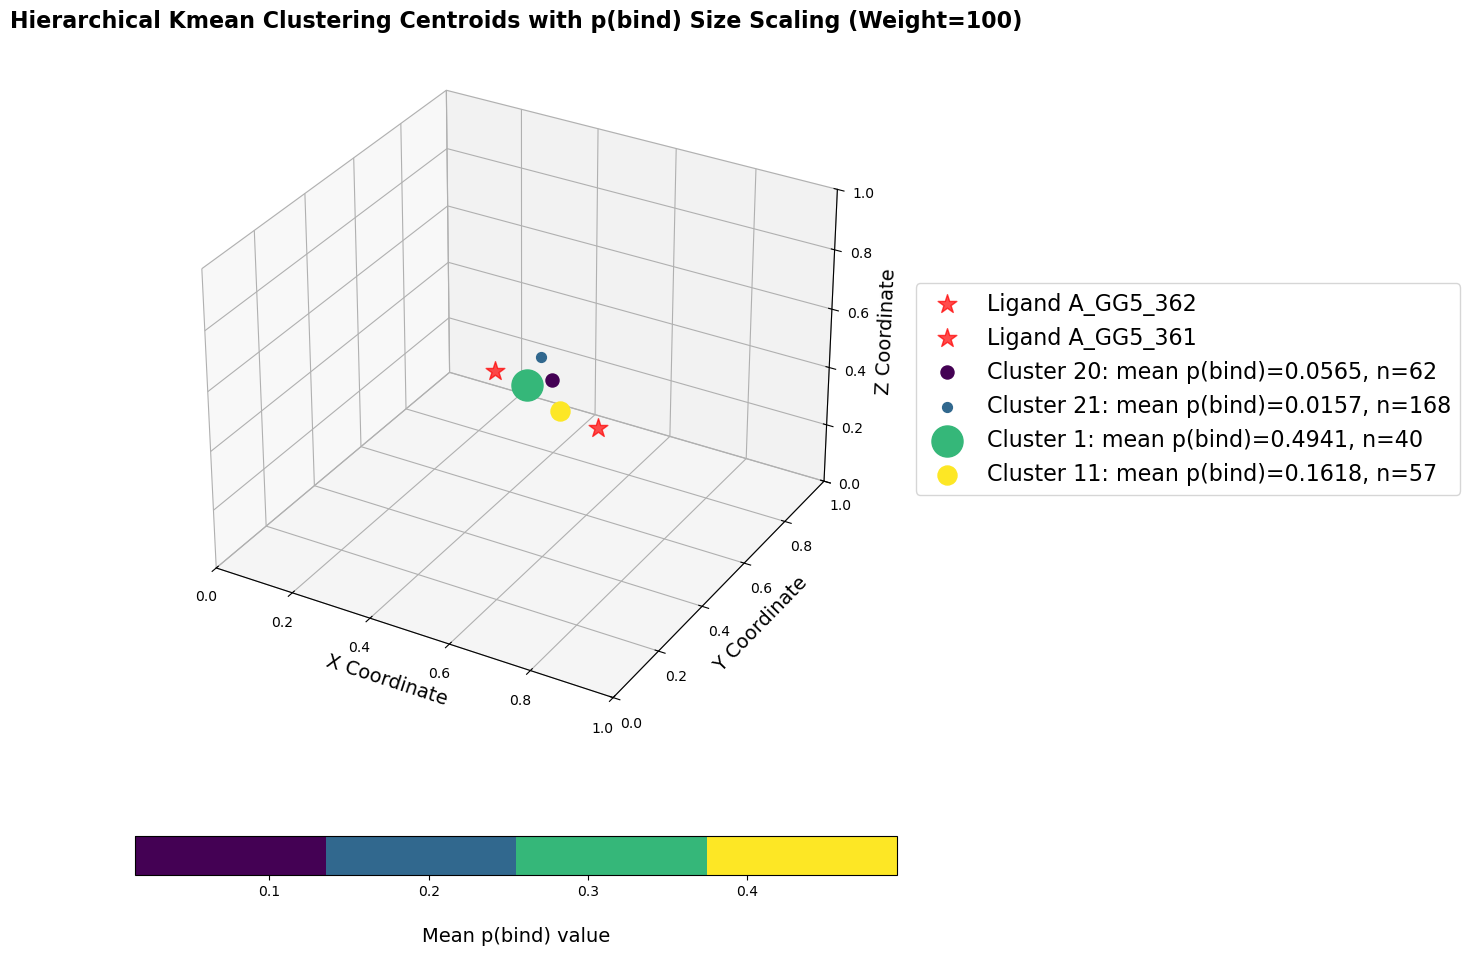

In [ ]:
df_clustered_kmean_100 = hierarchical_clustering_pipeline(df_processed, 'kmeans', n_clusters=2, pbind_weight=100, threshold=0.02)
visualize_centroids_pbind_size(df_clustered_kmean_100, ligand_centers, scalers, pdb_file, title="Hierarchical Kmean Clustering Centroids with p(bind) Size Scaling (Weight=100)")

Initial Clusters' Mean p(bind): 
cluster_iteration_0
0    0.538015
1    0.059103
Name: p(bind), dtype: float64

Initial kmeans clustering results:
Cluster counts: 
cluster_iteration_0
1    294
0     33
Name: count, dtype: int64


🔄 Iteration 1: Re-clustering cluster 1
Iteration 1 Clusters' Mean p(bind): 
cluster_iteration_1
0    0.043145
1    0.071408
Name: p(bind), dtype: float64
Selected cluster 0 for next iteration with mean p(bind): 0.043145
Remaining points: 128

🔄 Iteration 2: Re-clustering cluster 0
Iteration 2 Clusters' Mean p(bind): 
cluster_iteration_2
0    0.039875
1    0.045382
Name: p(bind), dtype: float64
Selected cluster 0 for next iteration with mean p(bind): 0.039875
Remaining points: 52

🔄 Iteration 3: Re-clustering cluster 0
Iteration 3 Clusters' Mean p(bind): 
cluster_iteration_3
0    0.027363
1    0.055651
Name: p(bind), dtype: float64
Selected cluster 0 for next iteration with mean p(bind): 0.027363
Remaining points: 29

🔄 Iteration 4: Re-clustering cluster 0
Iter

/opt/miniconda3/envs/protein_pp/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/miniconda3/envs/protein_pp/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/miniconda3/envs/protein_pp/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/miniconda3/envs/protein_pp/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/miniconda3/envs/protein_pp/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler wa

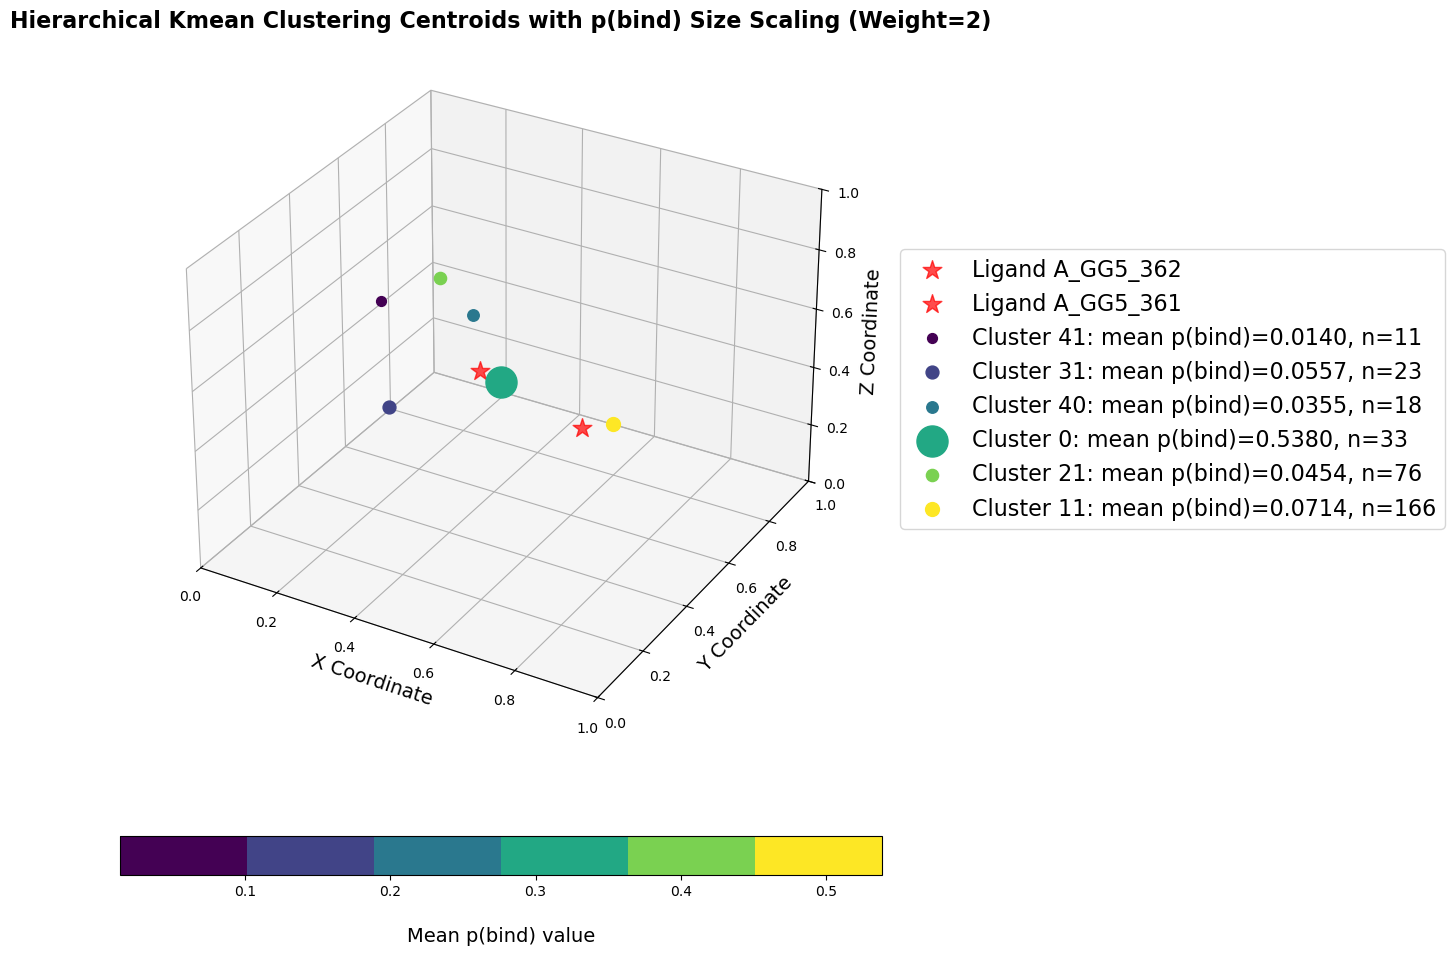

In [ ]:
df_clustered_kmean_2 = hierarchical_clustering_pipeline(df_processed, 'kmeans', n_clusters=2, pbind_weight=2, threshold=0.02)
visualize_centroids_pbind_size(df_clustered_kmean_2, ligand_centers, scalers, pdb_file, title="Hierarchical Kmean Clustering Centroids with p(bind) Size Scaling (Weight=2)")

In [ ]:
df_clustered_kmean_1 = hierarchical_clustering_pipeline(df_processed, 'kmeans', n_clusters=2, pbind_weight=1, threshold=0.02)
visualize_centroids_pbind_size(df_clustered_kmean_1, ligand_centers, scalers, pdb_file, title="Hierarchical Kmean Clustering Centroids with p(bind) Size Scaling (Weight=1)")

NameError: name 'df_processed' is not defined

### Hierachical Clustering with GMM

Initial Clusters' Mean p(bind): 
cluster_iteration_0
0    0.059875
1    0.162866
Name: p(bind), dtype: float64

Initial gmm clustering results:
Cluster counts: 
cluster_iteration_0
0    176
1    151
Name: count, dtype: int64


🔄 Iteration 1: Re-clustering cluster 0
Iteration 1 Clusters' Mean p(bind): 
cluster_iteration_1
0    0.043969
1    0.082318
Name: p(bind), dtype: float64
Selected cluster 0 for next iteration with mean p(bind): 0.043969
Remaining points: 103

🔄 Iteration 2: Re-clustering cluster 0
Iteration 2 Clusters' Mean p(bind): 
cluster_iteration_2
0    0.057498
1    0.019836
Name: p(bind), dtype: float64
Selected cluster 1 for next iteration with mean p(bind): 0.019836
Remaining points: 37

Final clustering summary:
               Mean p(bind)  Count
final_cluster                     
1                  0.162866    151
11                 0.082318     73
20                 0.057498     66
21                 0.019836     37


/opt/miniconda3/envs/protein_pp/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/miniconda3/envs/protein_pp/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/miniconda3/envs/protein_pp/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/miniconda3/envs/protein_pp/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/miniconda3/envs/protein_pp/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler wa

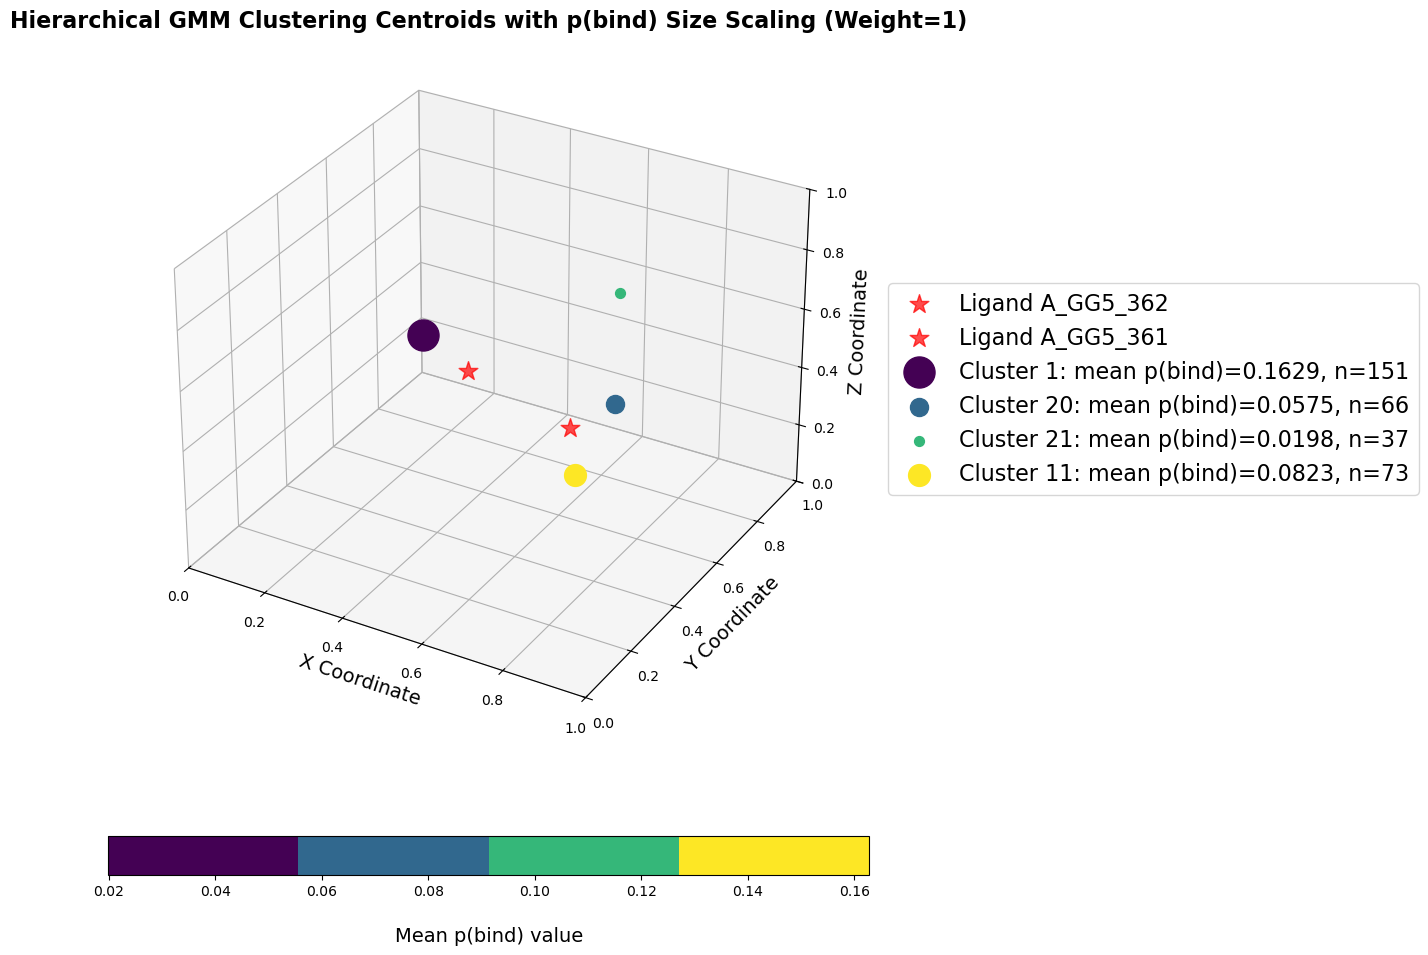

In [ ]:
# Hierachical clustering with GMM
df_clustered_gmm_1, summary_df = hierarchical_clustering_pipeline(df_processed, 'gmm', n_clusters=2, pbind_weight=1, threshold=0.02)

visualize_centroids_pbind_size(df_clustered_gmm_1, ligand_centers, scalers, pdb_file, title="Hierarchical GMM Clustering Centroids with p(bind) Size Scaling (Weight=1)")

Initial Clusters' Mean p(bind): 
cluster_iteration_0
0    0.269482
1    0.023018
Name: p(bind), dtype: float64

Initial gmm clustering results:
Cluster counts: 
cluster_iteration_0
1    215
0    112
Name: count, dtype: int64


🔄 Iteration 1: Re-clustering cluster 1
Iteration 1 Clusters' Mean p(bind): 
cluster_iteration_1
0    0.02490
1    0.02077
Name: p(bind), dtype: float64
Selected cluster 1 for next iteration with mean p(bind): 0.020770
Remaining points: 98

🔄 Iteration 2: Re-clustering cluster 1
Iteration 2 Clusters' Mean p(bind): 
cluster_iteration_2
0    0.024580
1    0.012913
Name: p(bind), dtype: float64
Selected cluster 1 for next iteration with mean p(bind): 0.012913
Remaining points: 32

Final clustering summary:
               Mean p(bind)  Count
final_cluster                     
0                  0.269482    112
10                 0.024900    117
20                 0.024580     66
21                 0.012913     32


/opt/miniconda3/envs/protein_pp/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/miniconda3/envs/protein_pp/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/miniconda3/envs/protein_pp/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/miniconda3/envs/protein_pp/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/miniconda3/envs/protein_pp/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler wa

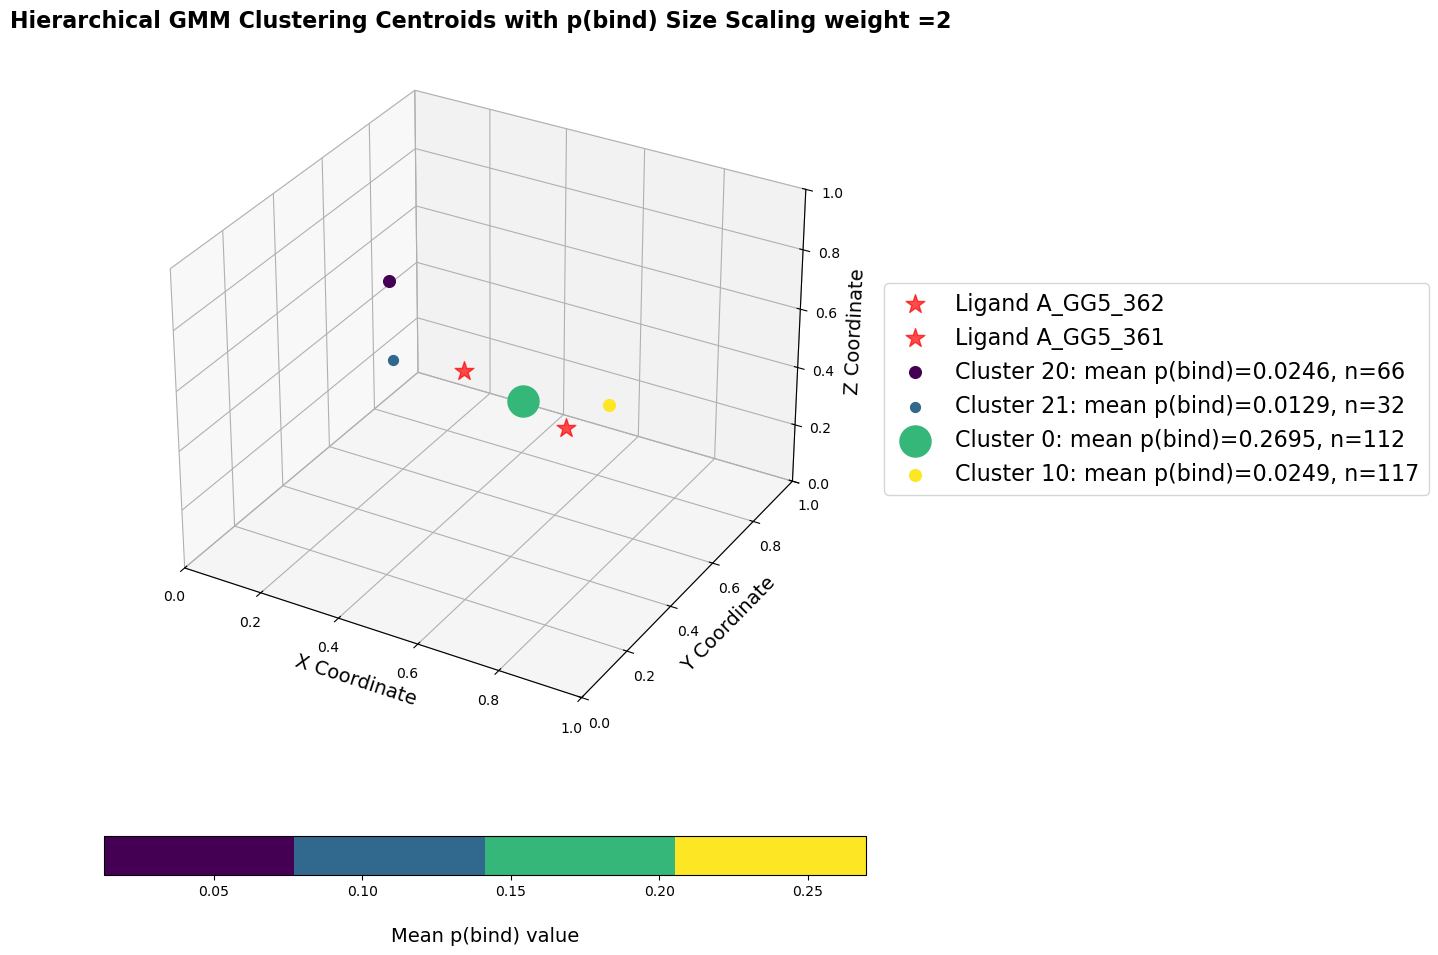

In [ ]:
df_clustered_gmm_2 = hierarchical_clustering_pipeline(df_processed, 'gmm', n_clusters=2, pbind_weight=2, threshold=0.02)
visualize_centroids_pbind_size(df_clustered_gmm_2, ligand_centers, scalers, pdb_file, title="Hierarchical GMM Clustering Centroids with p(bind) Size Scaling weight =2 ")

Initial Clusters' Mean p(bind): 
cluster_iteration_0
0    0.023226
1    0.271296
Name: p(bind), dtype: float64

Initial gmm clustering results:
Cluster counts: 
cluster_iteration_0
0    216
1    111
Name: count, dtype: int64


🔄 Iteration 1: Re-clustering cluster 0
Iteration 1 Clusters' Mean p(bind): 
cluster_iteration_1
0    0.025216
1    0.020875
Name: p(bind), dtype: float64
Selected cluster 1 for next iteration with mean p(bind): 0.020875
Remaining points: 99

🔄 Iteration 2: Re-clustering cluster 1
Iteration 2 Clusters' Mean p(bind): 
cluster_iteration_2
0    0.024678
1    0.012913
Name: p(bind), dtype: float64
Selected cluster 1 for next iteration with mean p(bind): 0.012913
Remaining points: 32

Final clustering summary:
               Mean p(bind)  Count
final_cluster                     
1                  0.271296    111
10                 0.025216    117
20                 0.024678     67
21                 0.012913     32


/opt/miniconda3/envs/protein_pp/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/miniconda3/envs/protein_pp/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/miniconda3/envs/protein_pp/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/miniconda3/envs/protein_pp/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/miniconda3/envs/protein_pp/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler wa

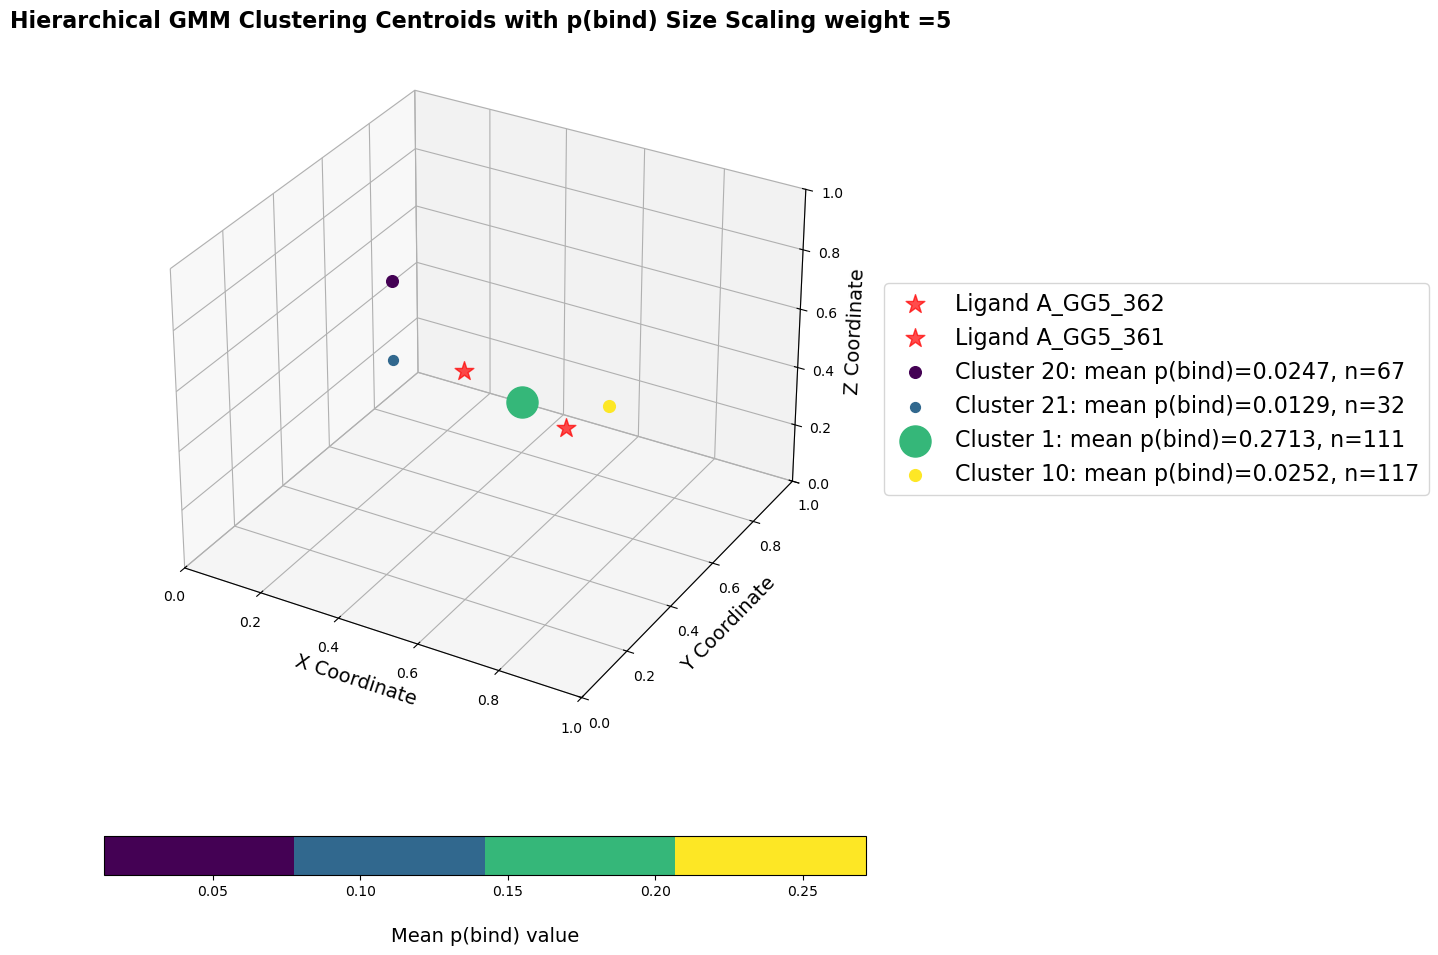

In [ ]:
df_clustered_gmm_5 = hierarchical_clustering_pipeline(df_processed, 'gmm', n_clusters=2, pbind_weight=5, threshold=0.02)
visualize_centroids_pbind_size(df_clustered_gmm_5, ligand_centers, scalers, pdb_file, title="Hierarchical GMM Clustering Centroids with p(bind) Size Scaling weight =5 ")

Initial Clusters' Mean p(bind): 
cluster_iteration_0
0    0.023226
1    0.271296
Name: p(bind), dtype: float64

Initial gmm clustering results:
Cluster counts: 
cluster_iteration_0
0    216
1    111
Name: count, dtype: int64


🔄 Iteration 1: Re-clustering cluster 0
Iteration 1 Clusters' Mean p(bind): 
cluster_iteration_1
0    0.008599
1    0.035836
Name: p(bind), dtype: float64
Selected cluster 0 for next iteration with mean p(bind): 0.008599
Remaining points: 100

Final clustering summary:
               Mean p(bind)  Count
final_cluster                     
1                  0.271296    111
10                 0.008599    100
11                 0.035836    116


/opt/miniconda3/envs/protein_pp/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/miniconda3/envs/protein_pp/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/miniconda3/envs/protein_pp/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/miniconda3/envs/protein_pp/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/miniconda3/envs/protein_pp/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler wa

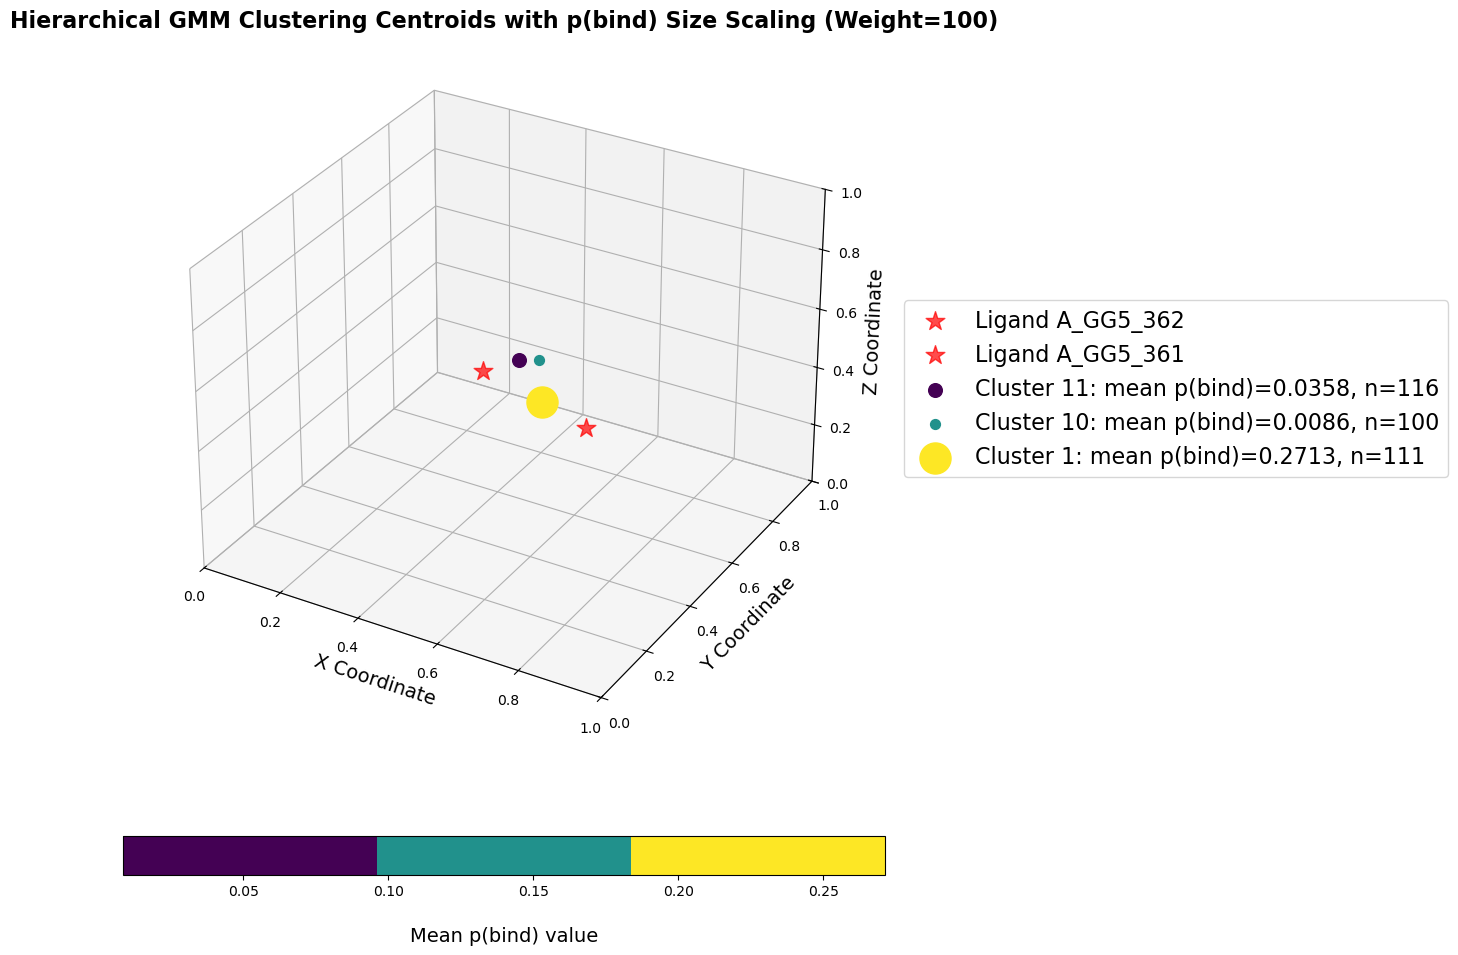

In [ ]:
df_clustered_gmm_100 = hierarchical_clustering_pipeline(df_processed, 'gmm', n_clusters=2, pbind_weight=100, threshold=0.02)
visualize_centroids_pbind_size(df_clustered_gmm_100, ligand_centers, scalers, pdb_file, title="Hierarchical GMM Clustering Centroids with p(bind) Size Scaling (Weight=100)")

## Apply the Fitering BEFORE the clustering



/opt/miniconda3/envs/protein_pp/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/miniconda3/envs/protein_pp/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/miniconda3/envs/protein_pp/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/miniconda3/envs/protein_pp/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/miniconda3/envs/protein_pp/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler wa

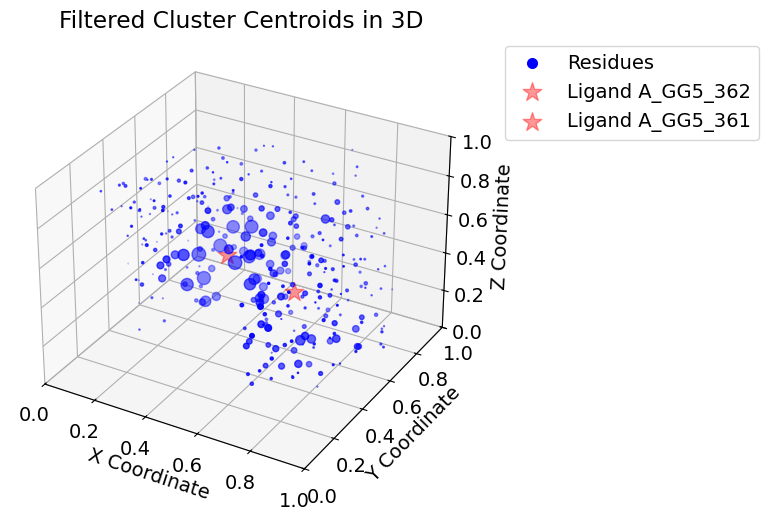

In [ ]:
# Visualize residues with p(bind) = size in 3D
ligand_centers = calculate_ligand_centers(pdb_file)

# Normalize ligand centers using separate scalers for each dimension
ligand_centers_normalized = {
    lig_id: [
        scalers['center_of_mass_x'].transform(np.array([[x]]))[0][0],
        scalers['center_of_mass_y'].transform(np.array([[y]]))[0][0],
        scalers['center_of_mass_z'].transform(np.array([[z]]))[0][0]
    ]
    for lig_id, (x, y, z) in ligand_centers.items()
}

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

# Plot resi in df with the 3D coordinates center_of_mass_x_normalized, center_of_mass_y_normalized, center_of_mass_z_normalized
ax.scatter(df['center_of_mass_x_normalized'], df['center_of_mass_y_normalized'], df['center_of_mass_z_normalized'], 
           s=df[pbind_column] * 100, c='blue', label='Residues')

# Plot ligand centers
for ligand_id, center in ligand_centers_normalized.items():
    ax.scatter(*center, color='red', marker='*', s=200, alpha=0.4, label=f'Ligand {ligand_id}')

ax.set_xlabel("X Coordinate")
ax.set_ylabel("Y Coordinate")
ax.set_zlabel("Z Coordinate")
ax.set_title("Filtered Cluster Centroids in 3D")

# Set axis limits to 0-1 scale
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.set_zlim([0, 1])

# Sort legend to prioritize clusters over ligands
handles, labels = ax.get_legend_handles_labels()
handles, labels = zip(*sorted(zip(handles, labels), key=lambda x: "Ligand" in x[1]))  # Moves ligands to end
ax.legend(handles, labels, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()